Analysis based on https://medium.com/orikami-blog/exploring-heart-rate-variability-using-python-483a7037c64d

In [1]:
import prep

# data science
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
import biosppy
from scipy.ndimage import label
from scipy.stats import zscore

In [2]:
#
filename = 'data_2/normokapnia/e[3]_[n]_[01].csv'
signal_name = 'abp_finger_mm_hg_[abp_finger_mm_Hg_]'
alternative_signal_name = 'abp_finger[abp_finger]'

# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

settings = {}
settings['fs'] = 200
TRESHOLD = 0.45

Helper functions

In [3]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [4]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

In [5]:

def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold
    sine wave with 15 points is used as default qrs filter
    '''
    if qrs_filter is None:
        # create default qrs filter
        t = np.linspace(-1, 1, 12)
        qrs_filter = np.cosh(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

Peaks Filter

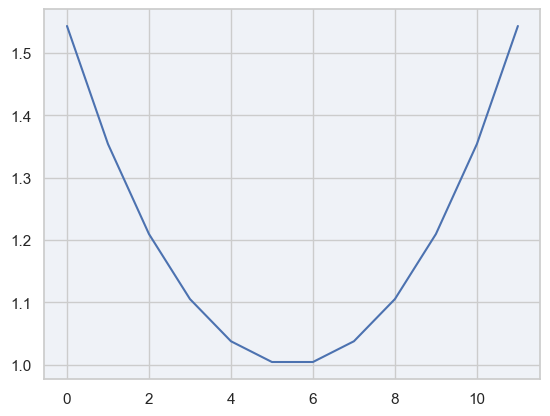

In [6]:
t = np.linspace(-1, 1, 12)
my_filter = np.cosh(t)
plt.plot(my_filter)

Load data

In [7]:
try:
    df = prep.read_data(filename, signal_name, ';')
except KeyError:
    df = prep.read_data(filename, alternative_signal_name, ';')
df.interpolate(method='linear', inplace=True)

Text(0, 0.5, 'Amplitude (arbitrary unit)')

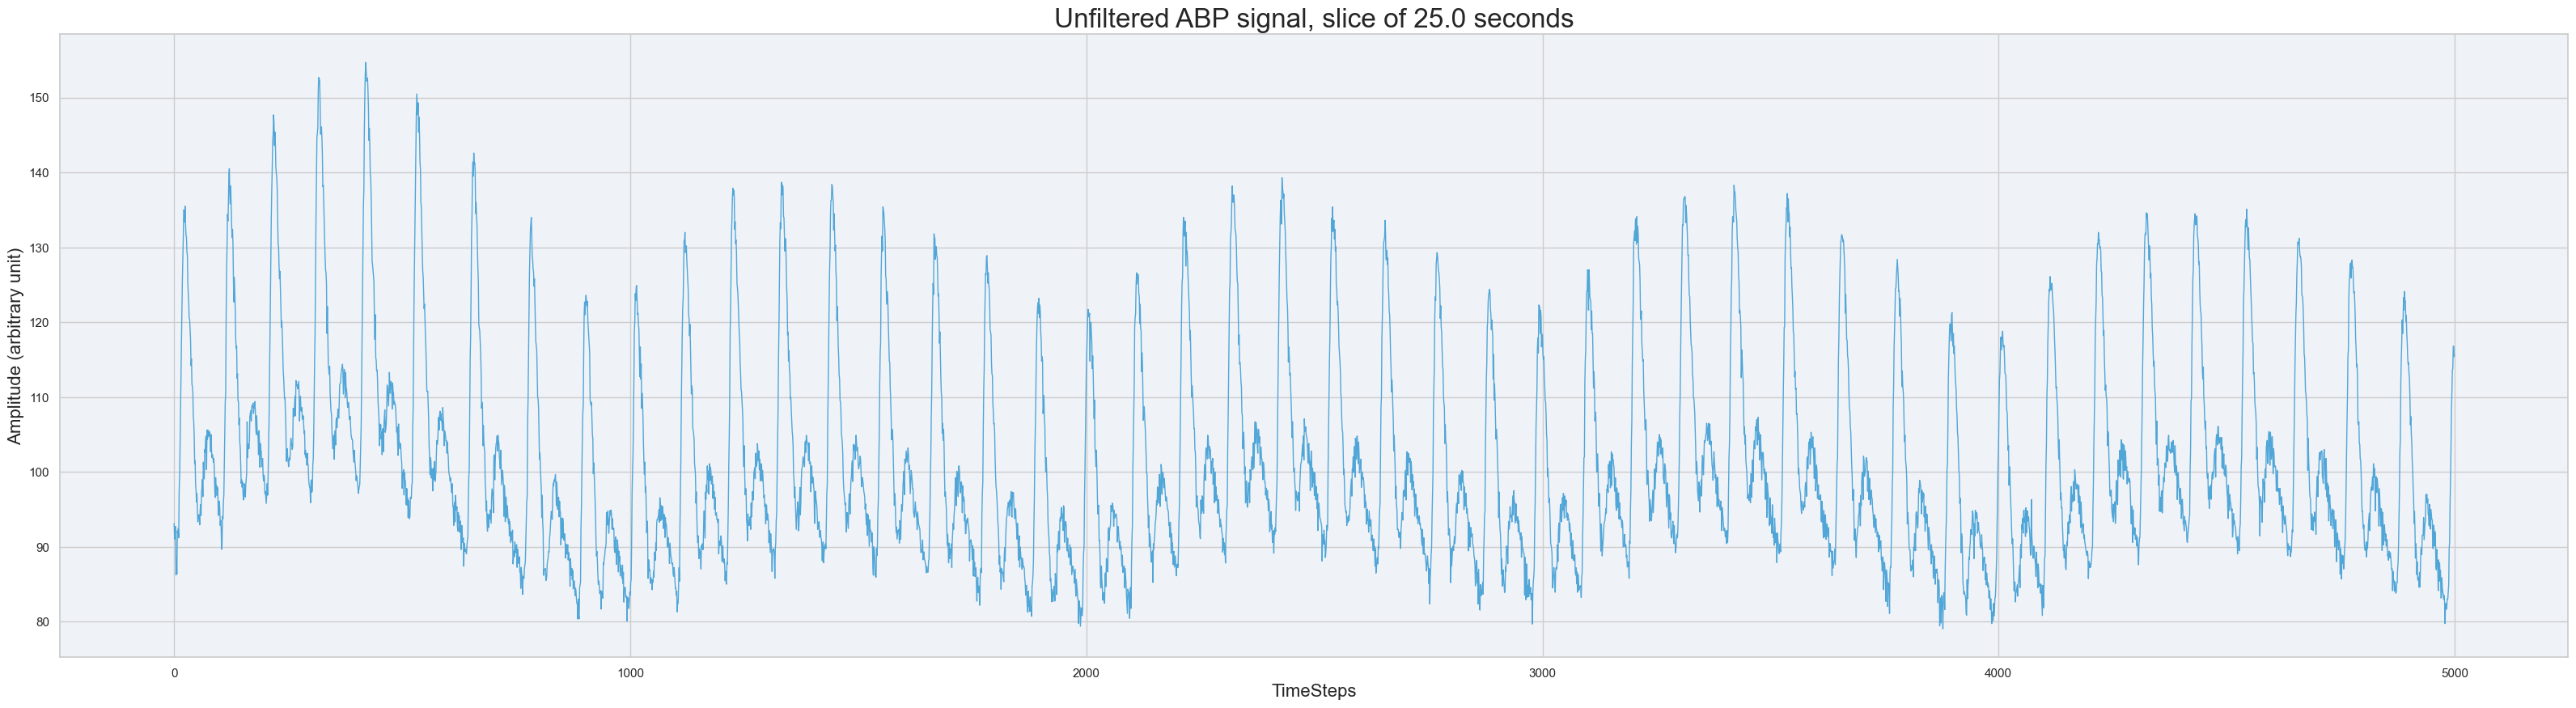

In [8]:
plt.figure(figsize=(40, 10))
start = 0
stop = 5000
duration = (stop-start) / settings['fs']
plt.title("Unfiltered ABP signal, slice of %.1f seconds" % duration, fontsize=24)
plt.plot(df[start:stop]['TimeSteps'], df[start:stop]['Values'], color="#51A6D8", linewidth=1)
plt.xlabel("TimeSteps", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

In [9]:
# applaying biosppy filter
filtered_abp = biosppy.signals.abp.abp(df["Values"], sampling_rate=200, show=False)[1]
df["Values"] = filtered_abp

filtered data sample preview

Text(0, 0.5, 'Amplitude (arbitrary unit)')

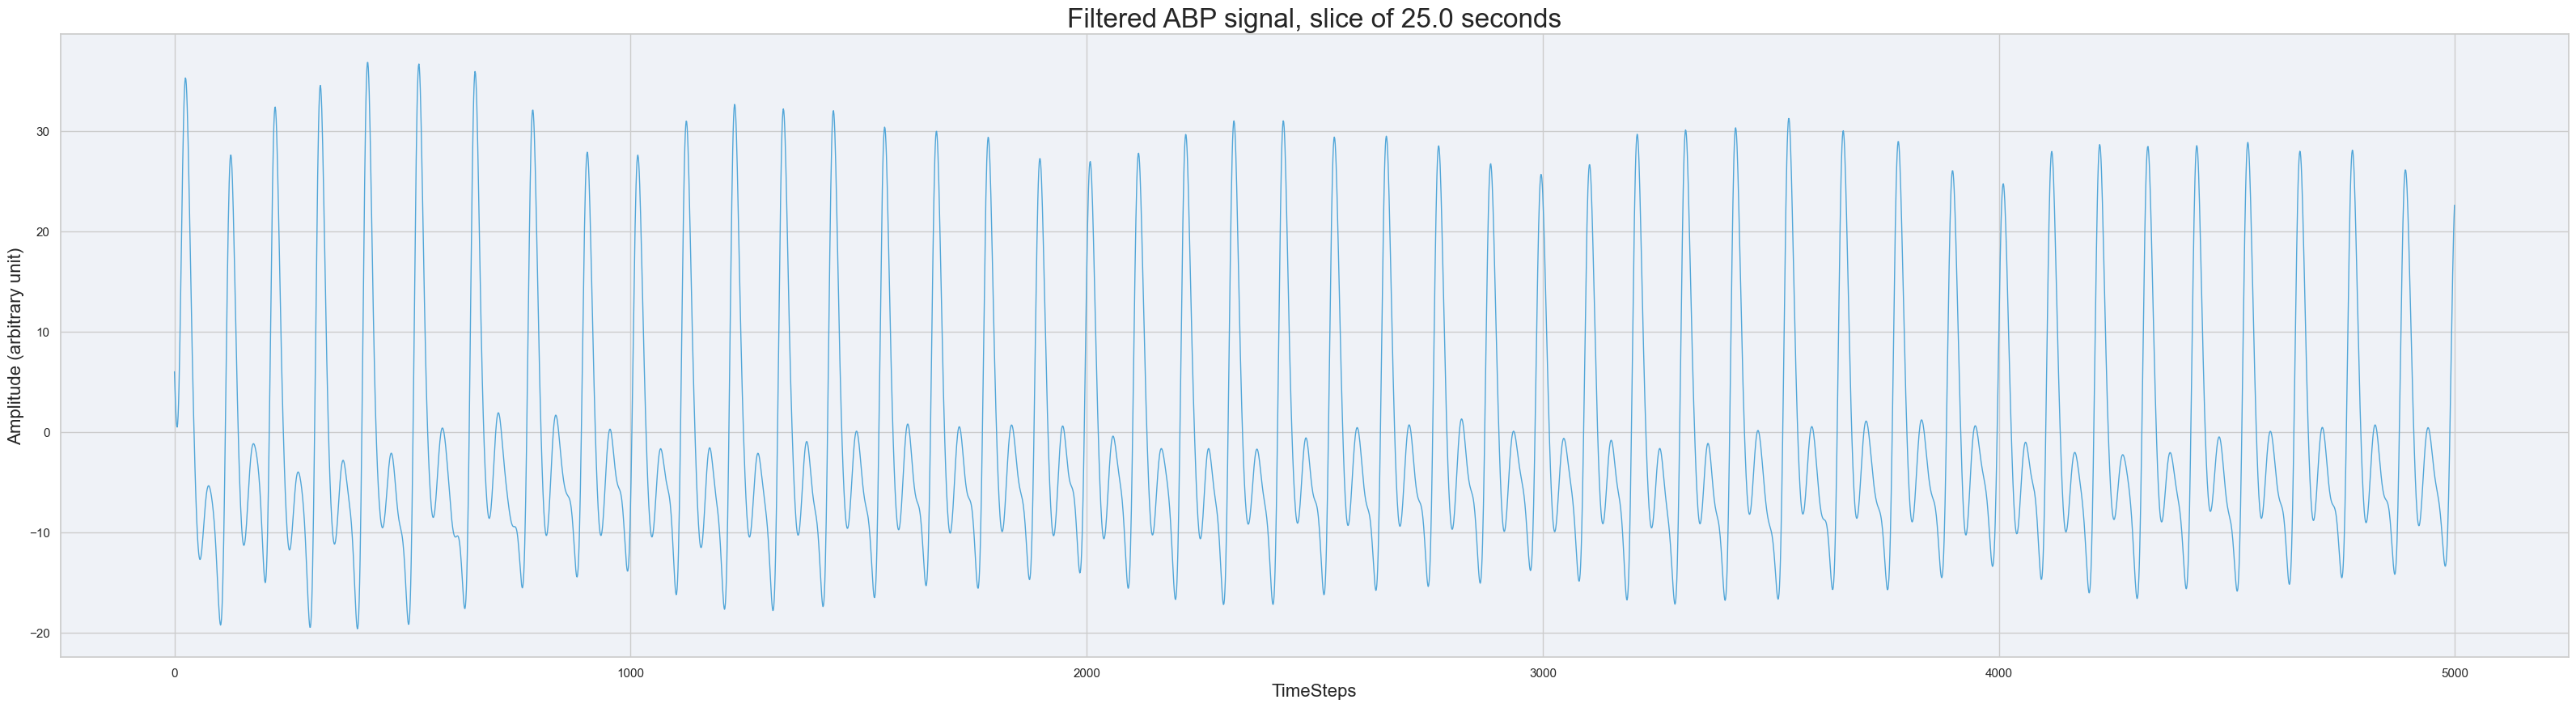

In [10]:
plt.figure(figsize=(40, 10))
start = 0
stop = 5000
duration = (stop-start) / settings['fs']
plt.title("Filtered ABP signal, slice of %.1f seconds" % duration, fontsize=24)
plt.plot(df[start:stop]['TimeSteps'], df[start:stop]['Values'], color="#51A6D8", linewidth=1)
plt.xlabel("TimeSteps", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

# Find RR-intervals

Peak detection using template mathcing & treshhold

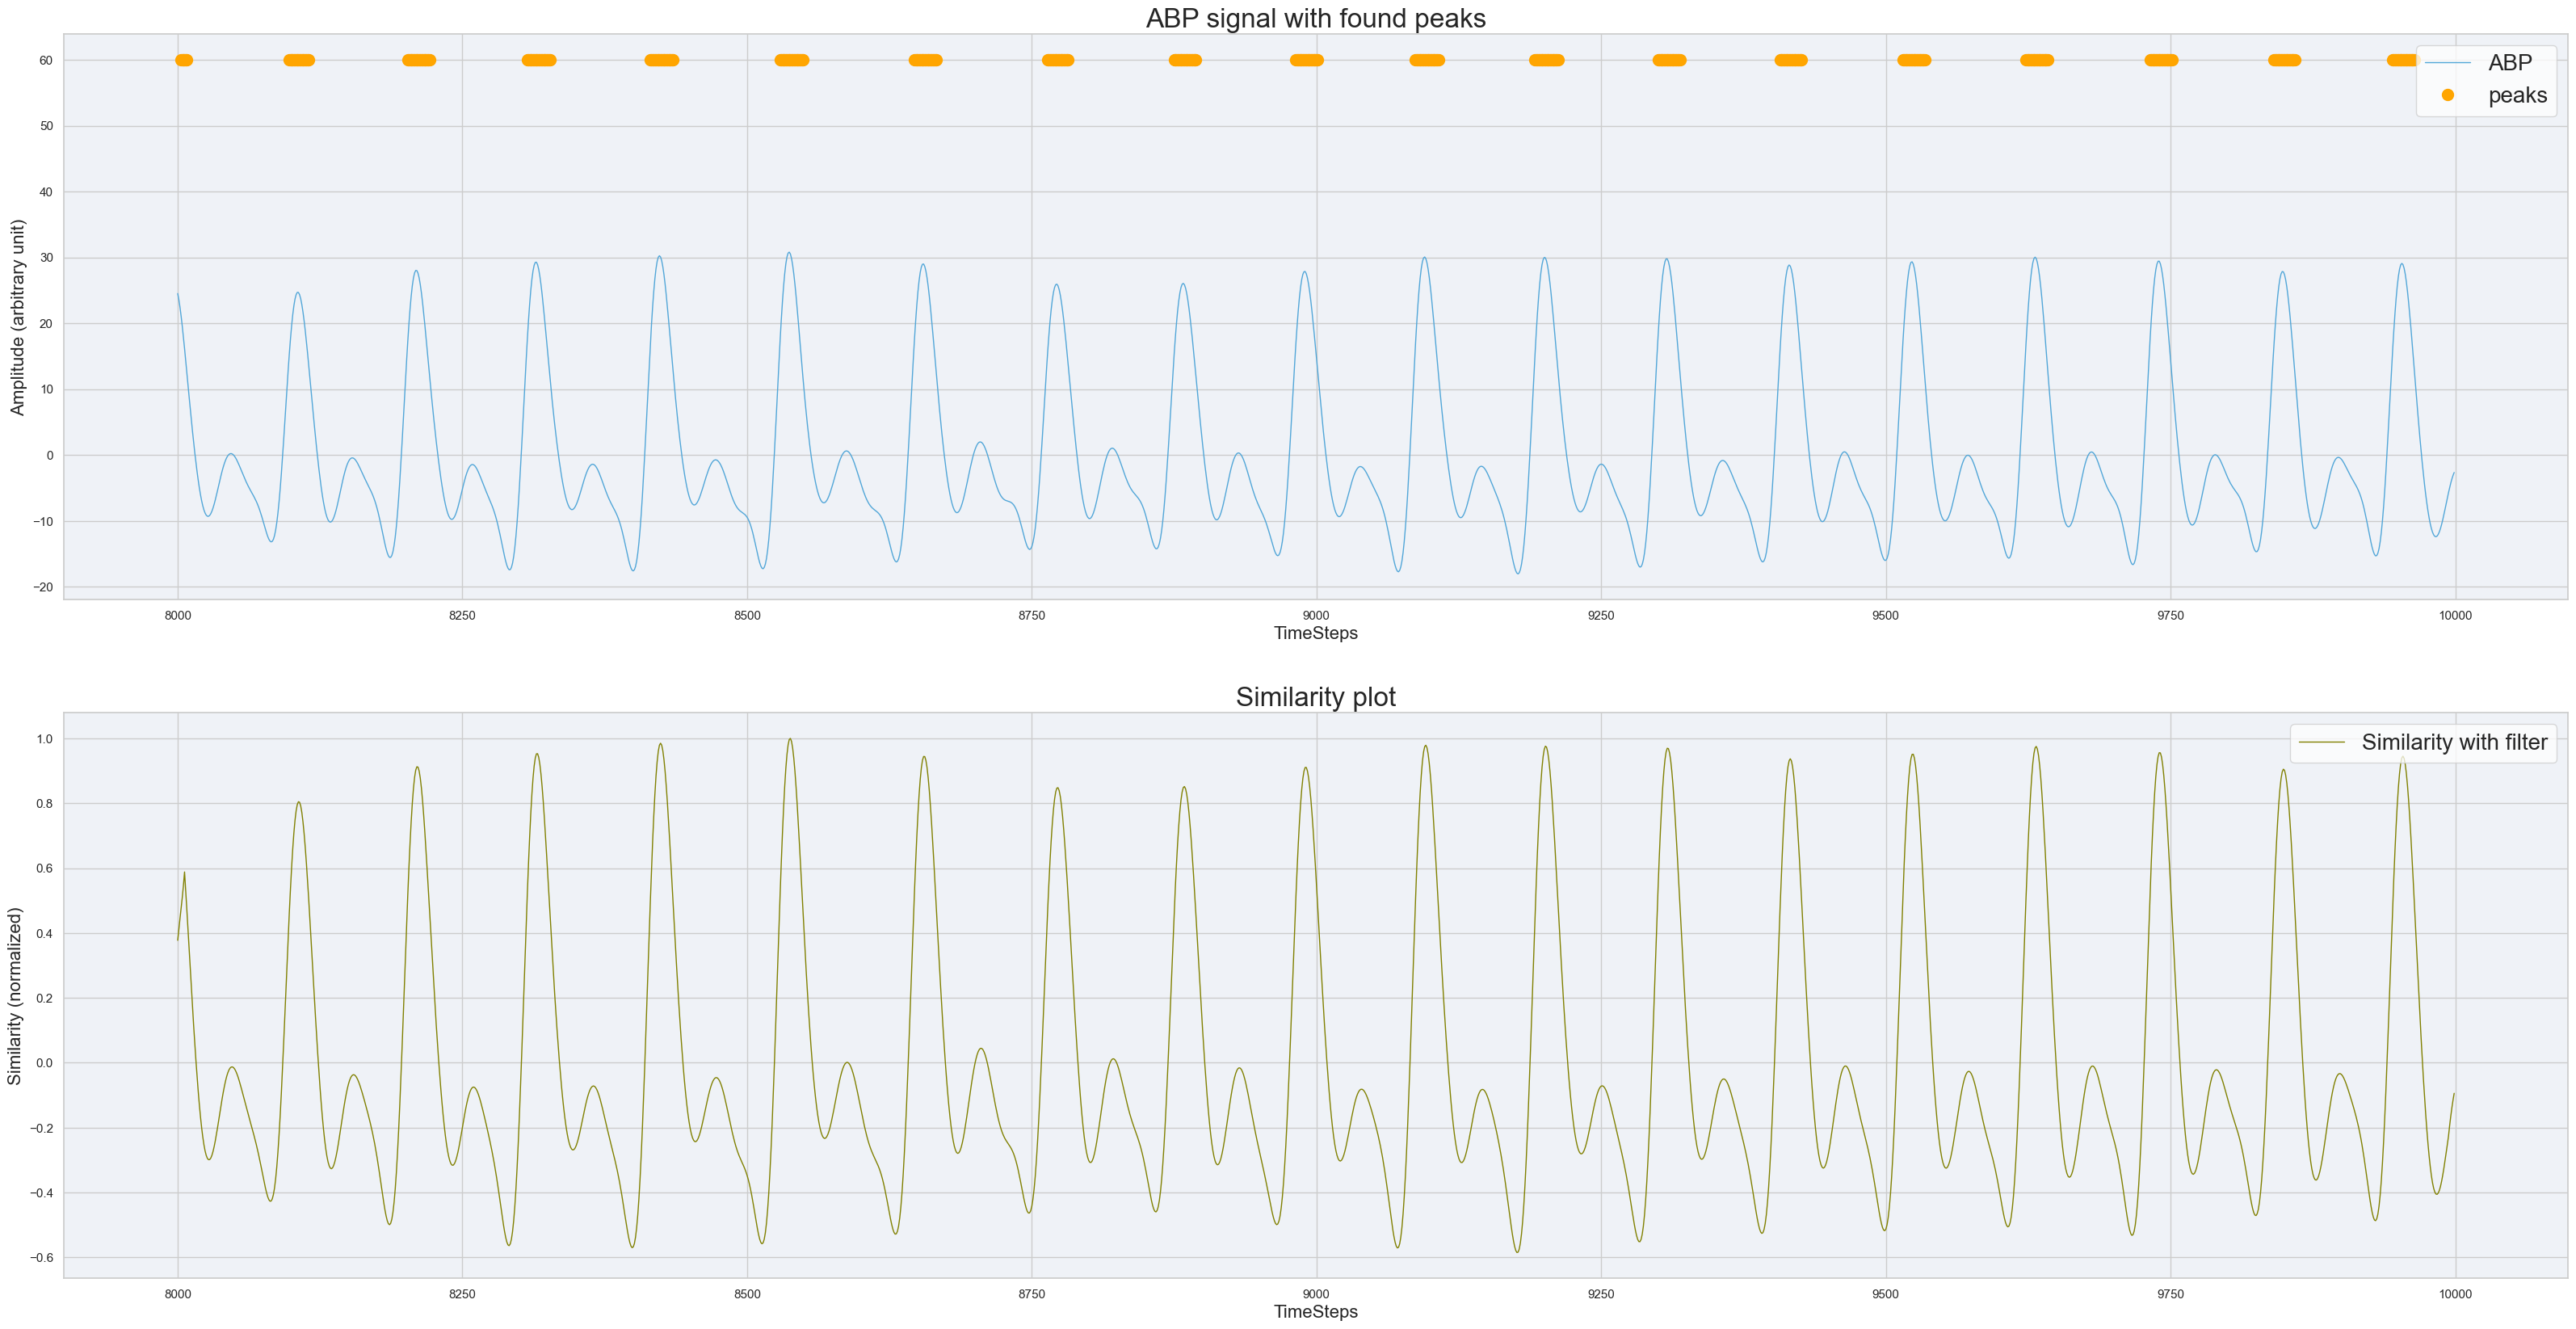

In [11]:
sampfrom = 8000
sampto = 10000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df.index >= start) & (df.index < stop) 
    abp_slice = df['Values'][cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(abp_slice, threshold=TRESHOLD)
    
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.subplot(211)
    plt.title("ABP signal with found peaks", fontsize=24)
    plt.plot(abp_slice.index, abp_slice, label="ABP", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(60, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right", fontsize=20)
    plt.xlabel("TimeSteps", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    
    plt.subplot(212)
    plt.title('Similarity plot', fontsize=24)
    plt.plot(abp_slice.index, similarity, label="Similarity with filter", color="olive", linewidth=1)
    plt.legend(loc="upper right", fontsize=20)
    plt.xlabel("TimeSteps", fontsize=16)
    plt.ylabel("Similarity (normalized)", fontsize=16)

# Grouping Simillar peaks

(200.0, 400.0)

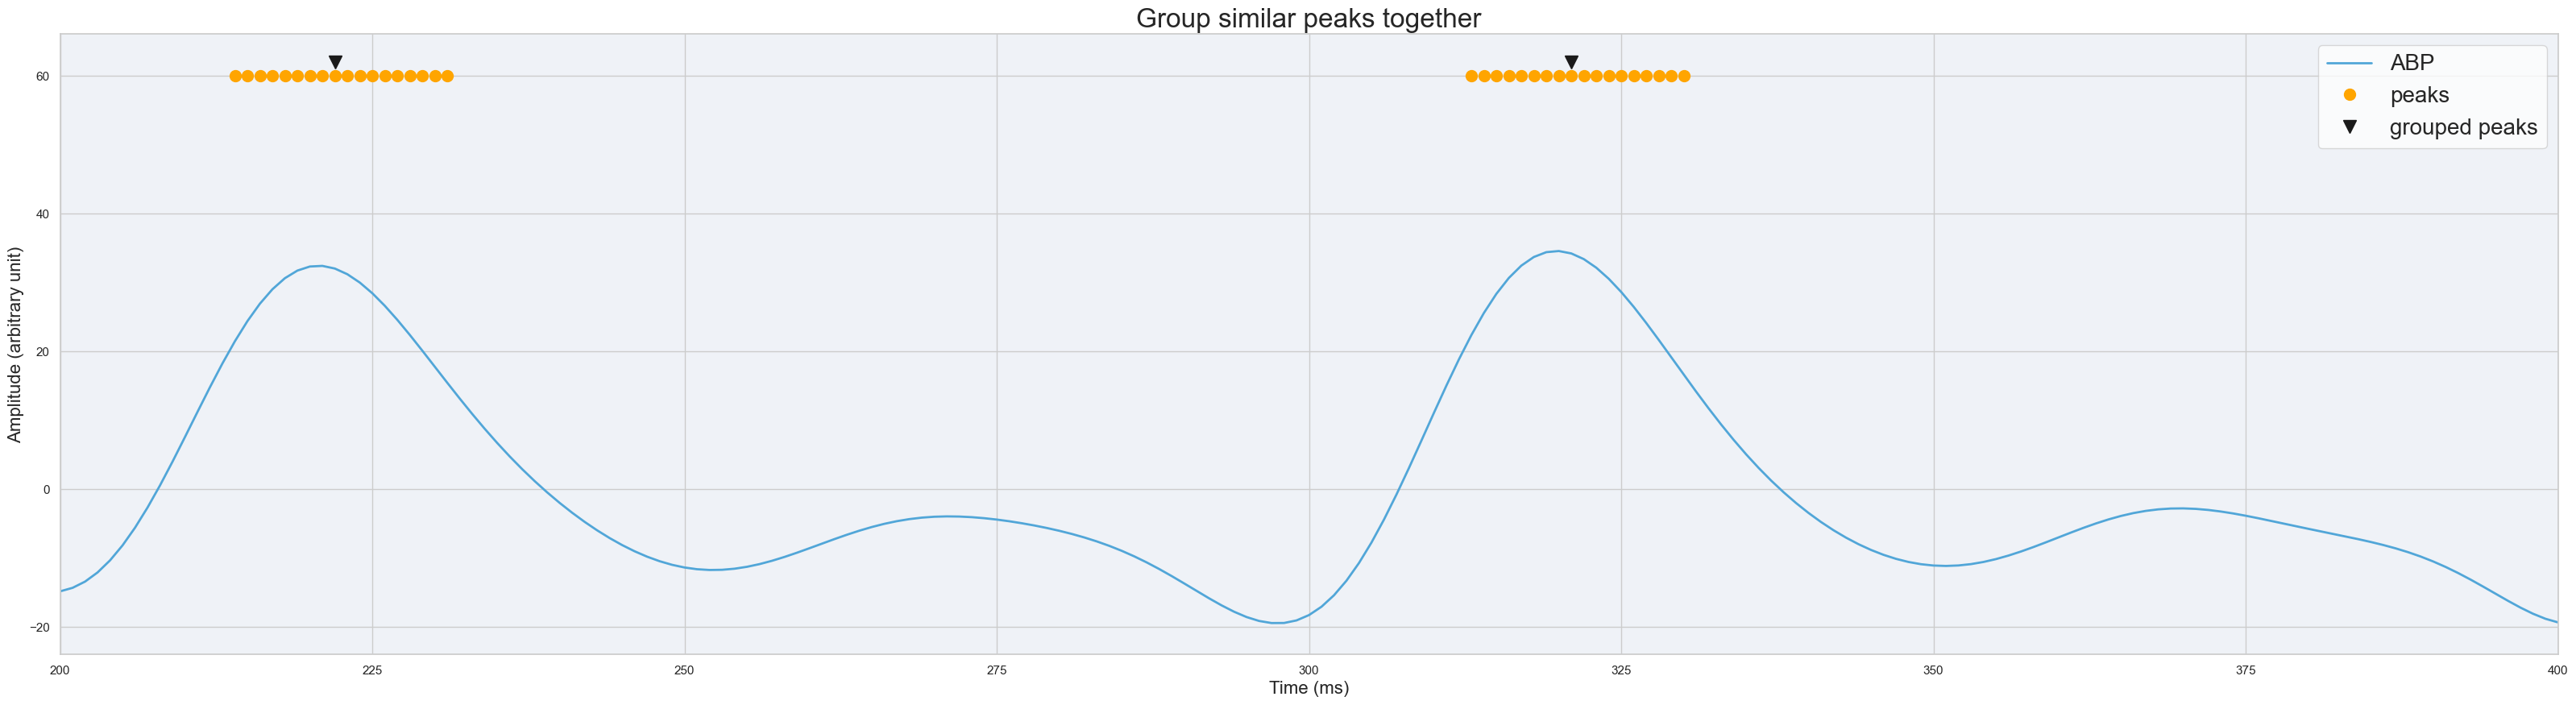

In [12]:
# detect peaks
peaks, similarity = detect_peaks(df['Values'], threshold=TRESHOLD)

# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(40, 10))
plt.title("Group similar peaks together", fontsize=24)
plt.plot(df.index, df['Values'], label="ABP", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(60, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(62, grouped_peaks.shape[0]), markersize=12, label="grouped peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right", fontsize=20)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
plt.gca().set_xlim(200, 400)

# RR intervals

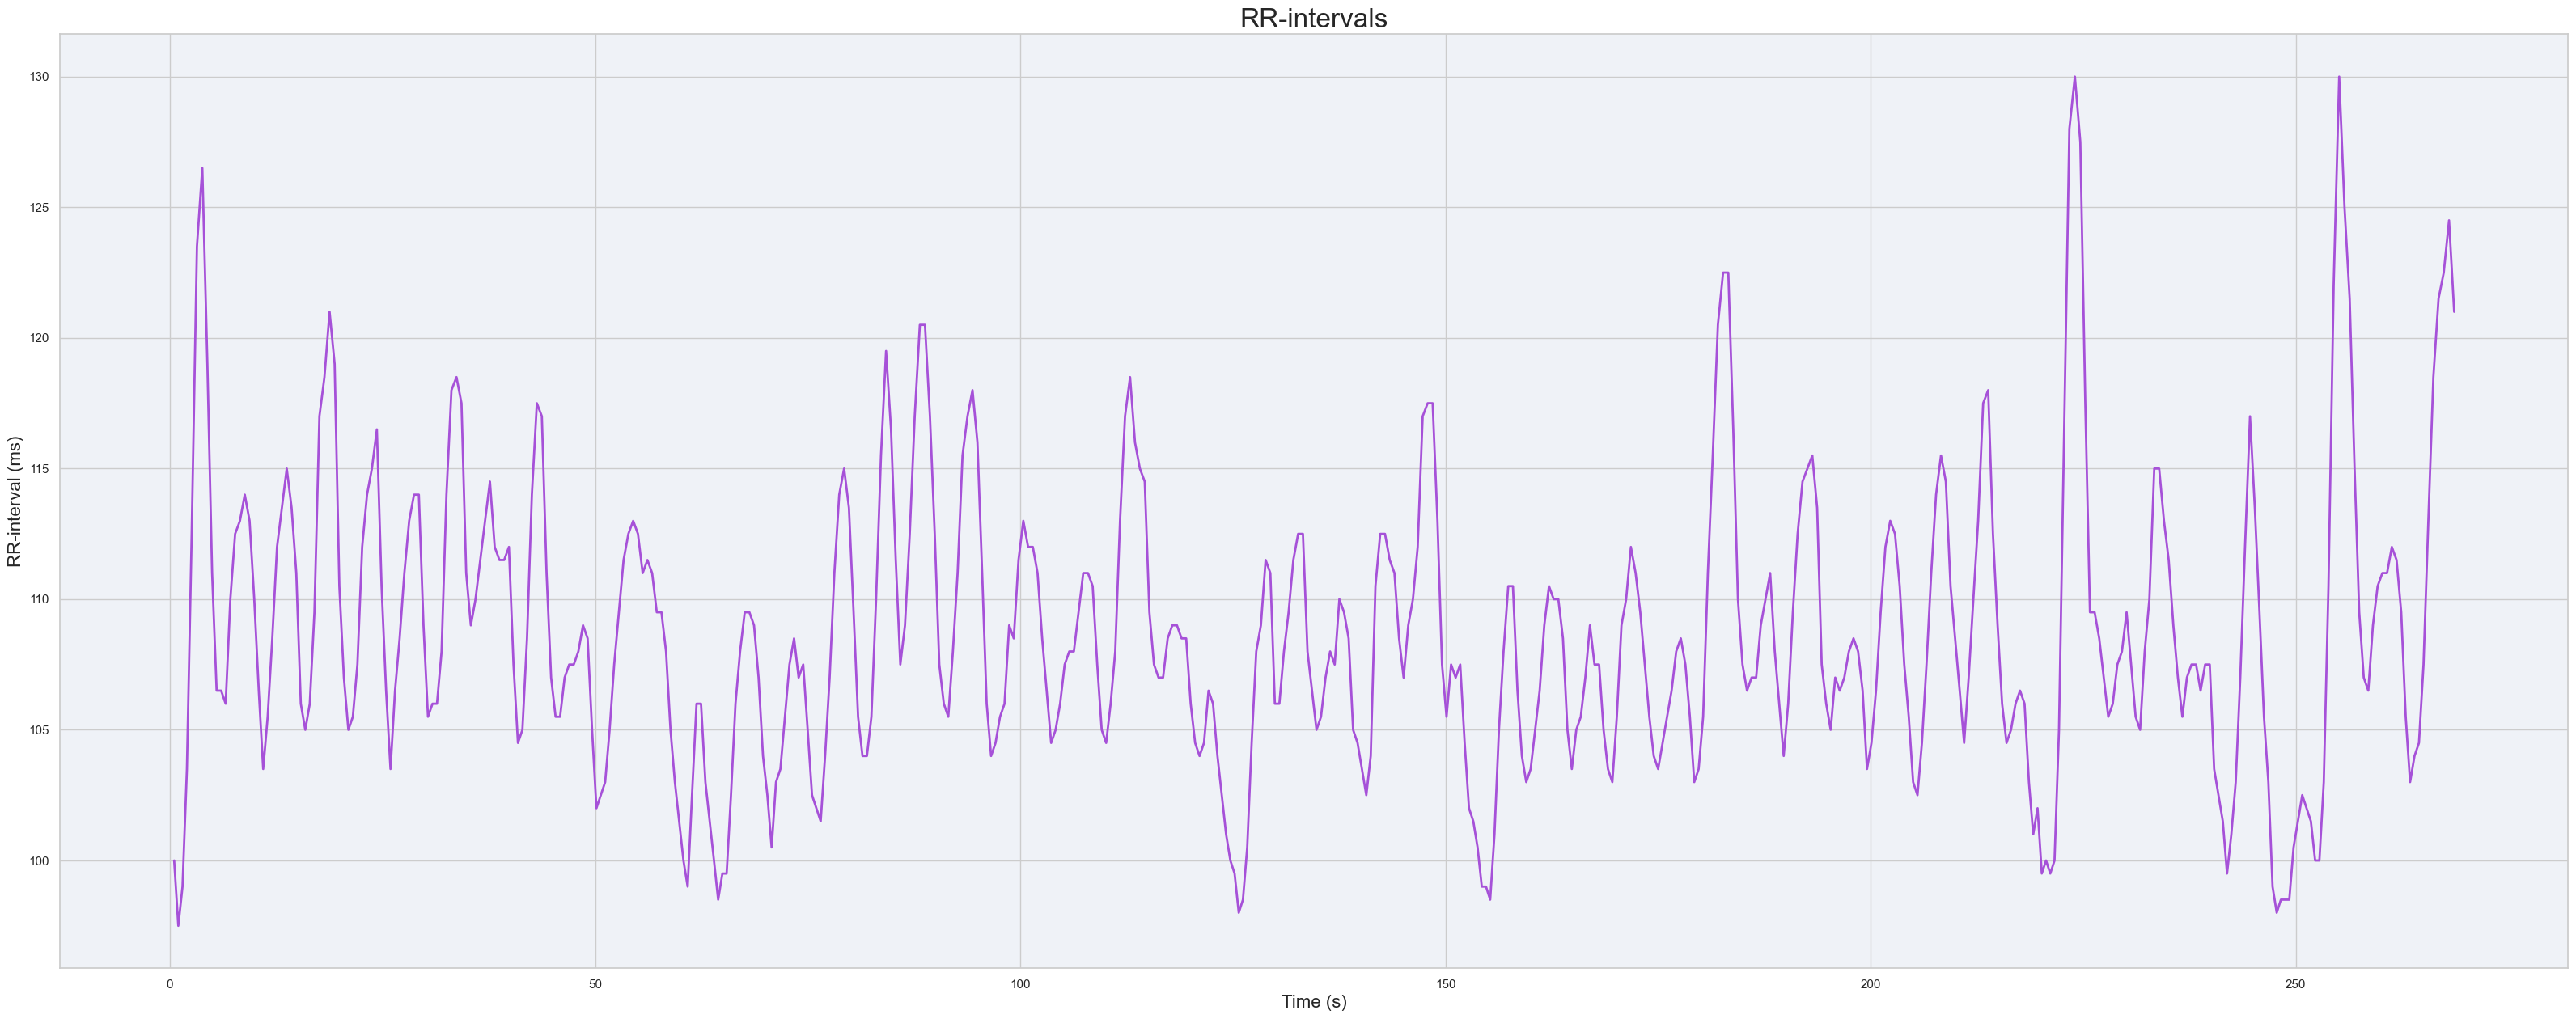

In [18]:
# detect peaks
peaks, similarity = detect_peaks(df['Values'], threshold=TRESHOLD)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

# plot RR-intervals
plt.figure(figsize=(40, 15))
plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(np.cumsum(rr) / settings['fs'], rr, label="RR-interval", color="#A651D8", linewidth=2)

# Artifact removal

C:\Users\Ignacy\AppData\Local\Temp\ipykernel_14332\3694310.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)


[]

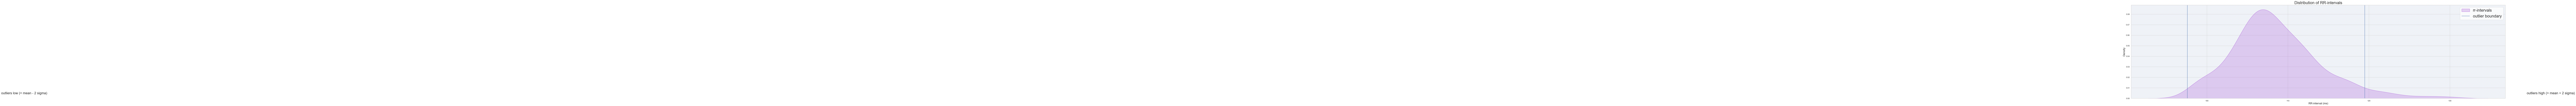

In [14]:
plt.figure(figsize=(40, 10))
plt.title("Distribution of RR-intervals", fontsize=24)
sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr)-2 * np.std(rr)
outlier_high = np.mean(rr)+2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 270, 0.004, "outliers low (< mean - 2 sigma)", fontsize=20)
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)", fontsize=20)

plt.xlabel("RR-interval (ms)", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.legend(fontsize=24)
plt.plot()

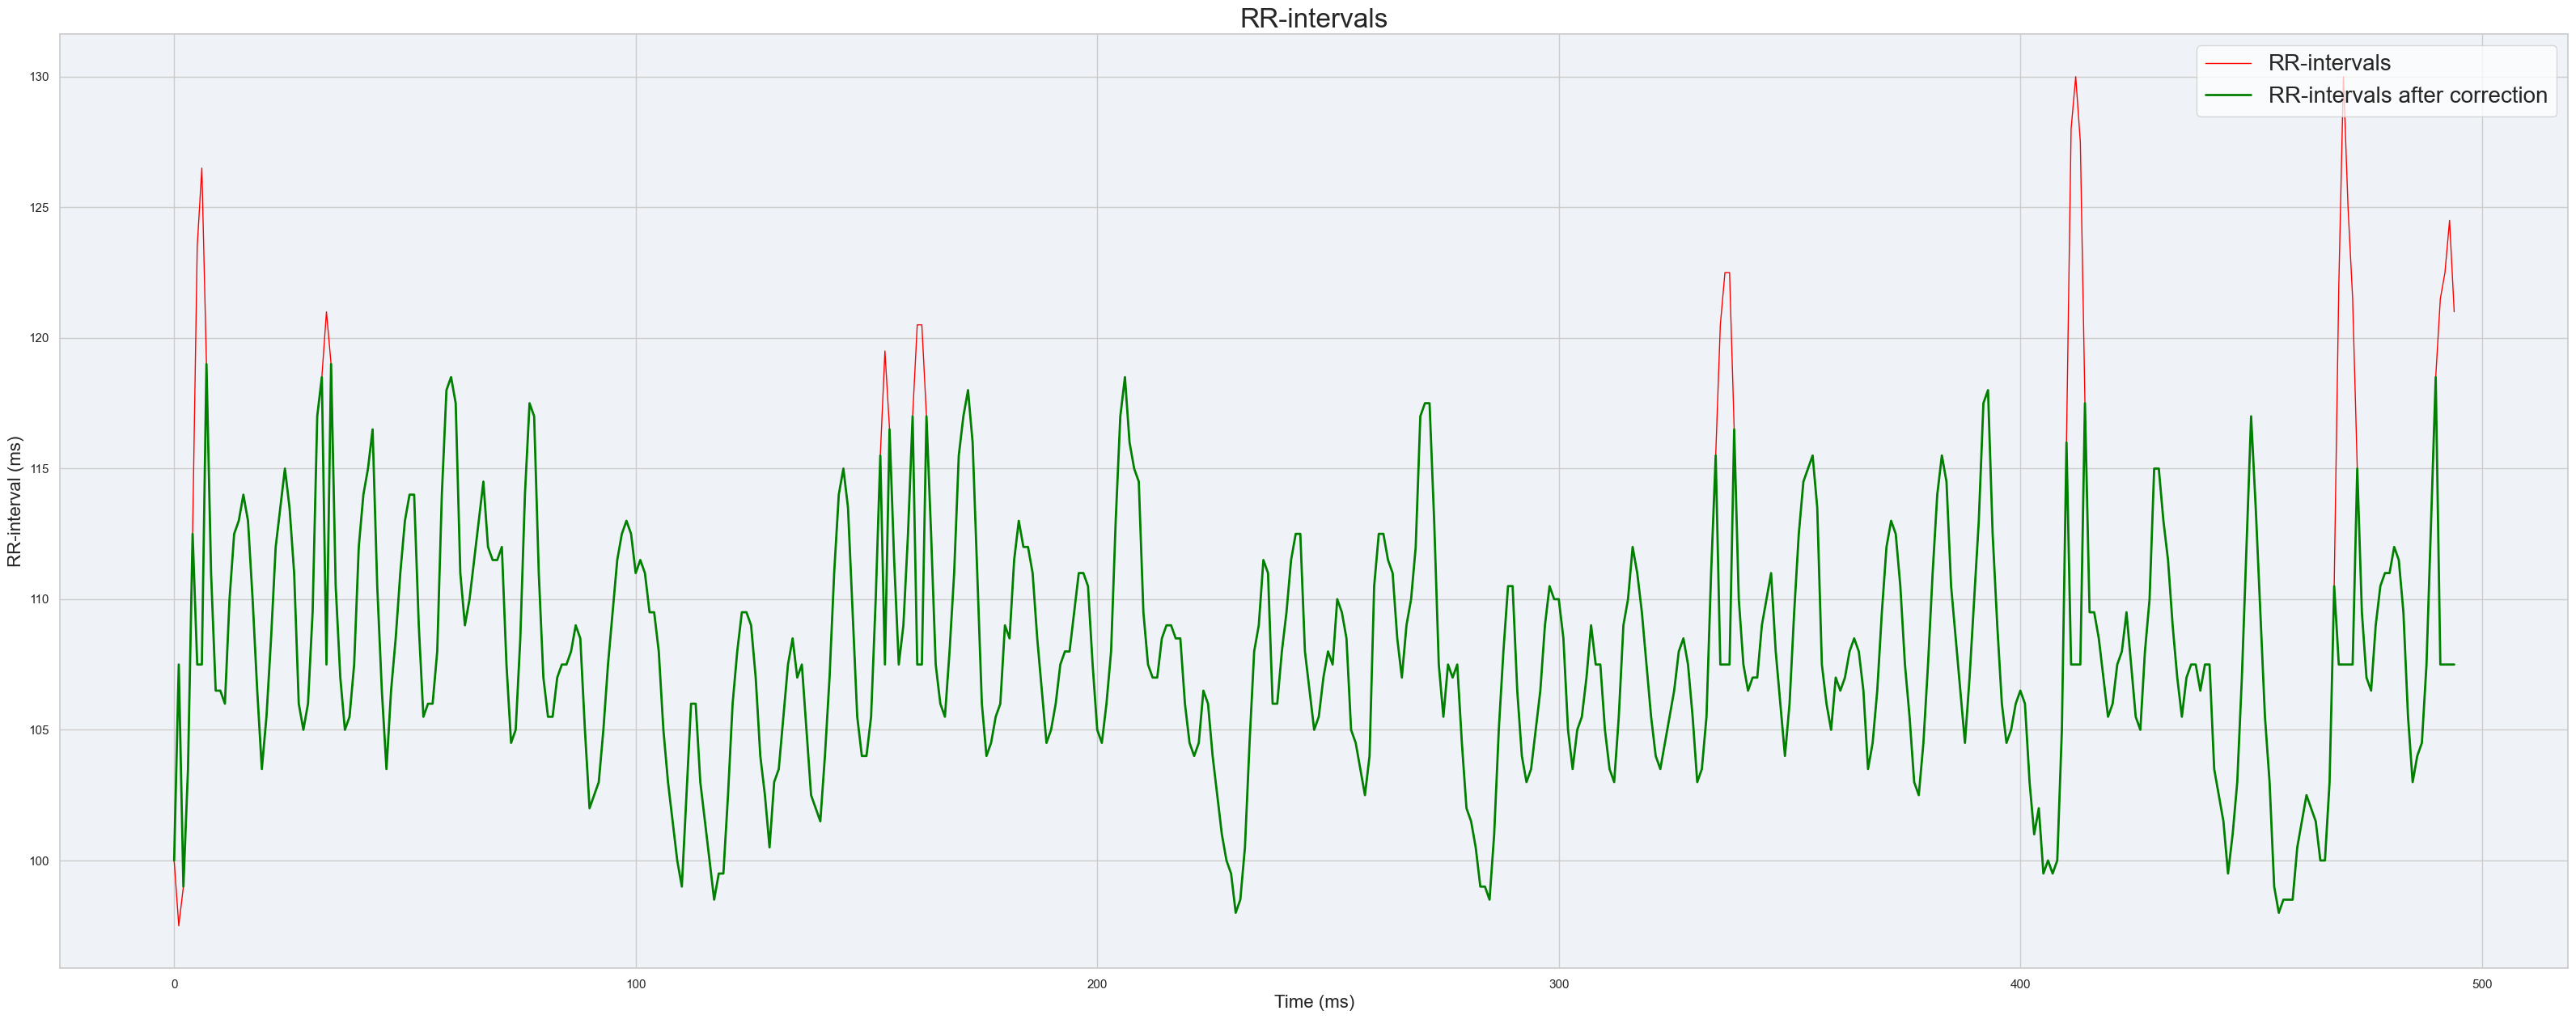

In [15]:
plt.figure(figsize=(40, 15))

cut_rr = rr.copy()
cut_rr = cut_rr#[:-75]

rr_corrected = cut_rr.copy()
rr_corrected[np.abs(zscore(cut_rr)) > 2] = np.median(cut_rr)


plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(cut_rr, color="red", linewidth=1, label="RR-intervals")
plt.plot(rr_corrected, color="green", linewidth=2, label="RR-intervals after correction")
plt.legend(fontsize=20)

# Plot ABP vs RR intervals

DC: 13.48
AC: -14.14


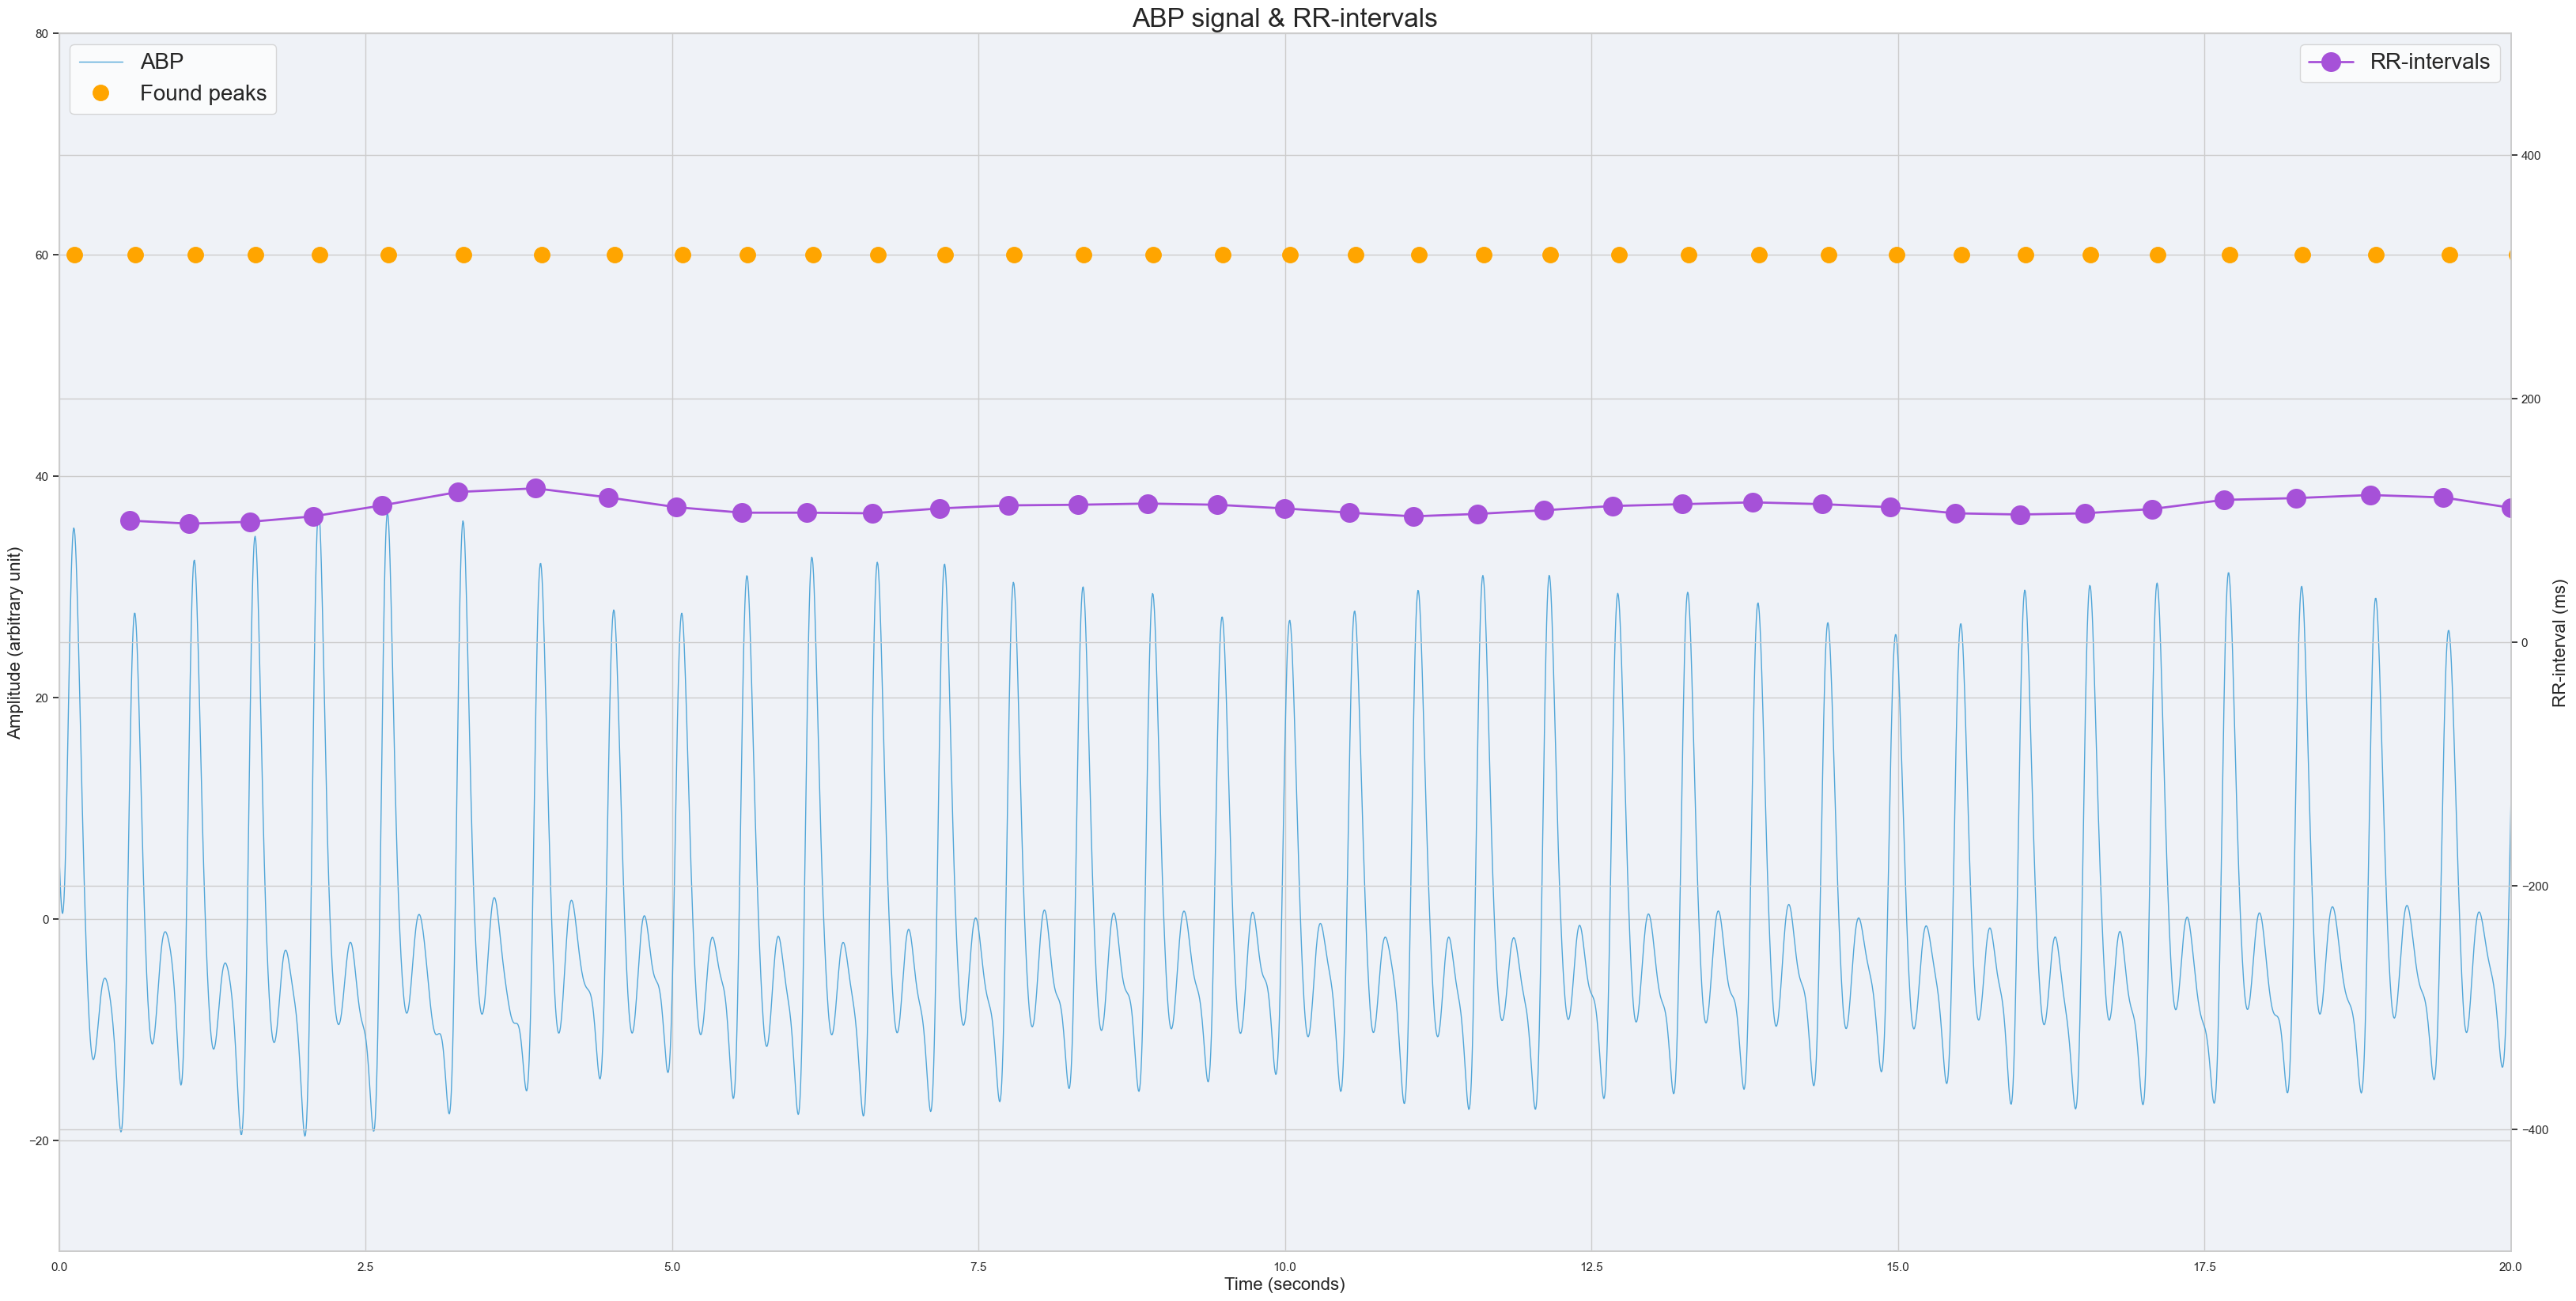

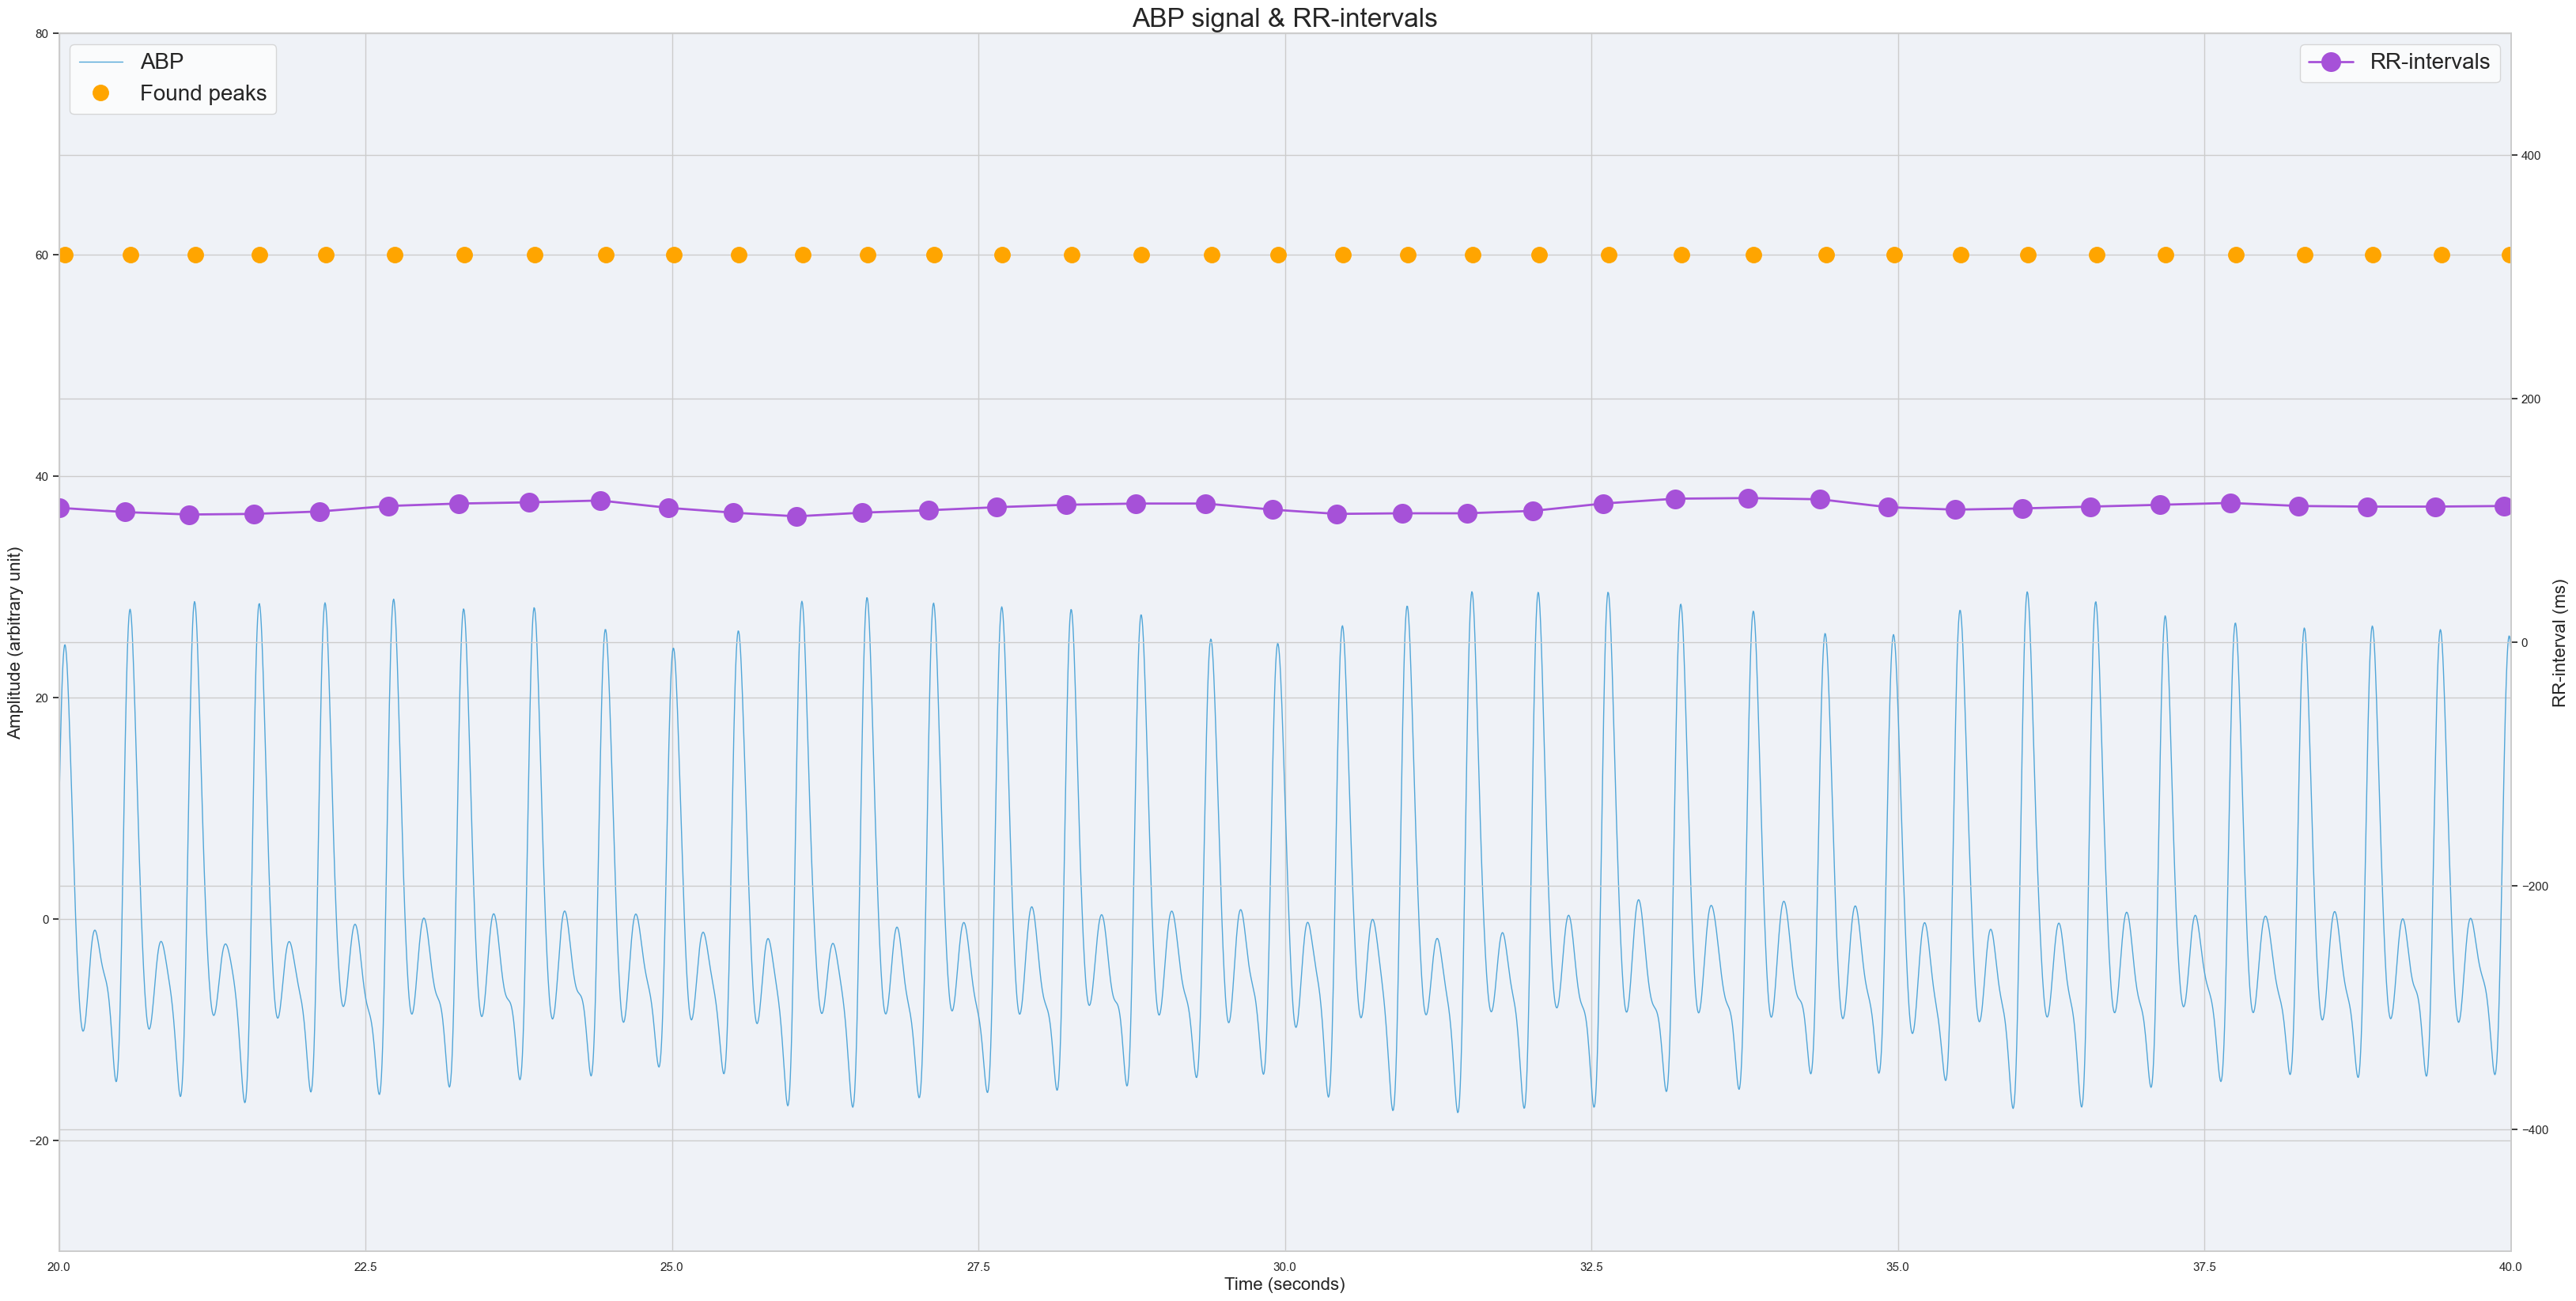

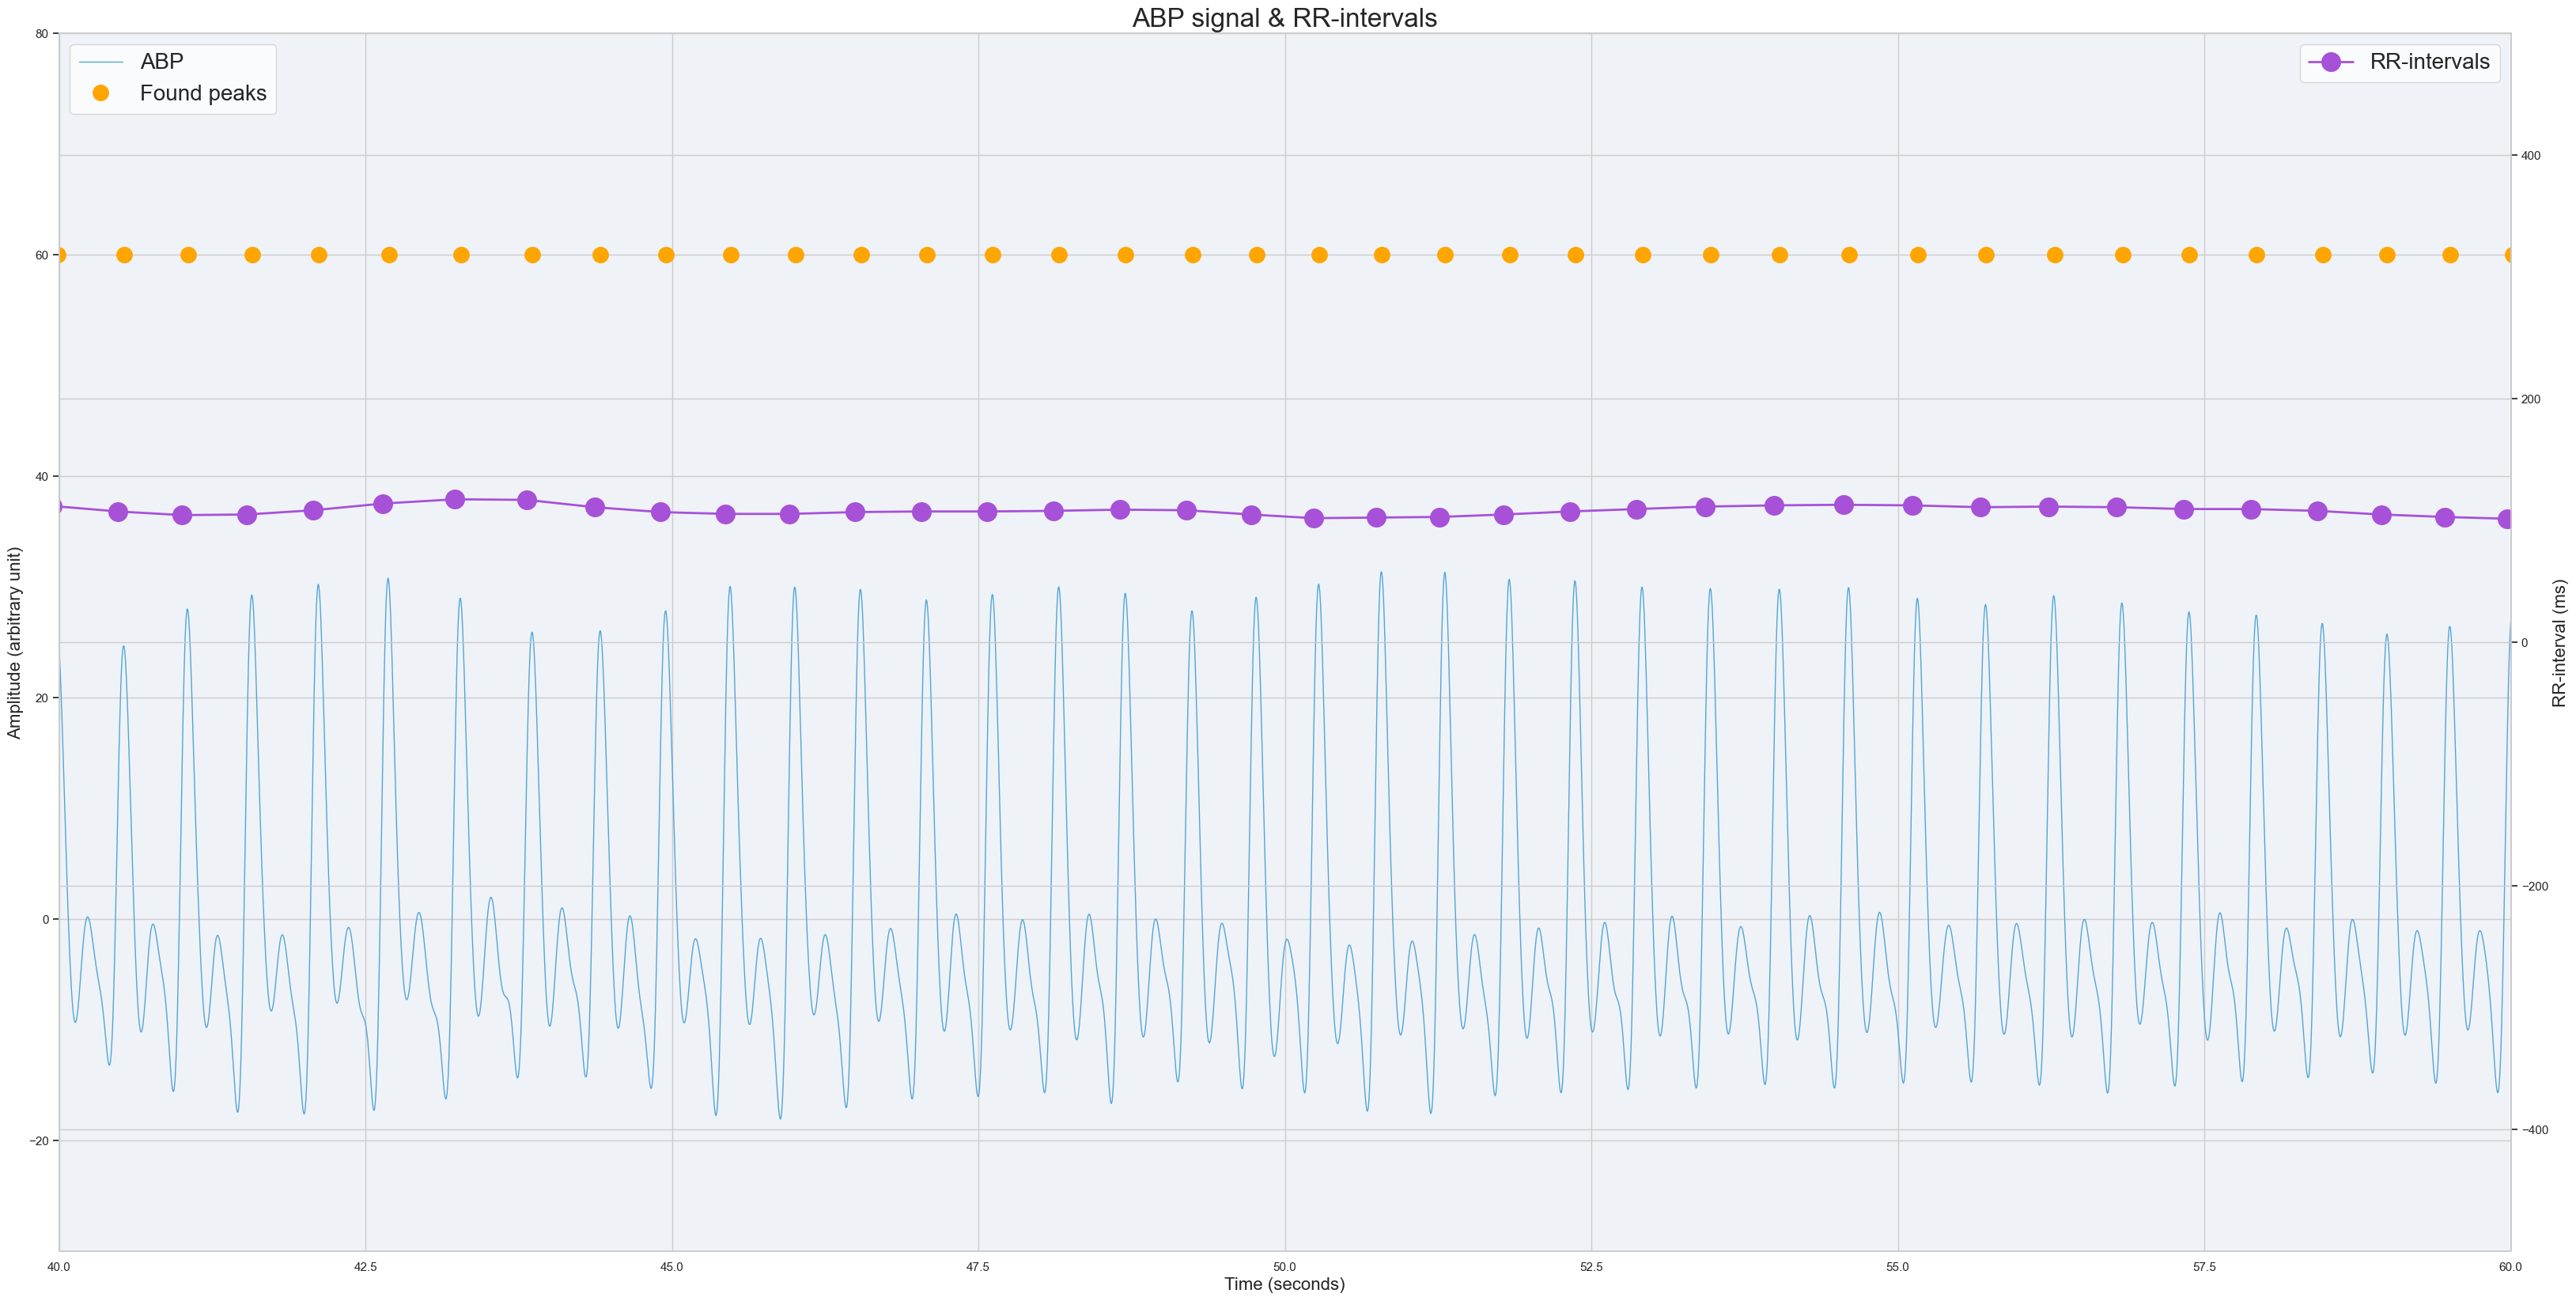

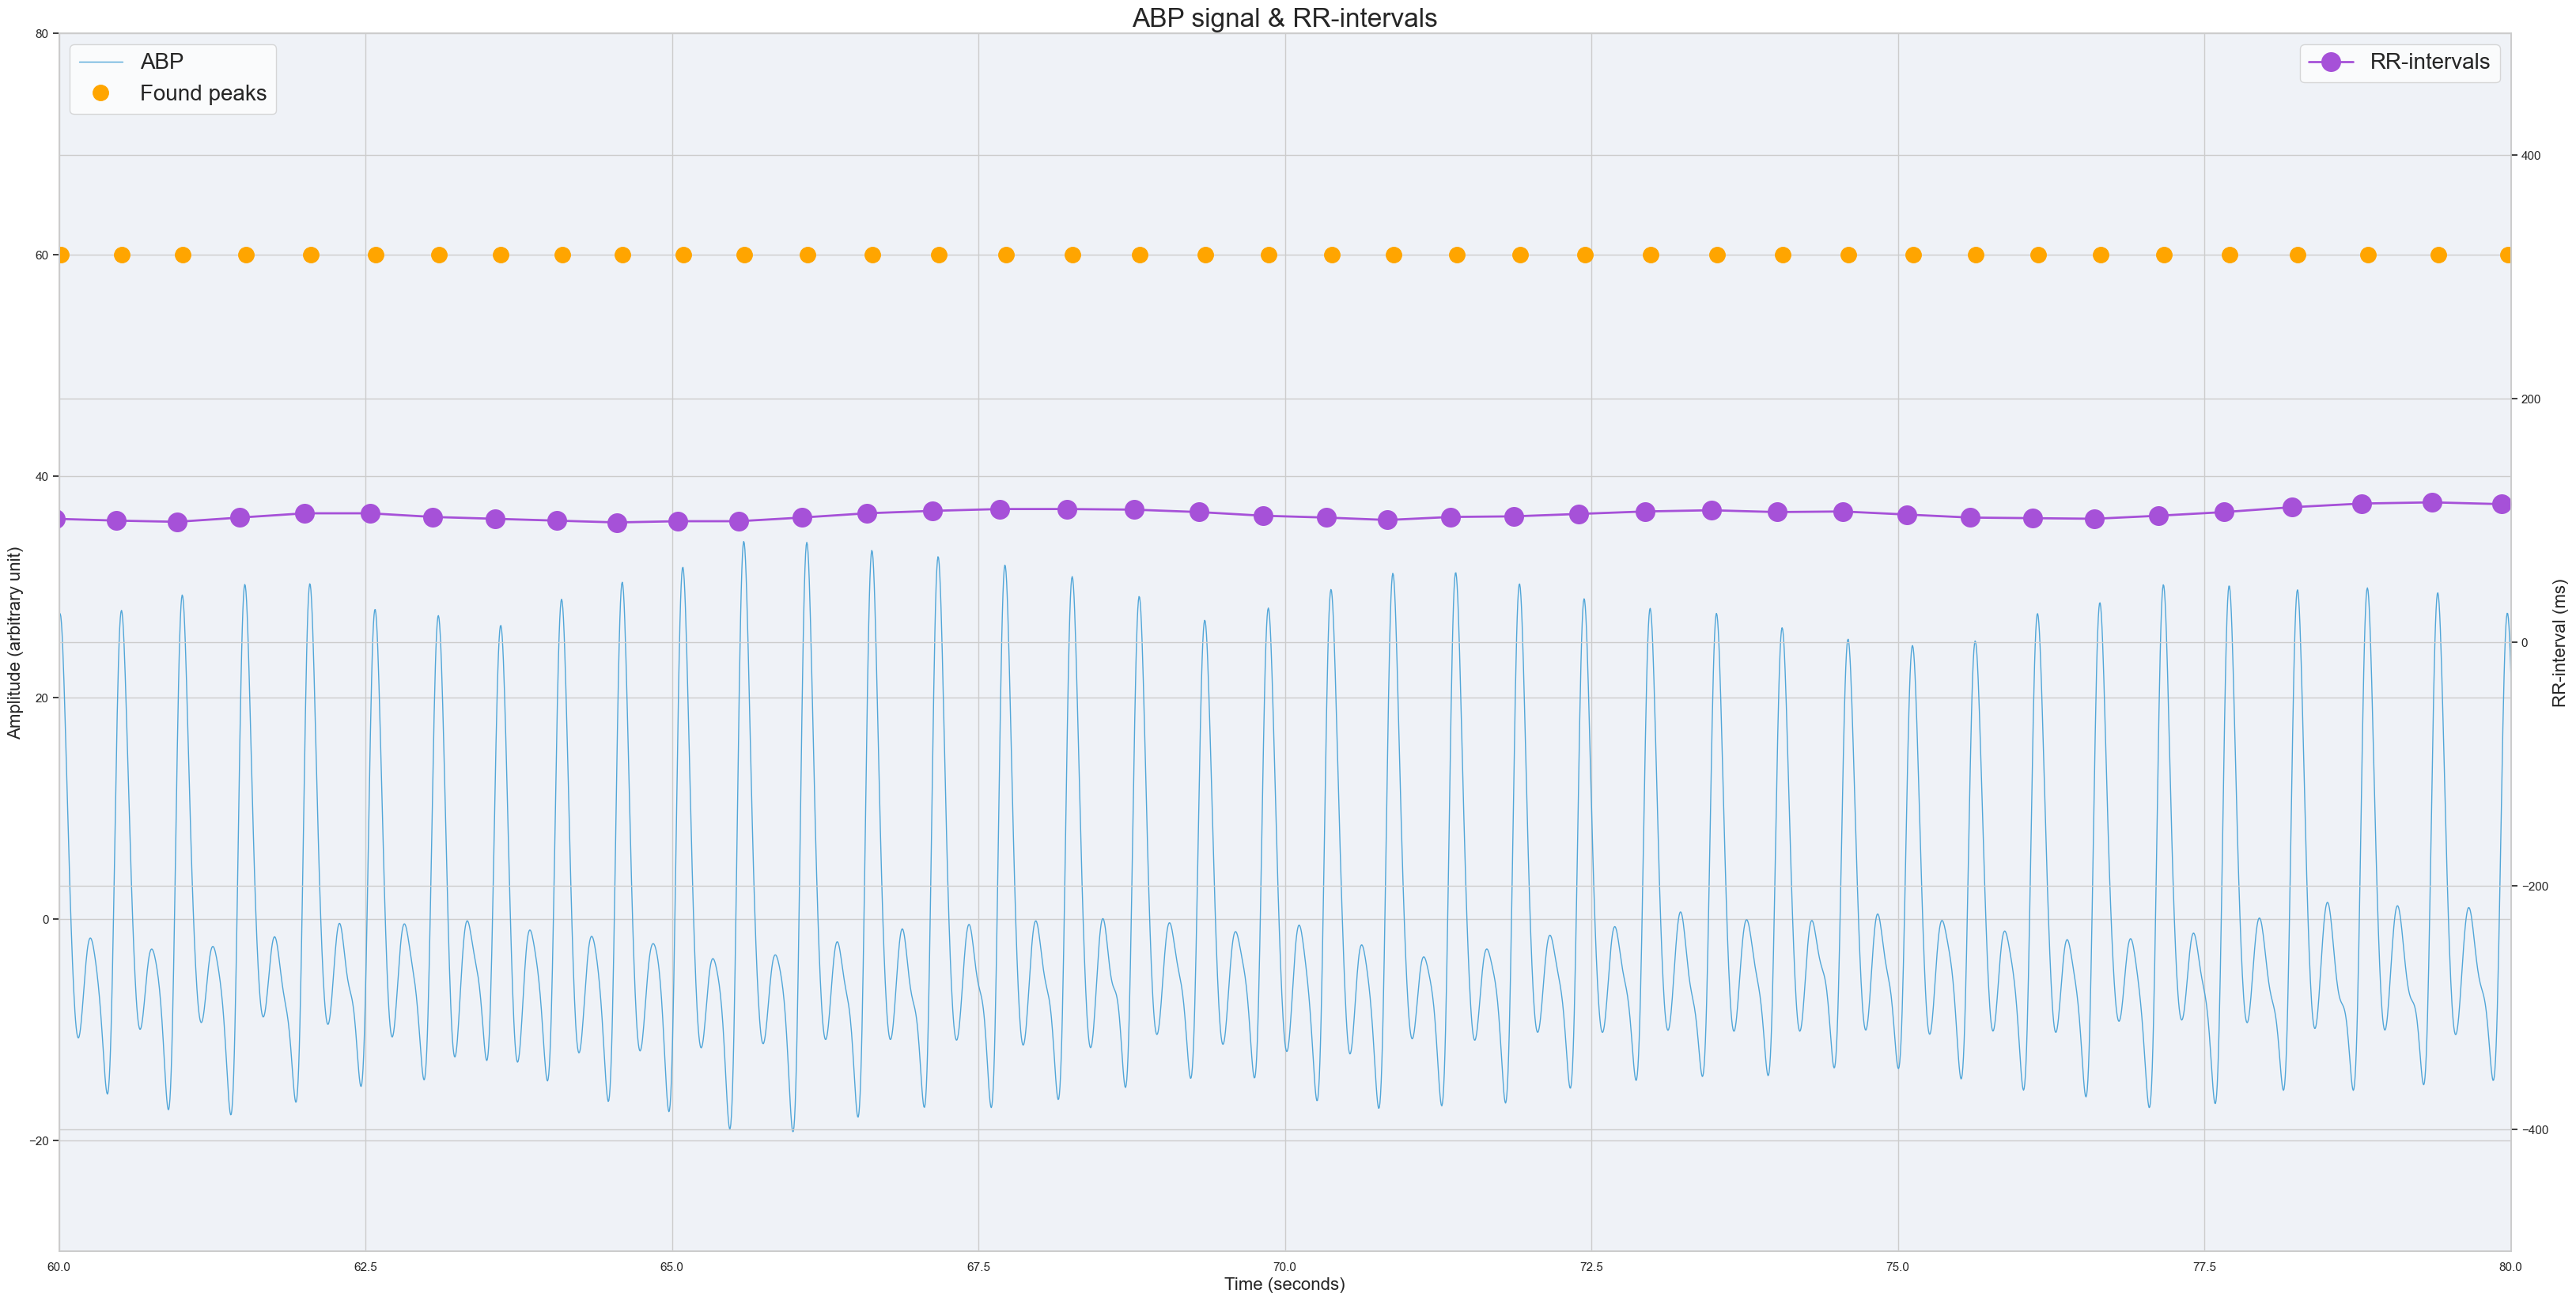

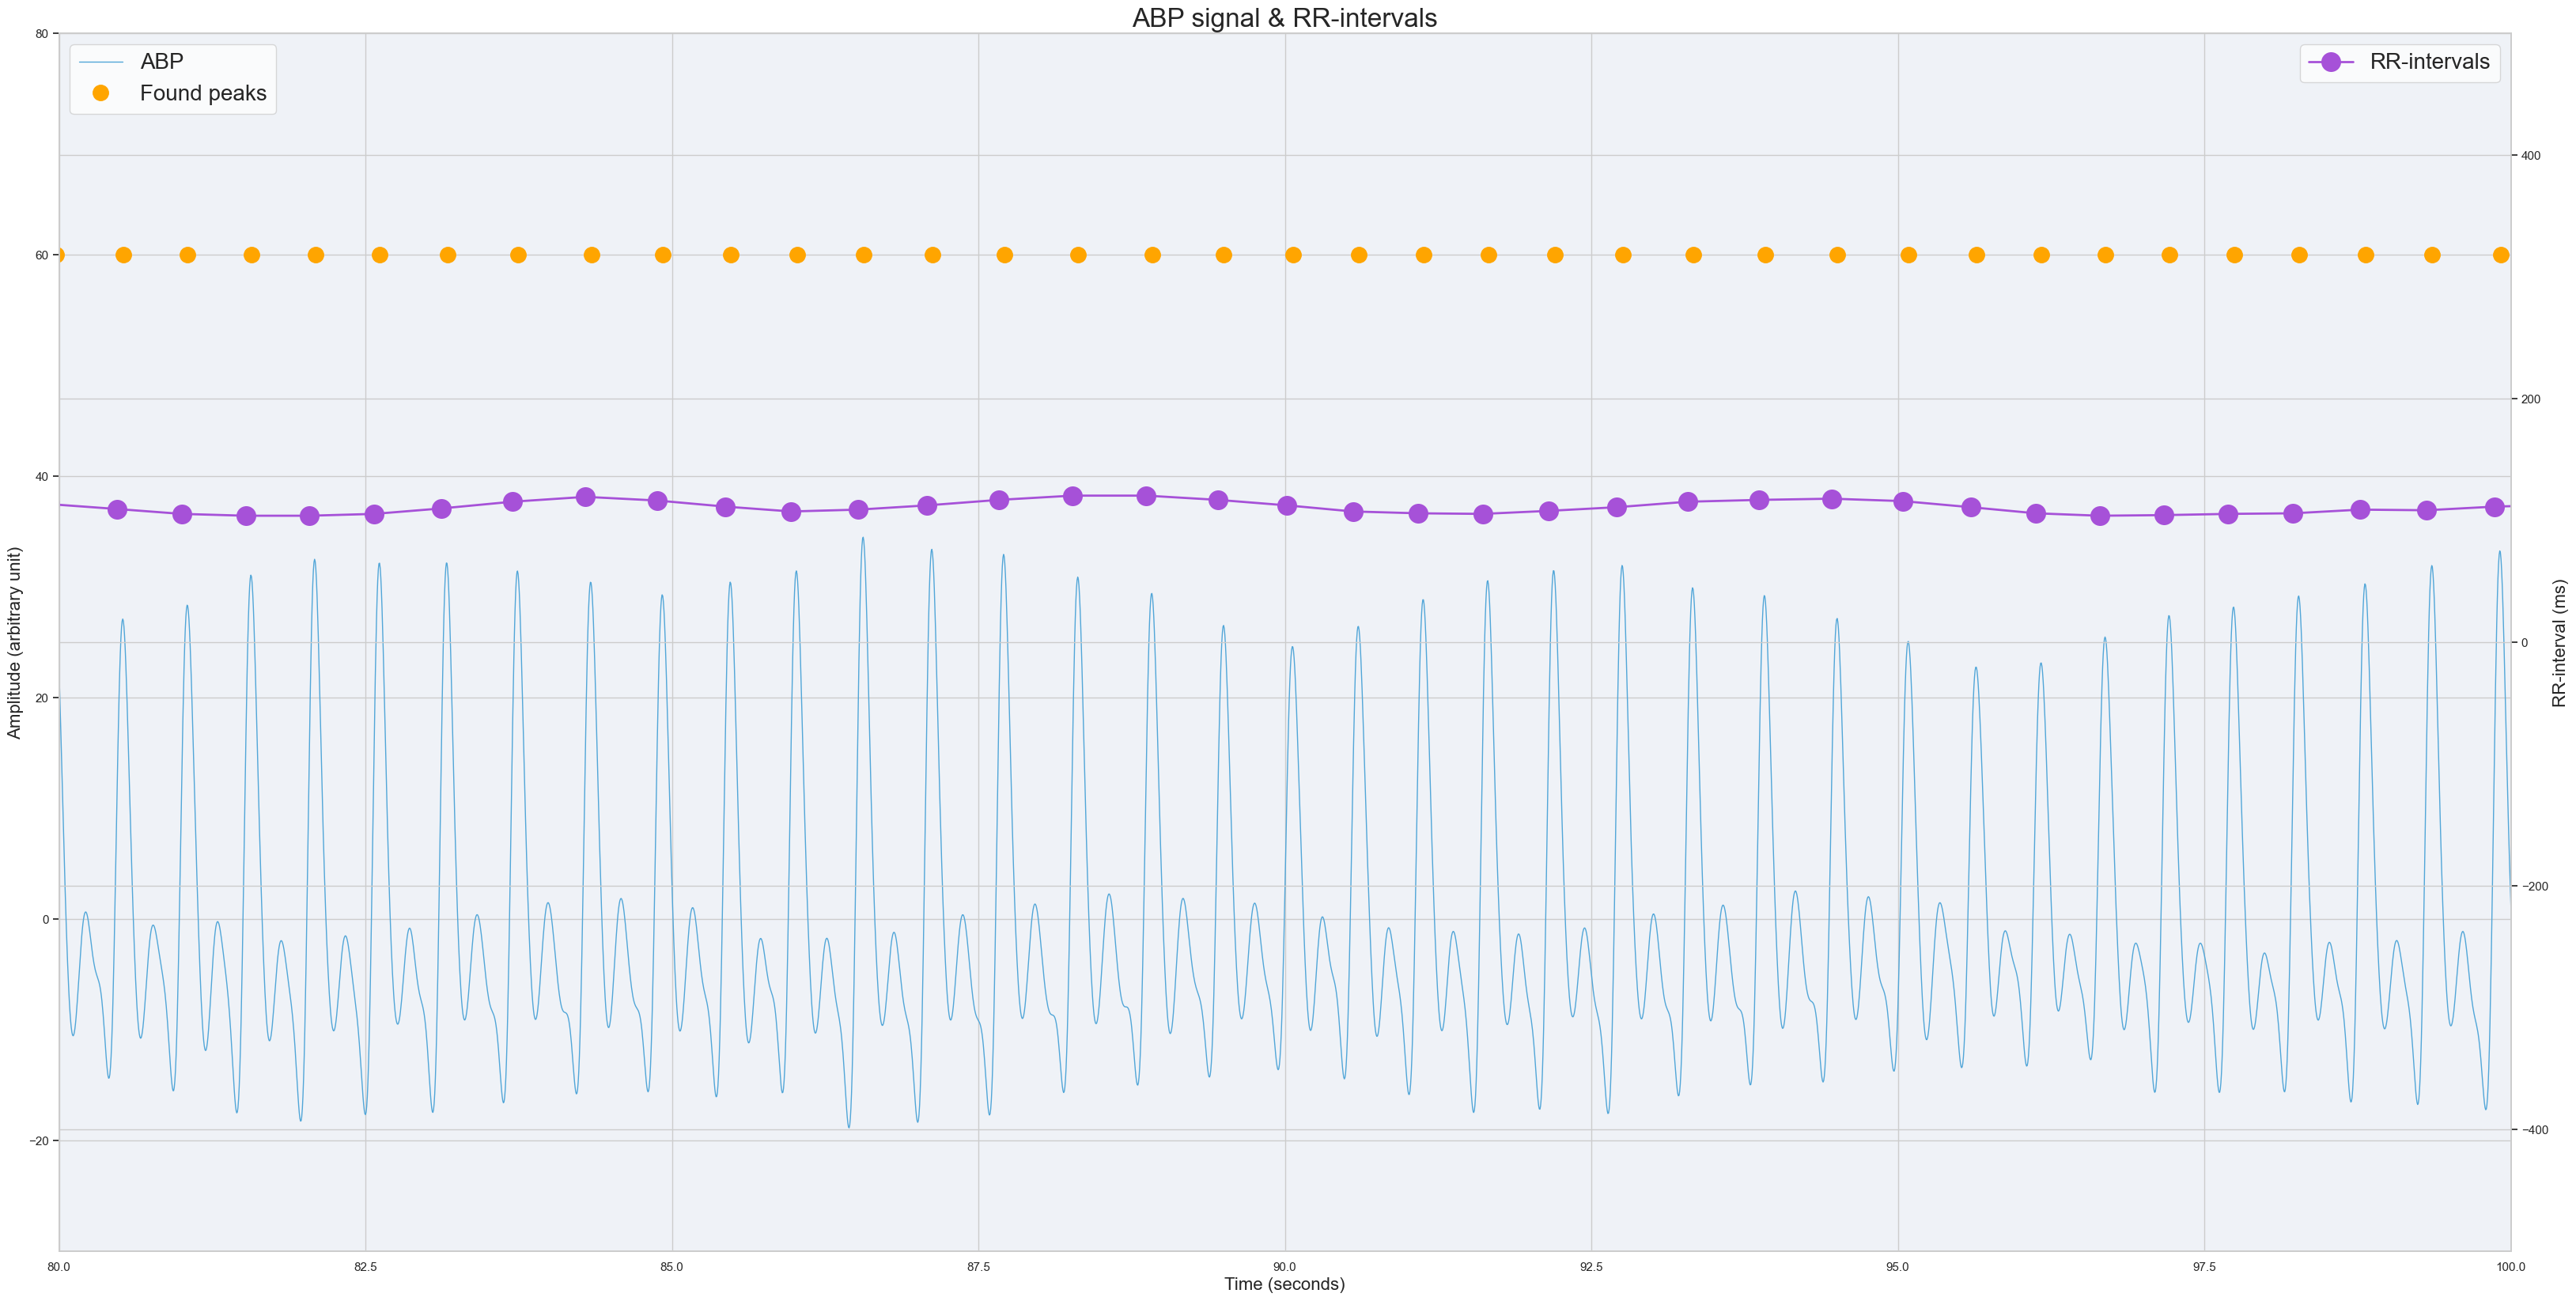

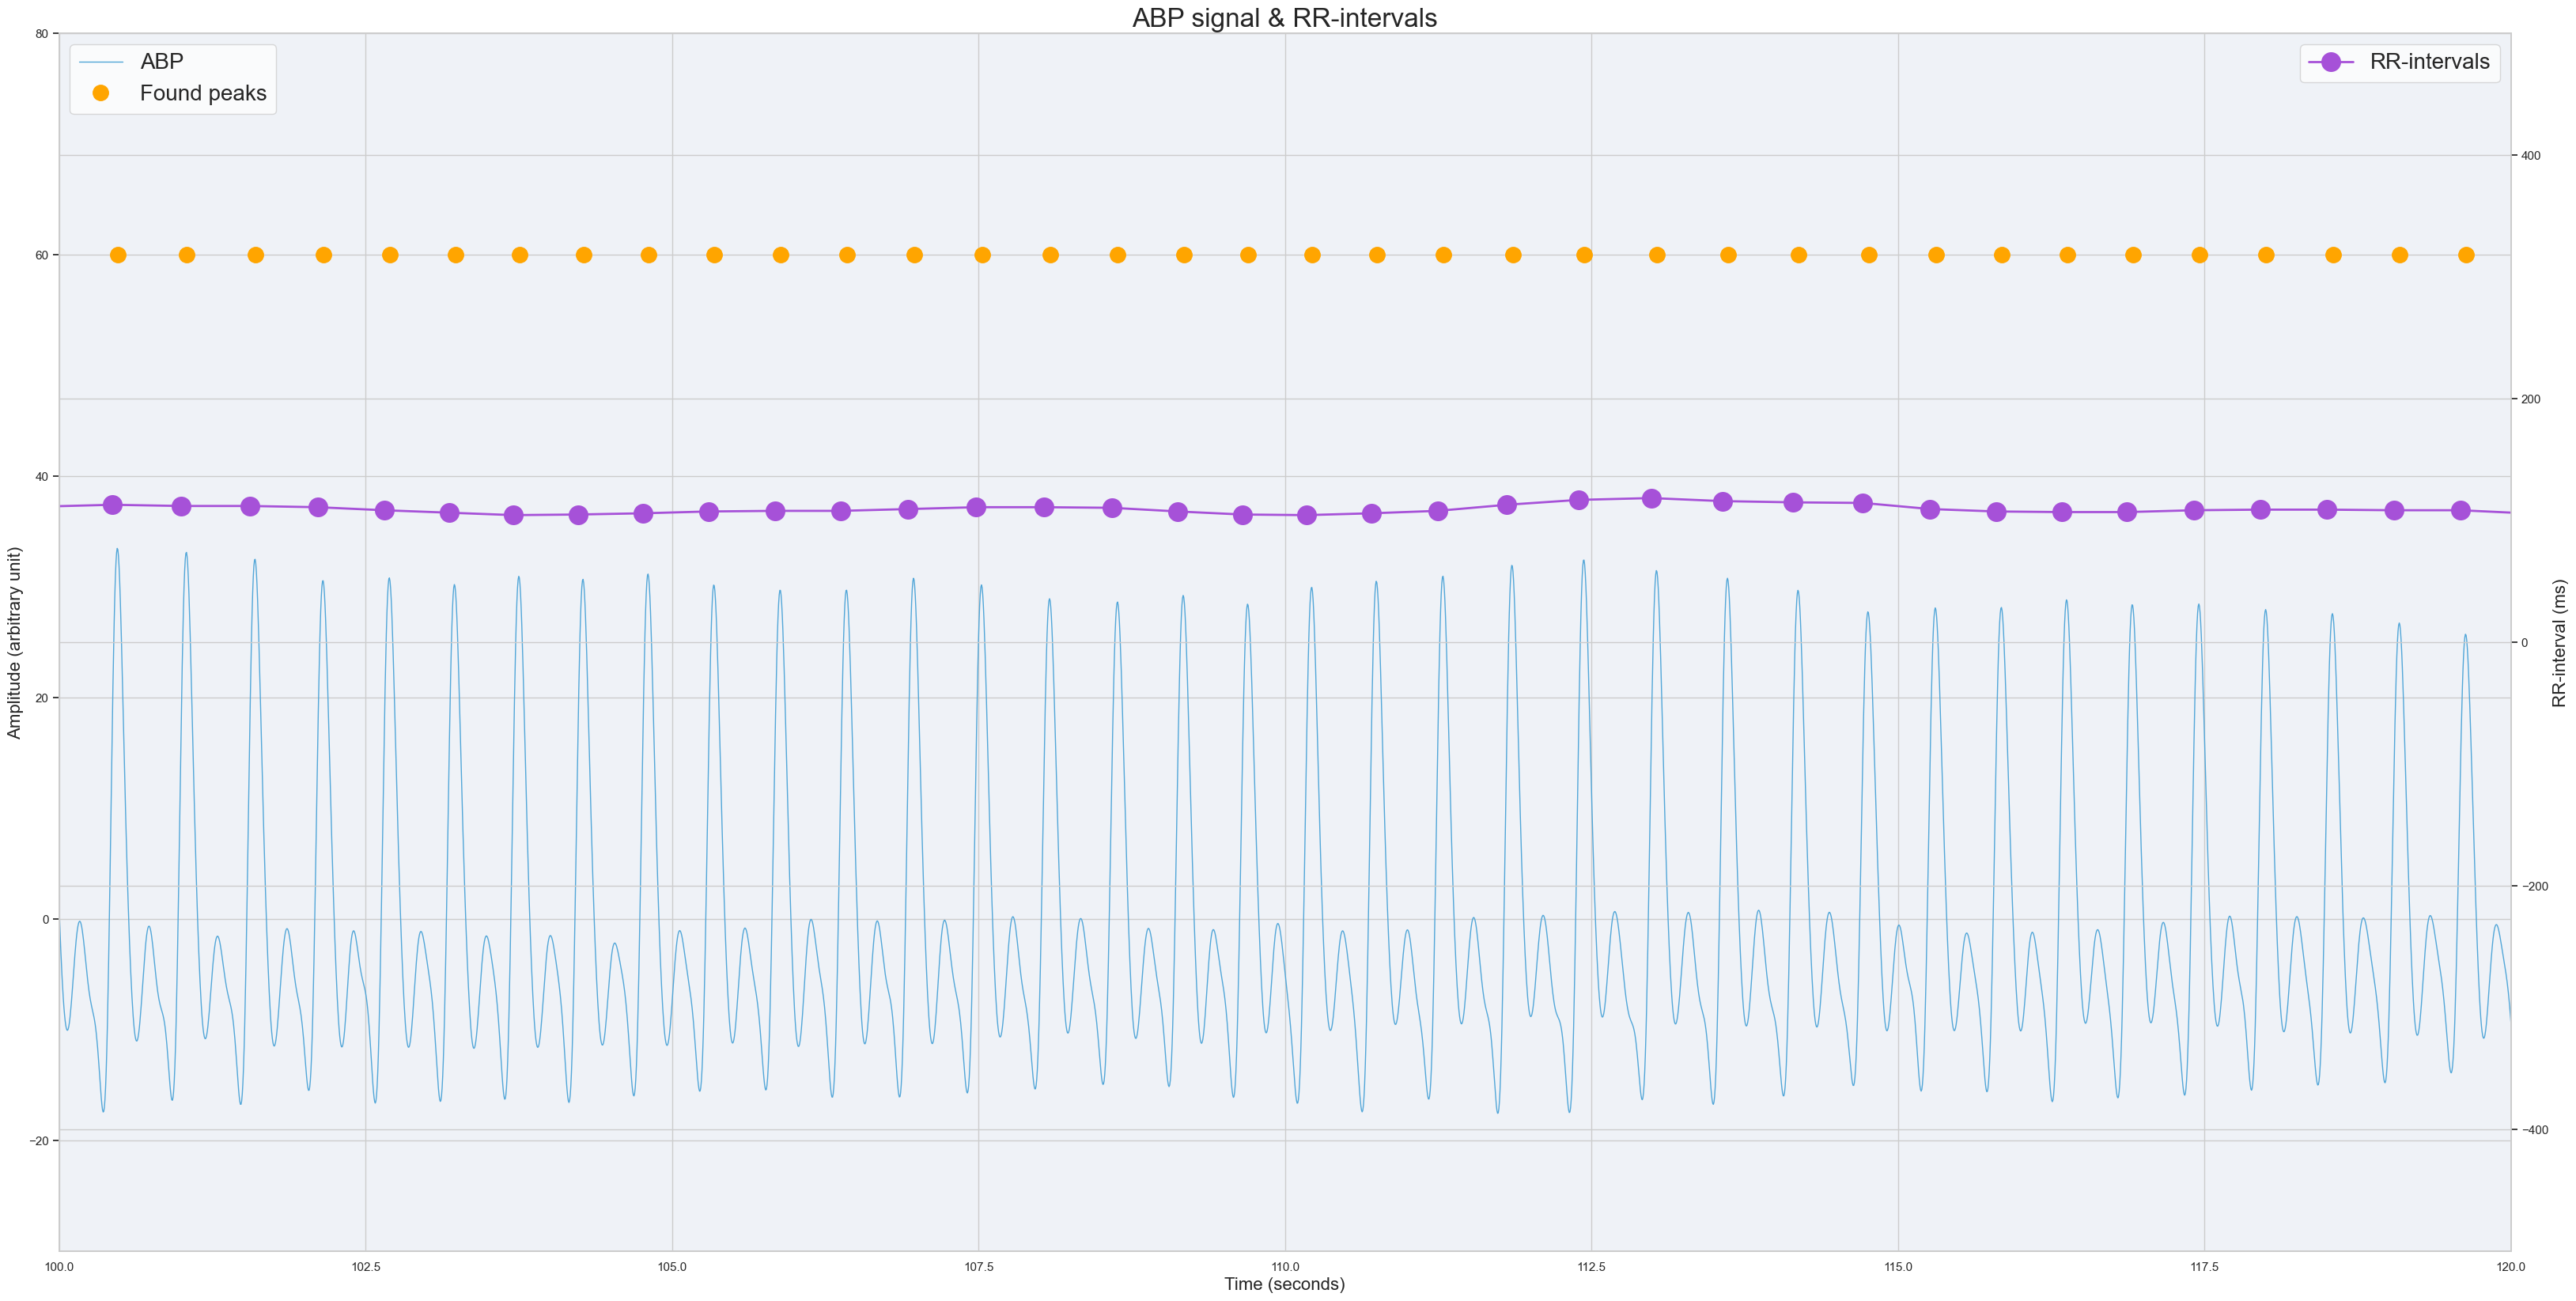

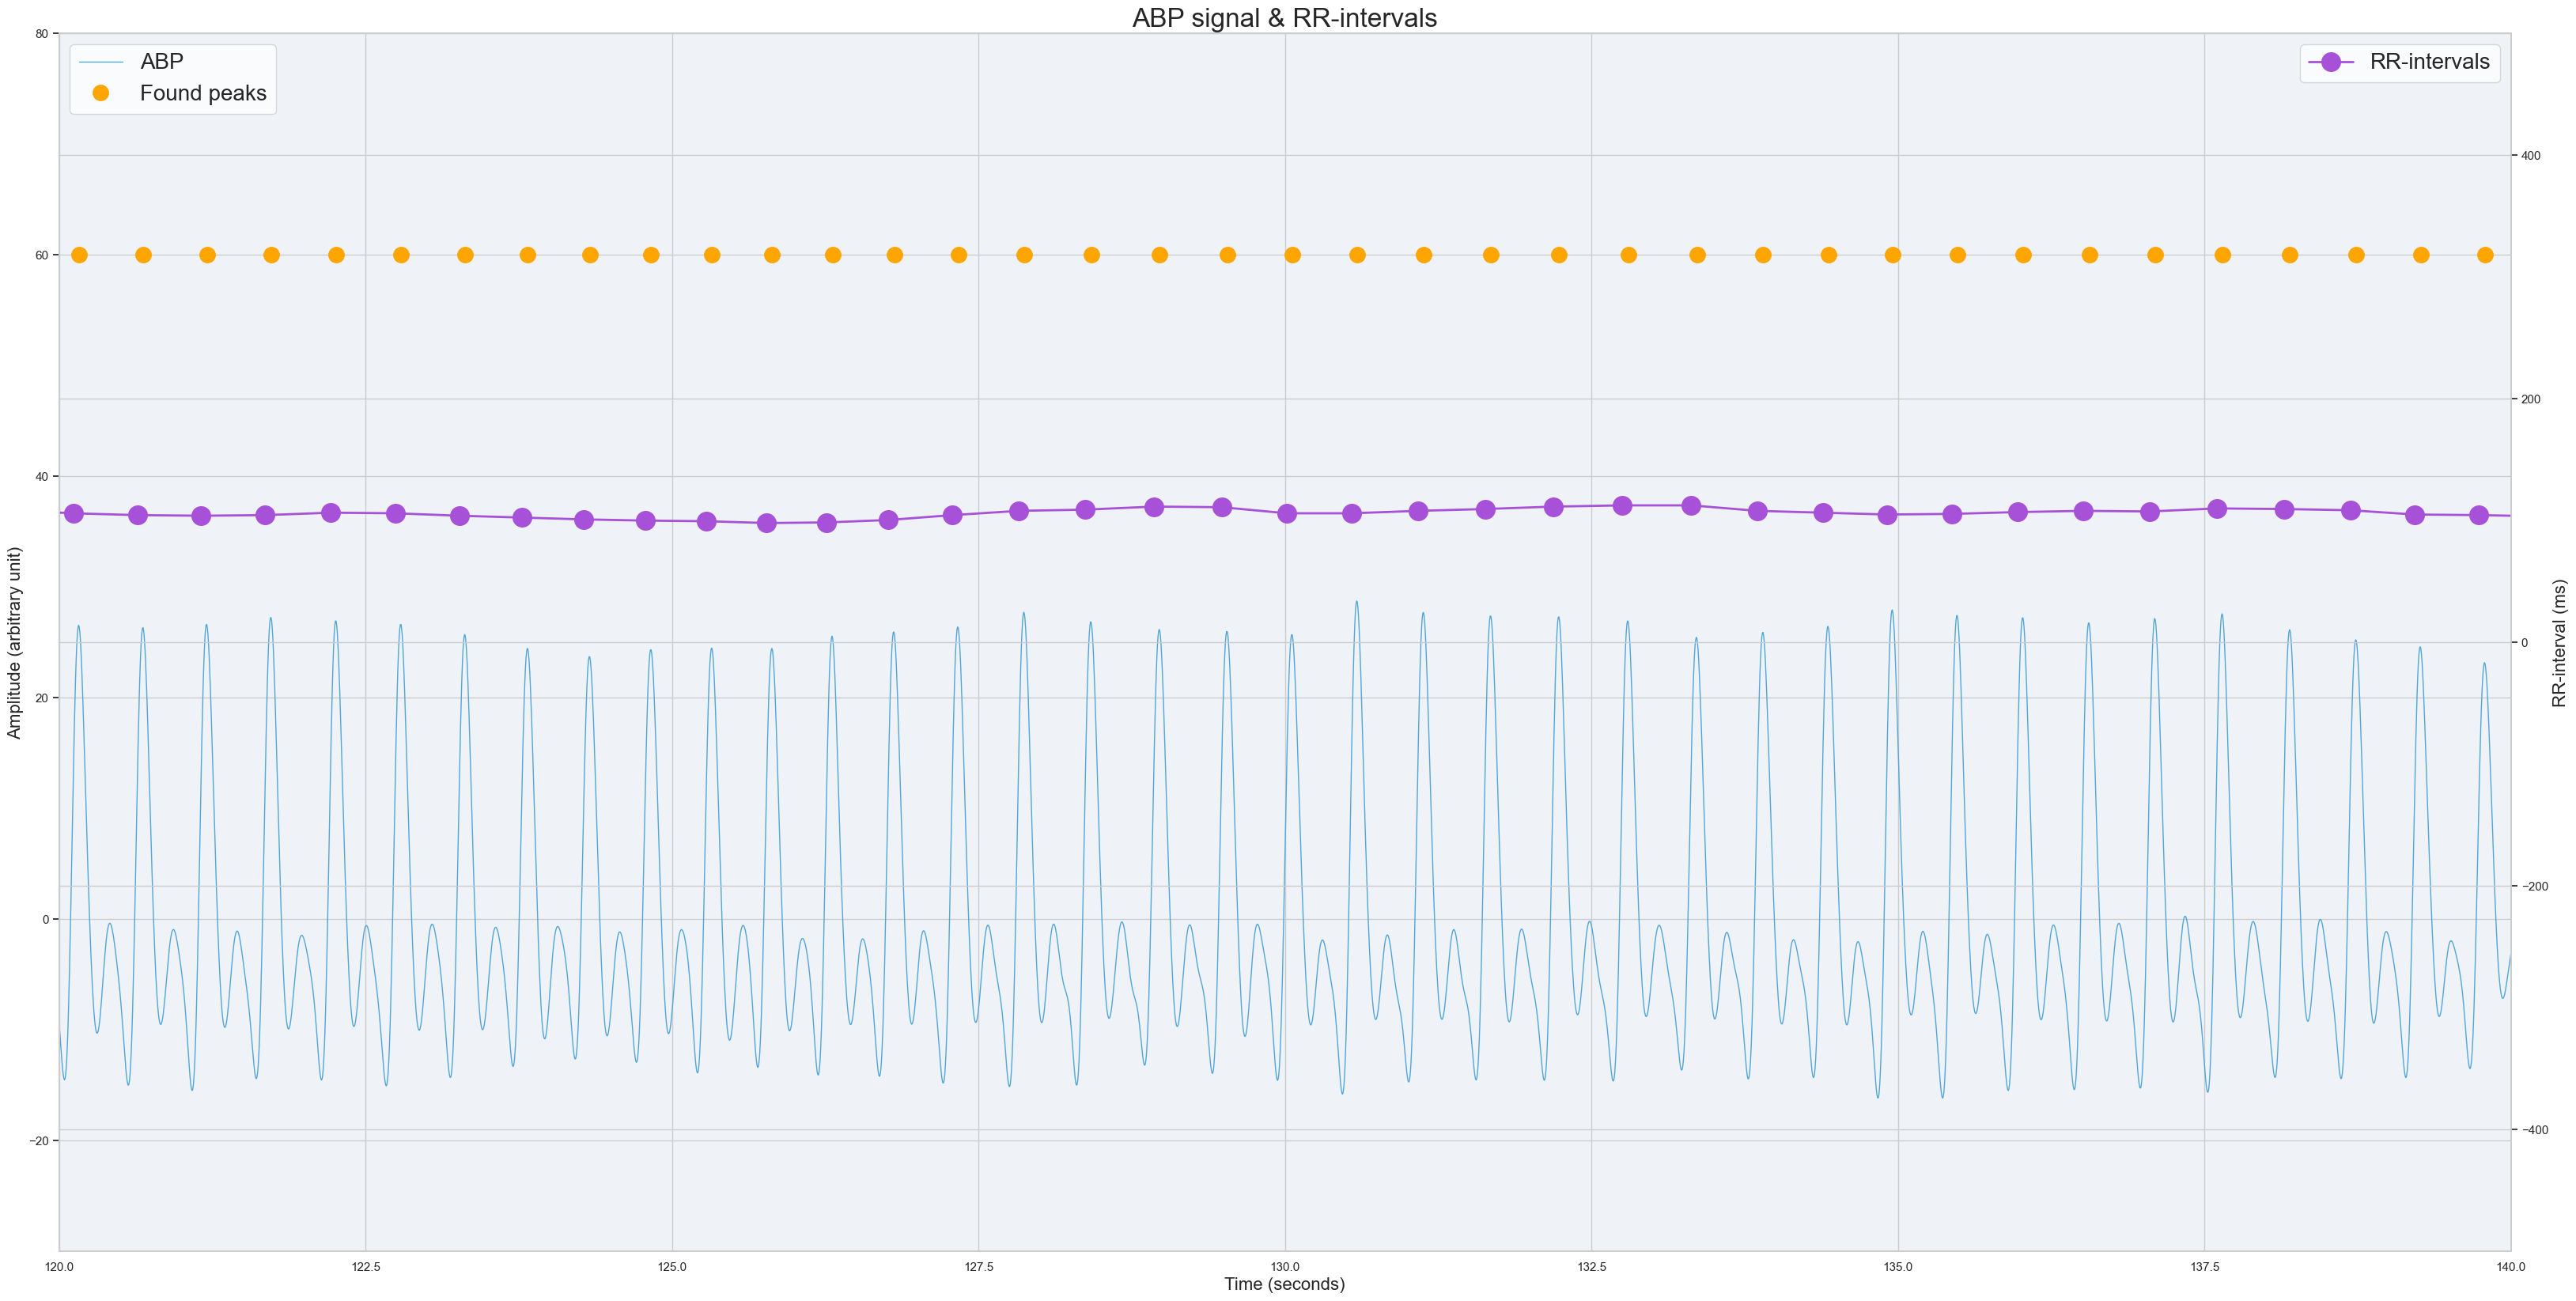

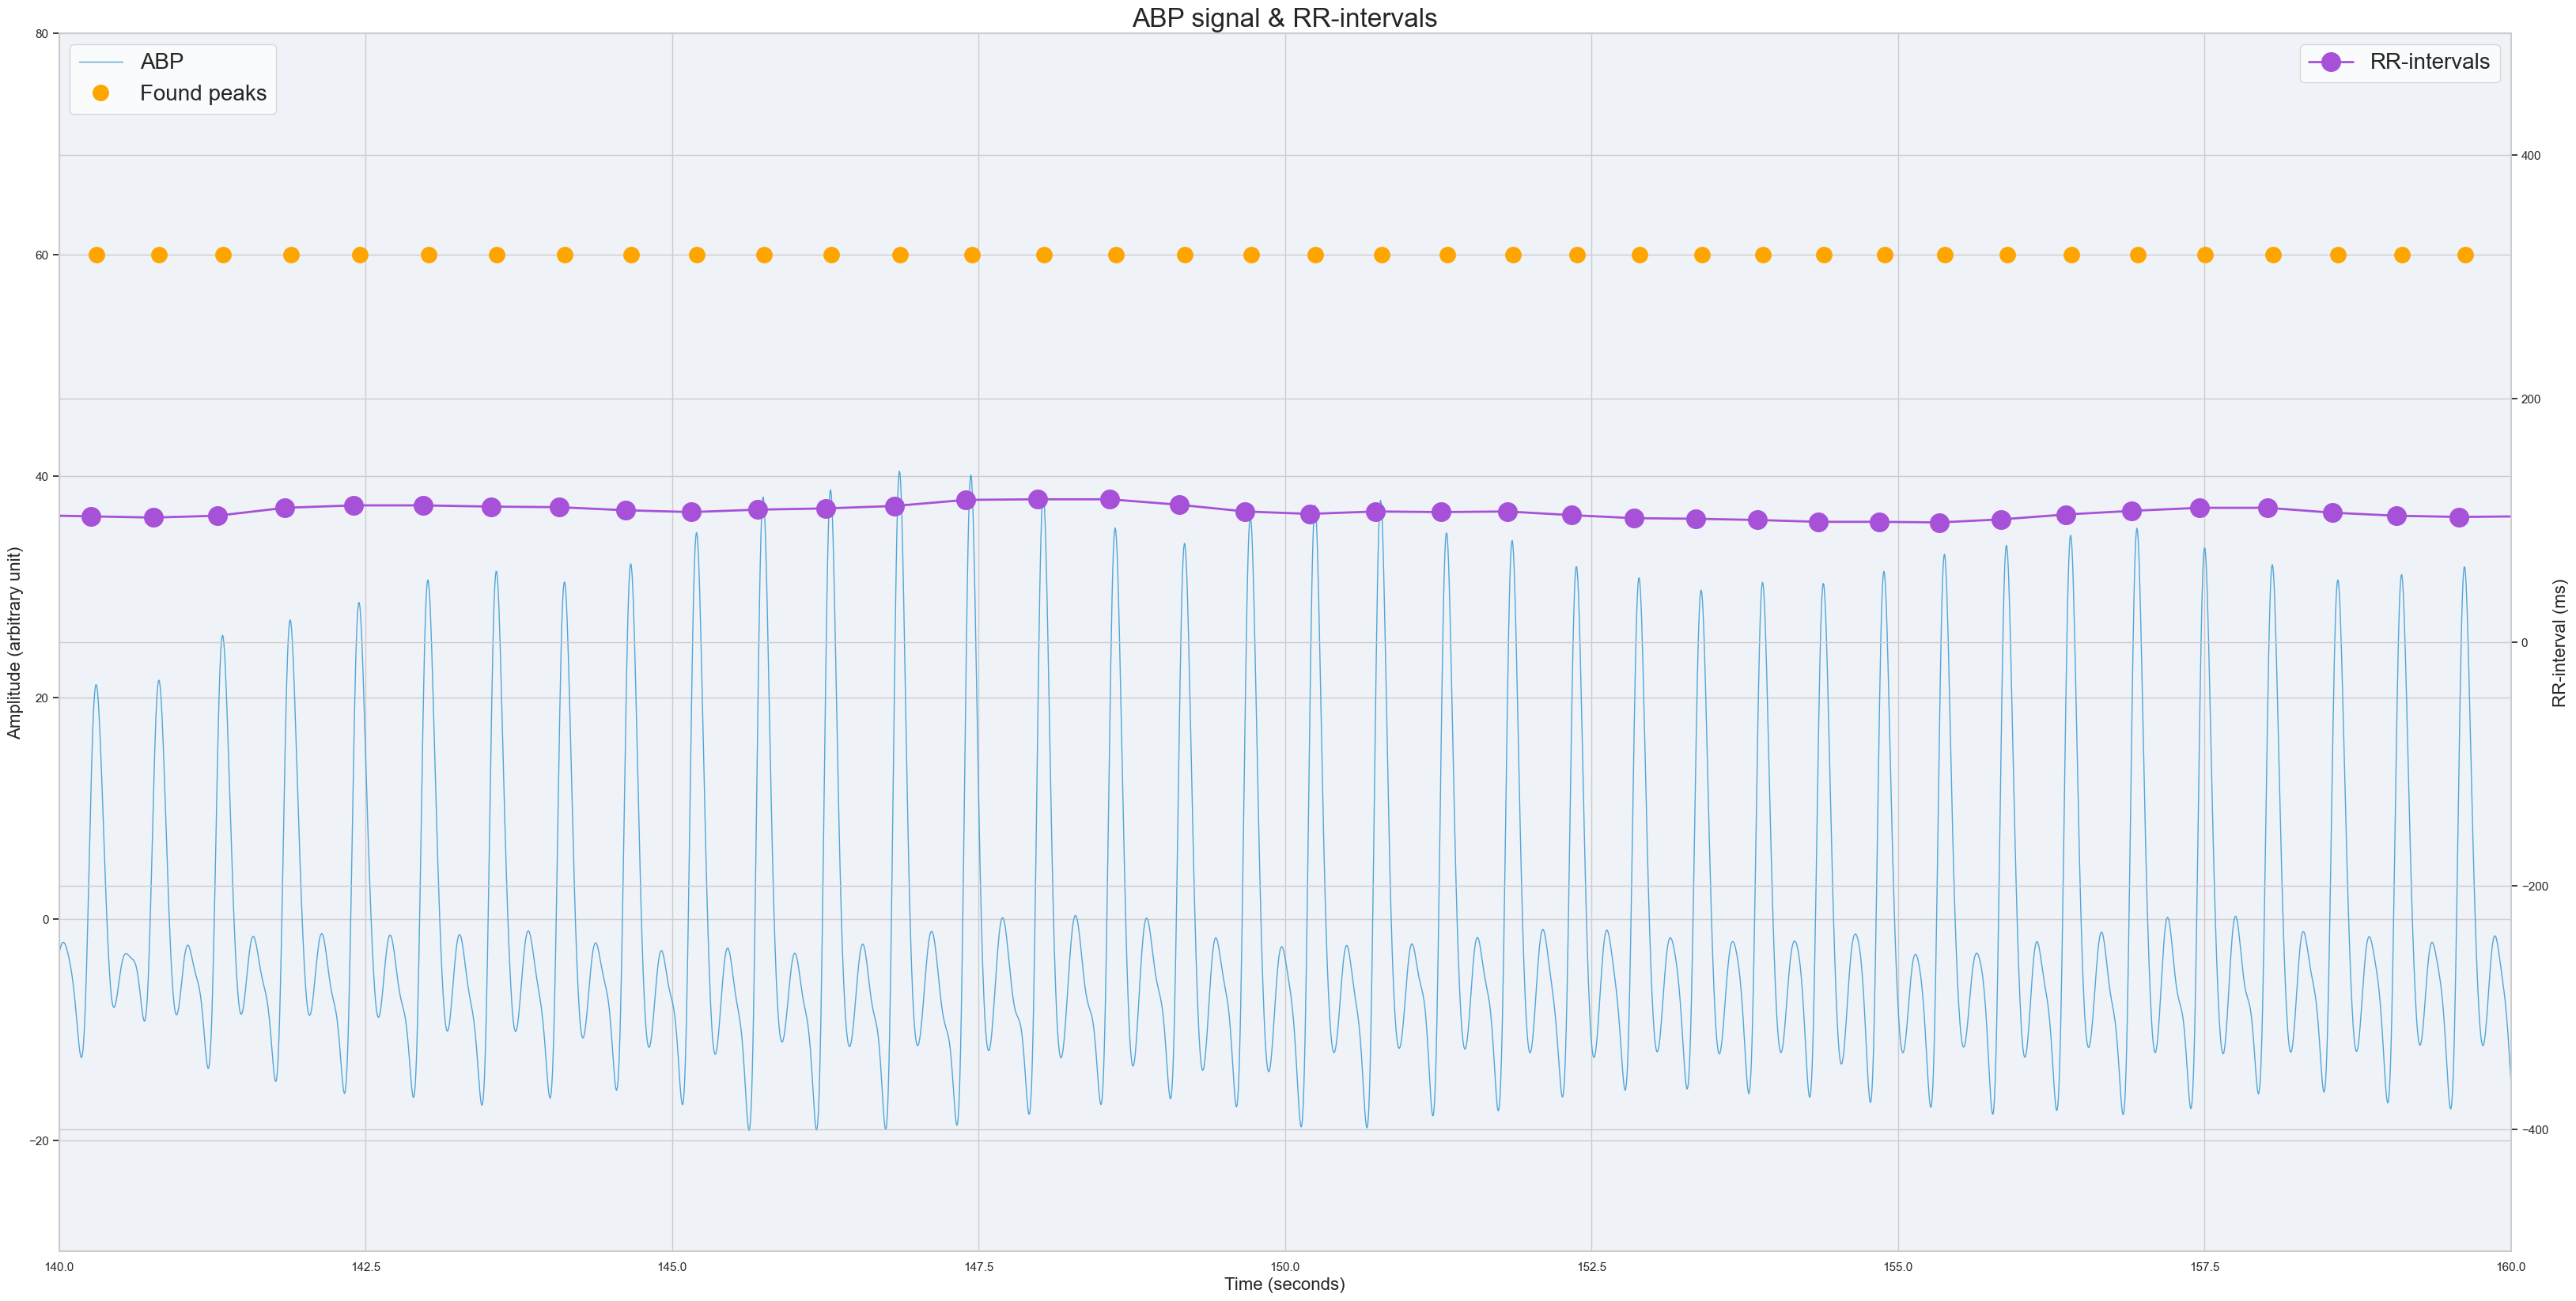

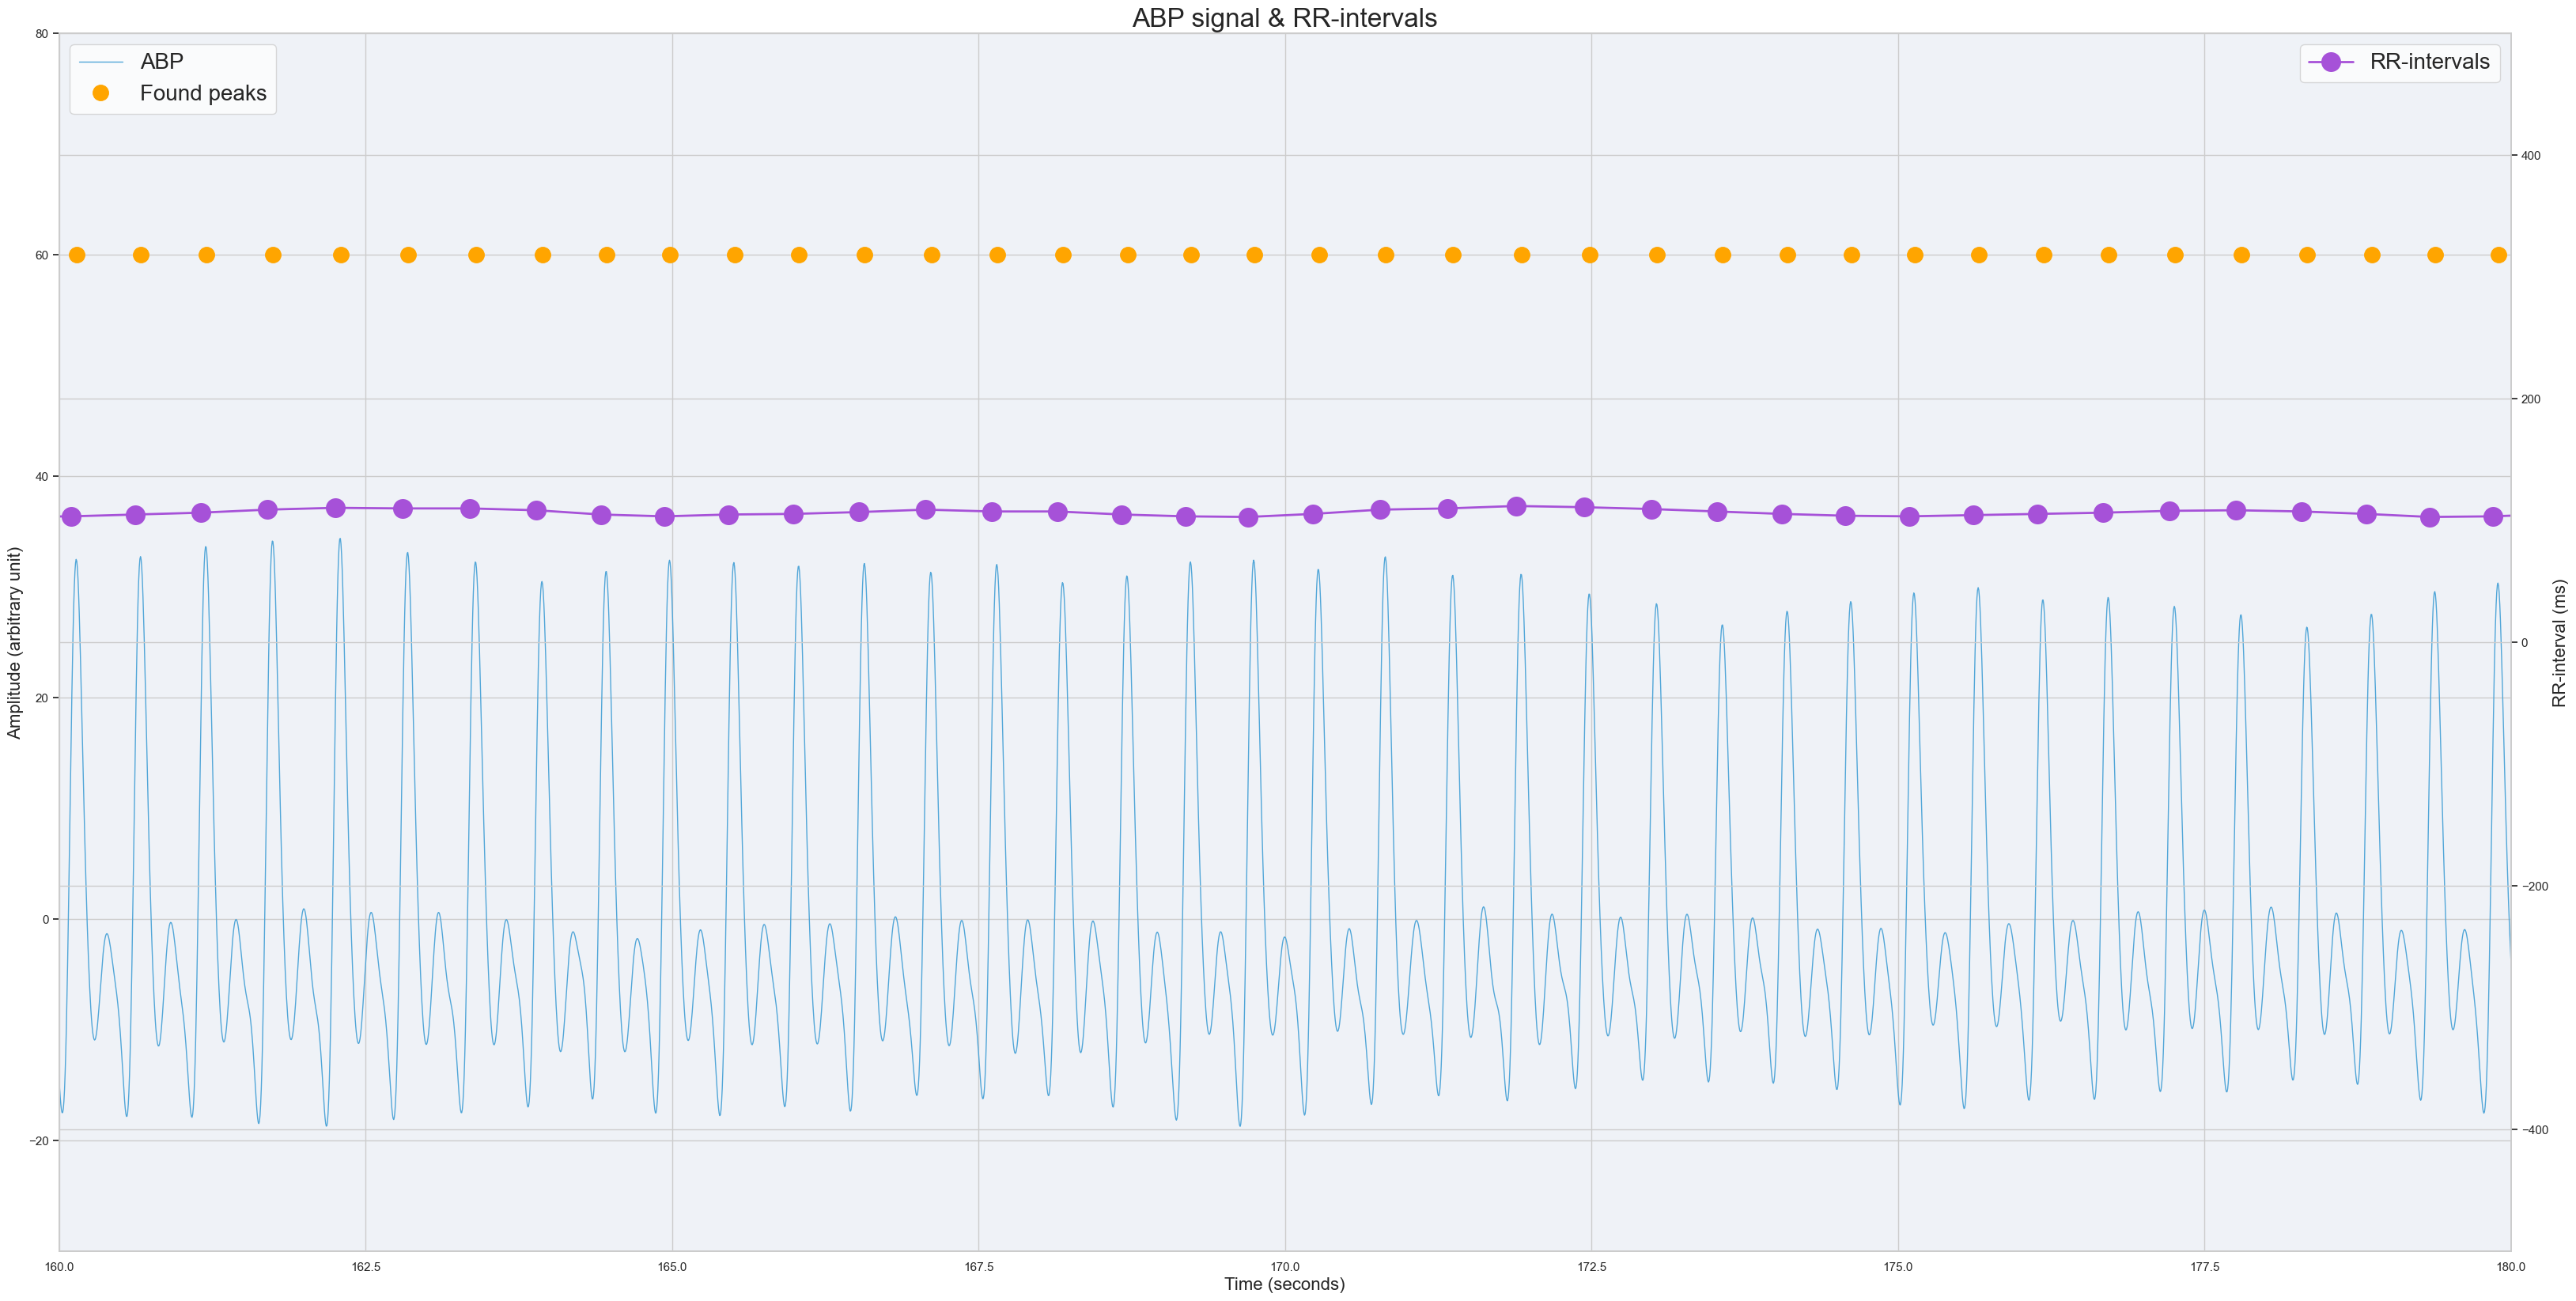

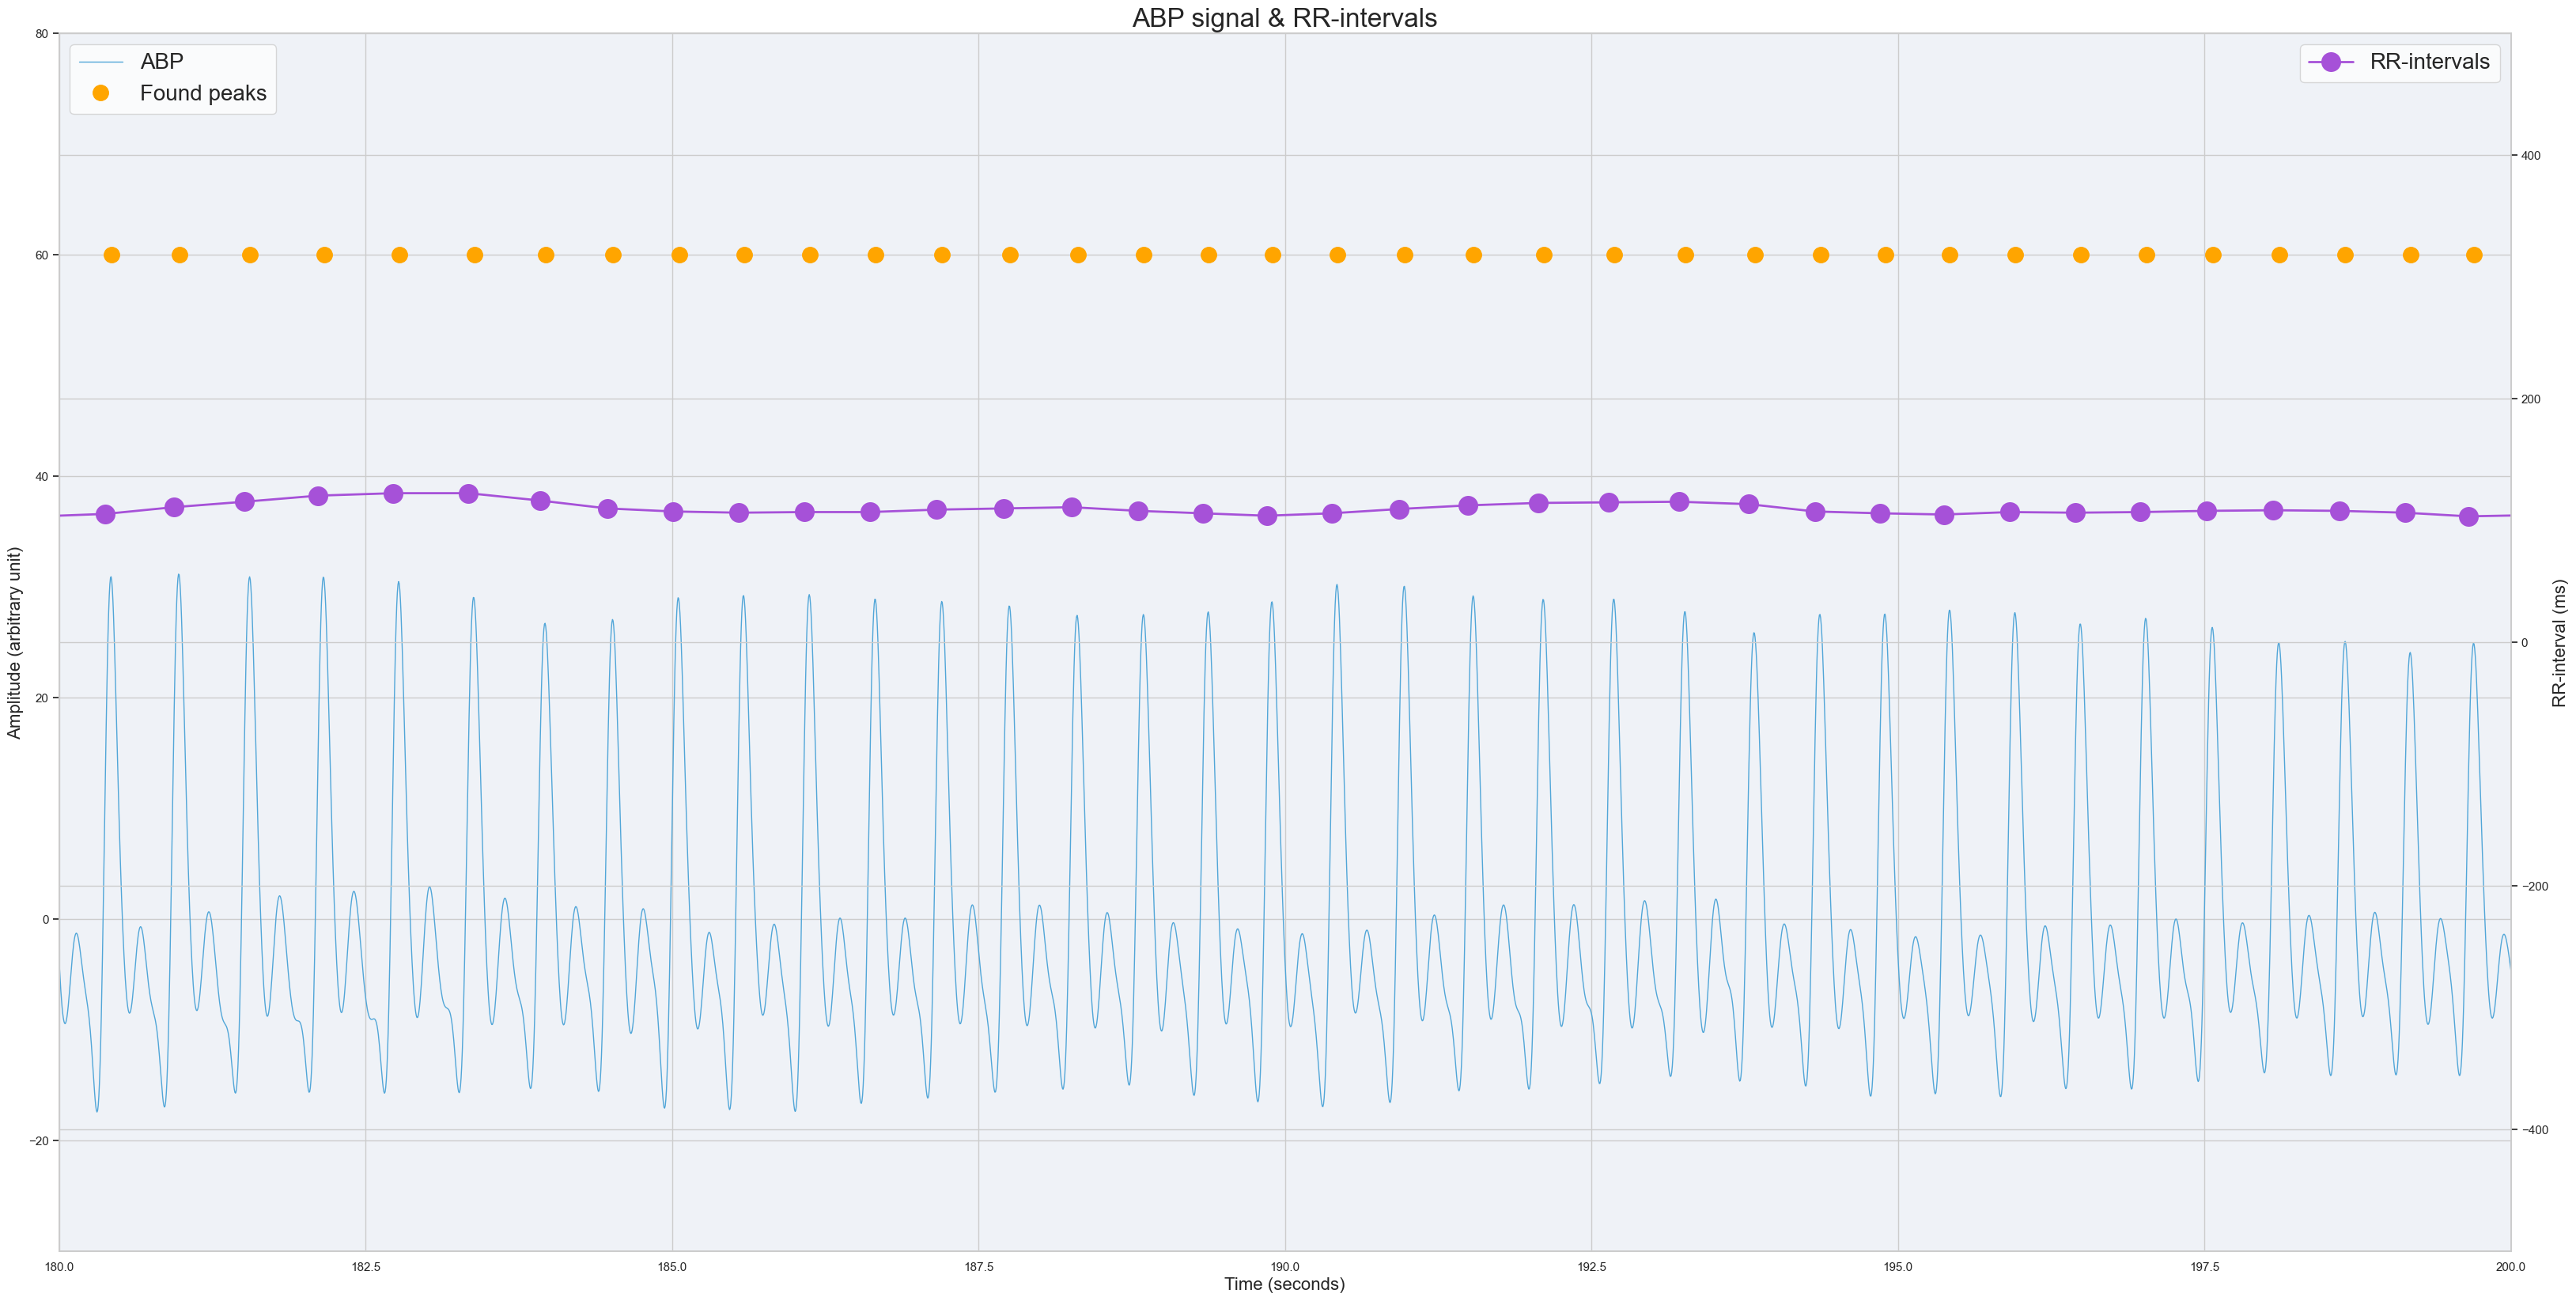

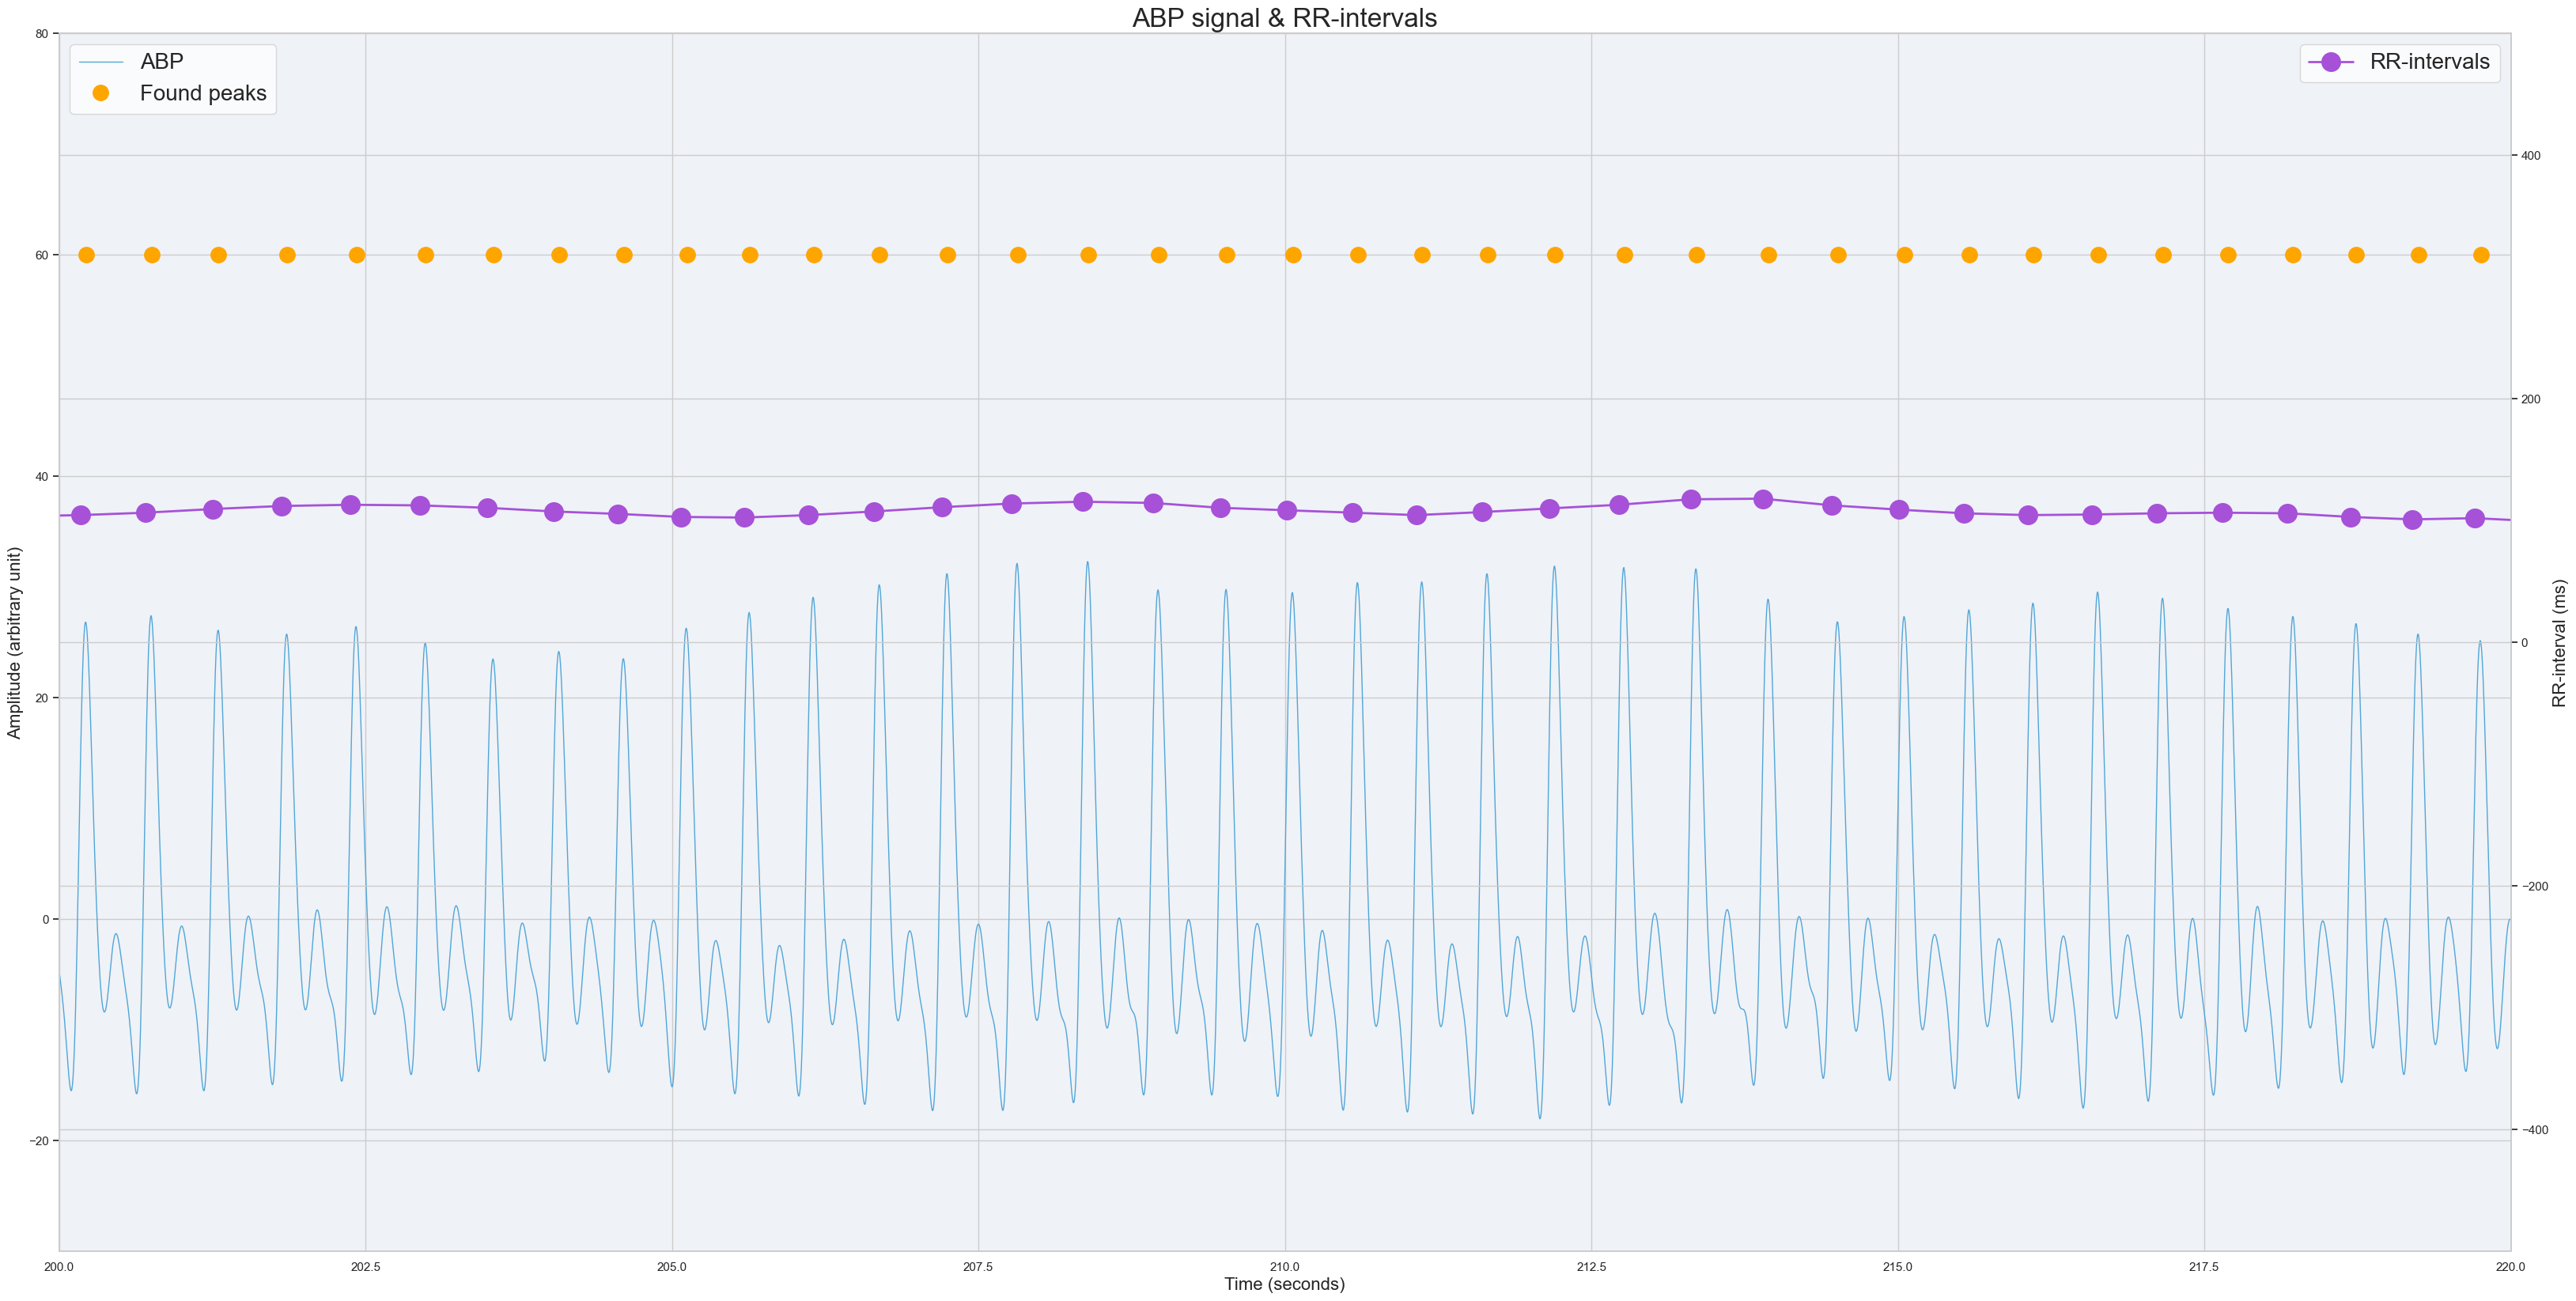

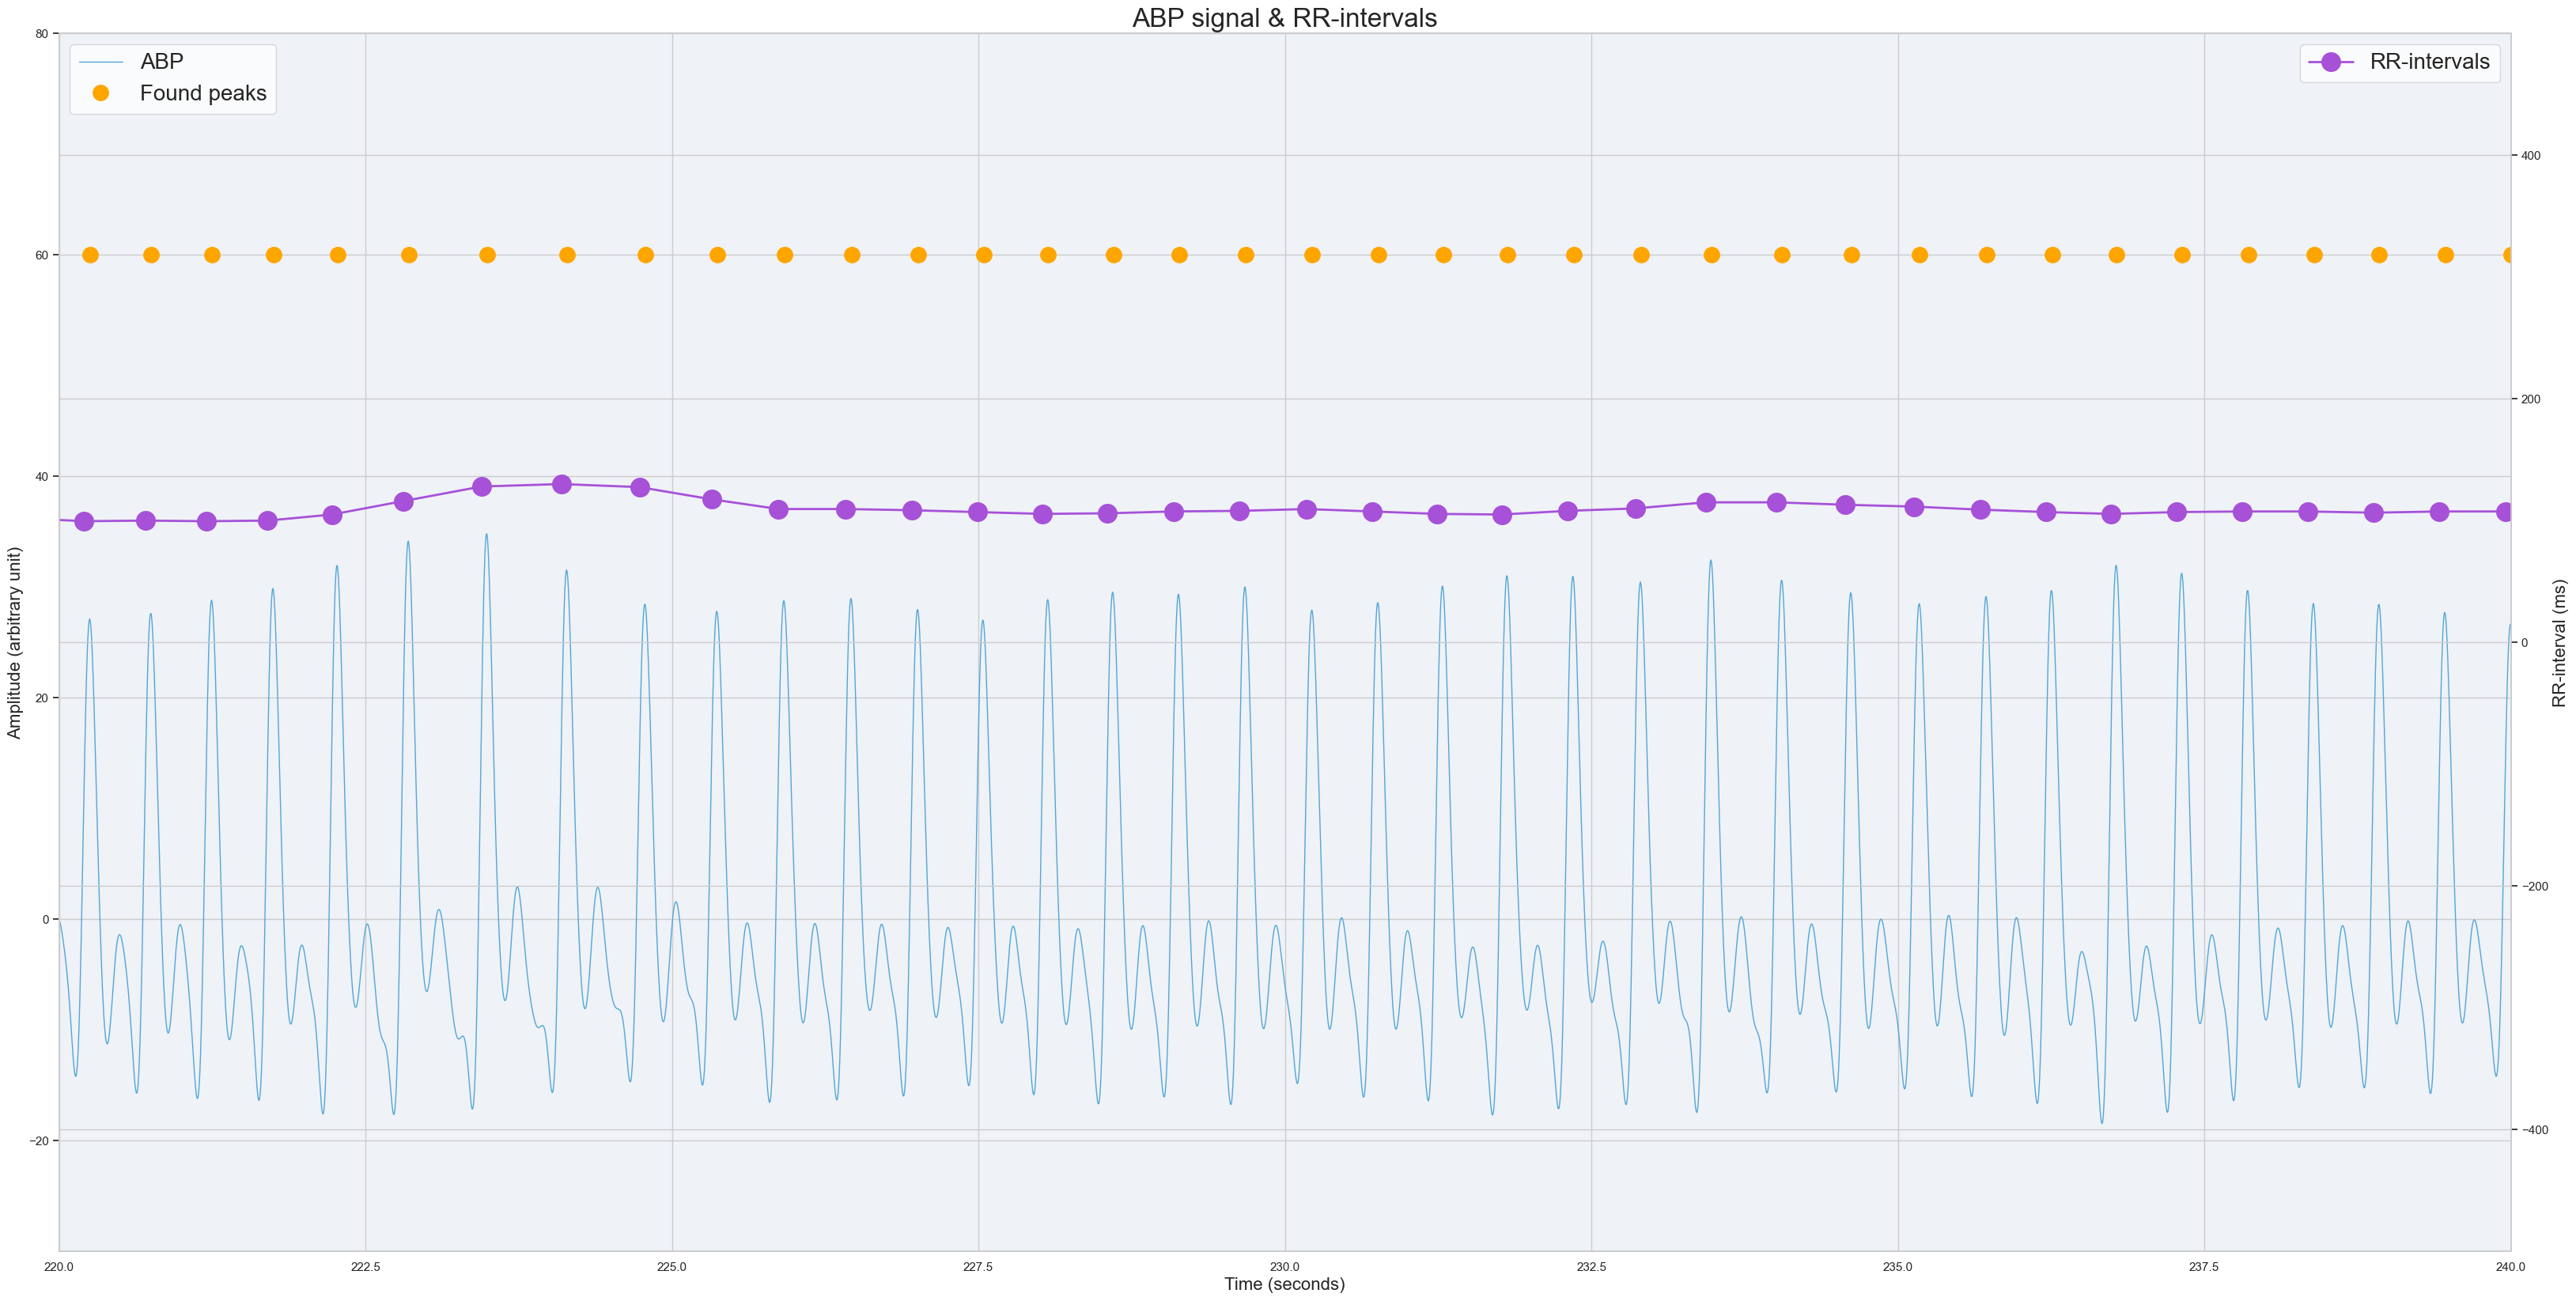

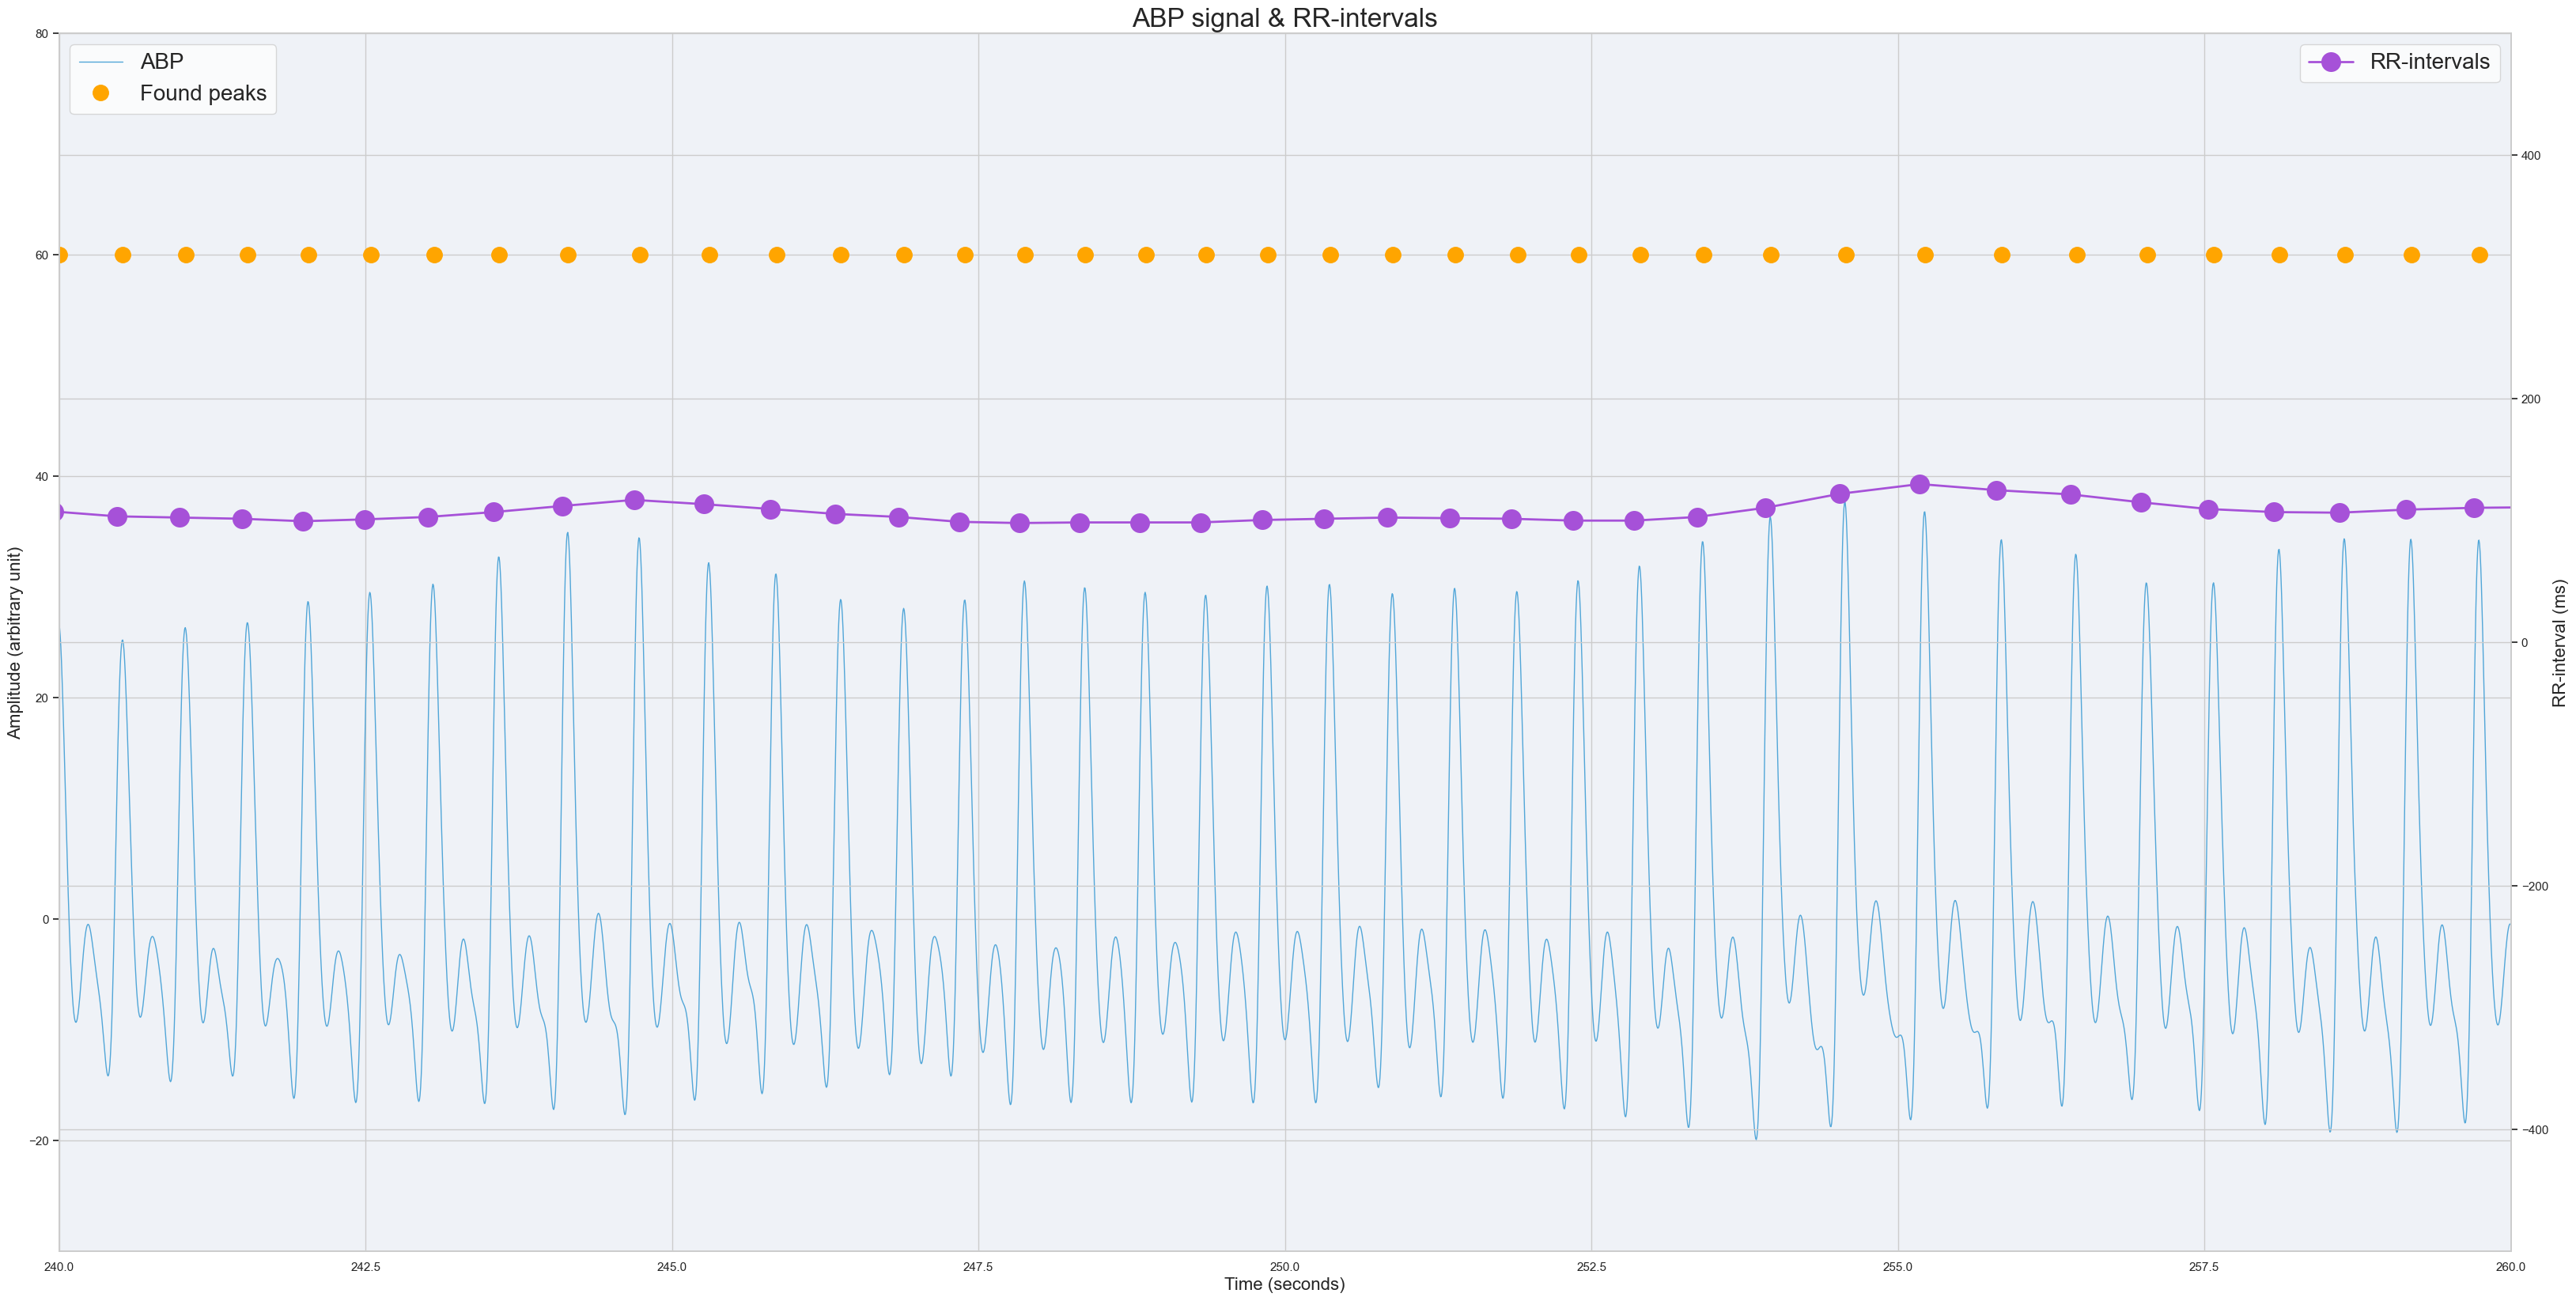

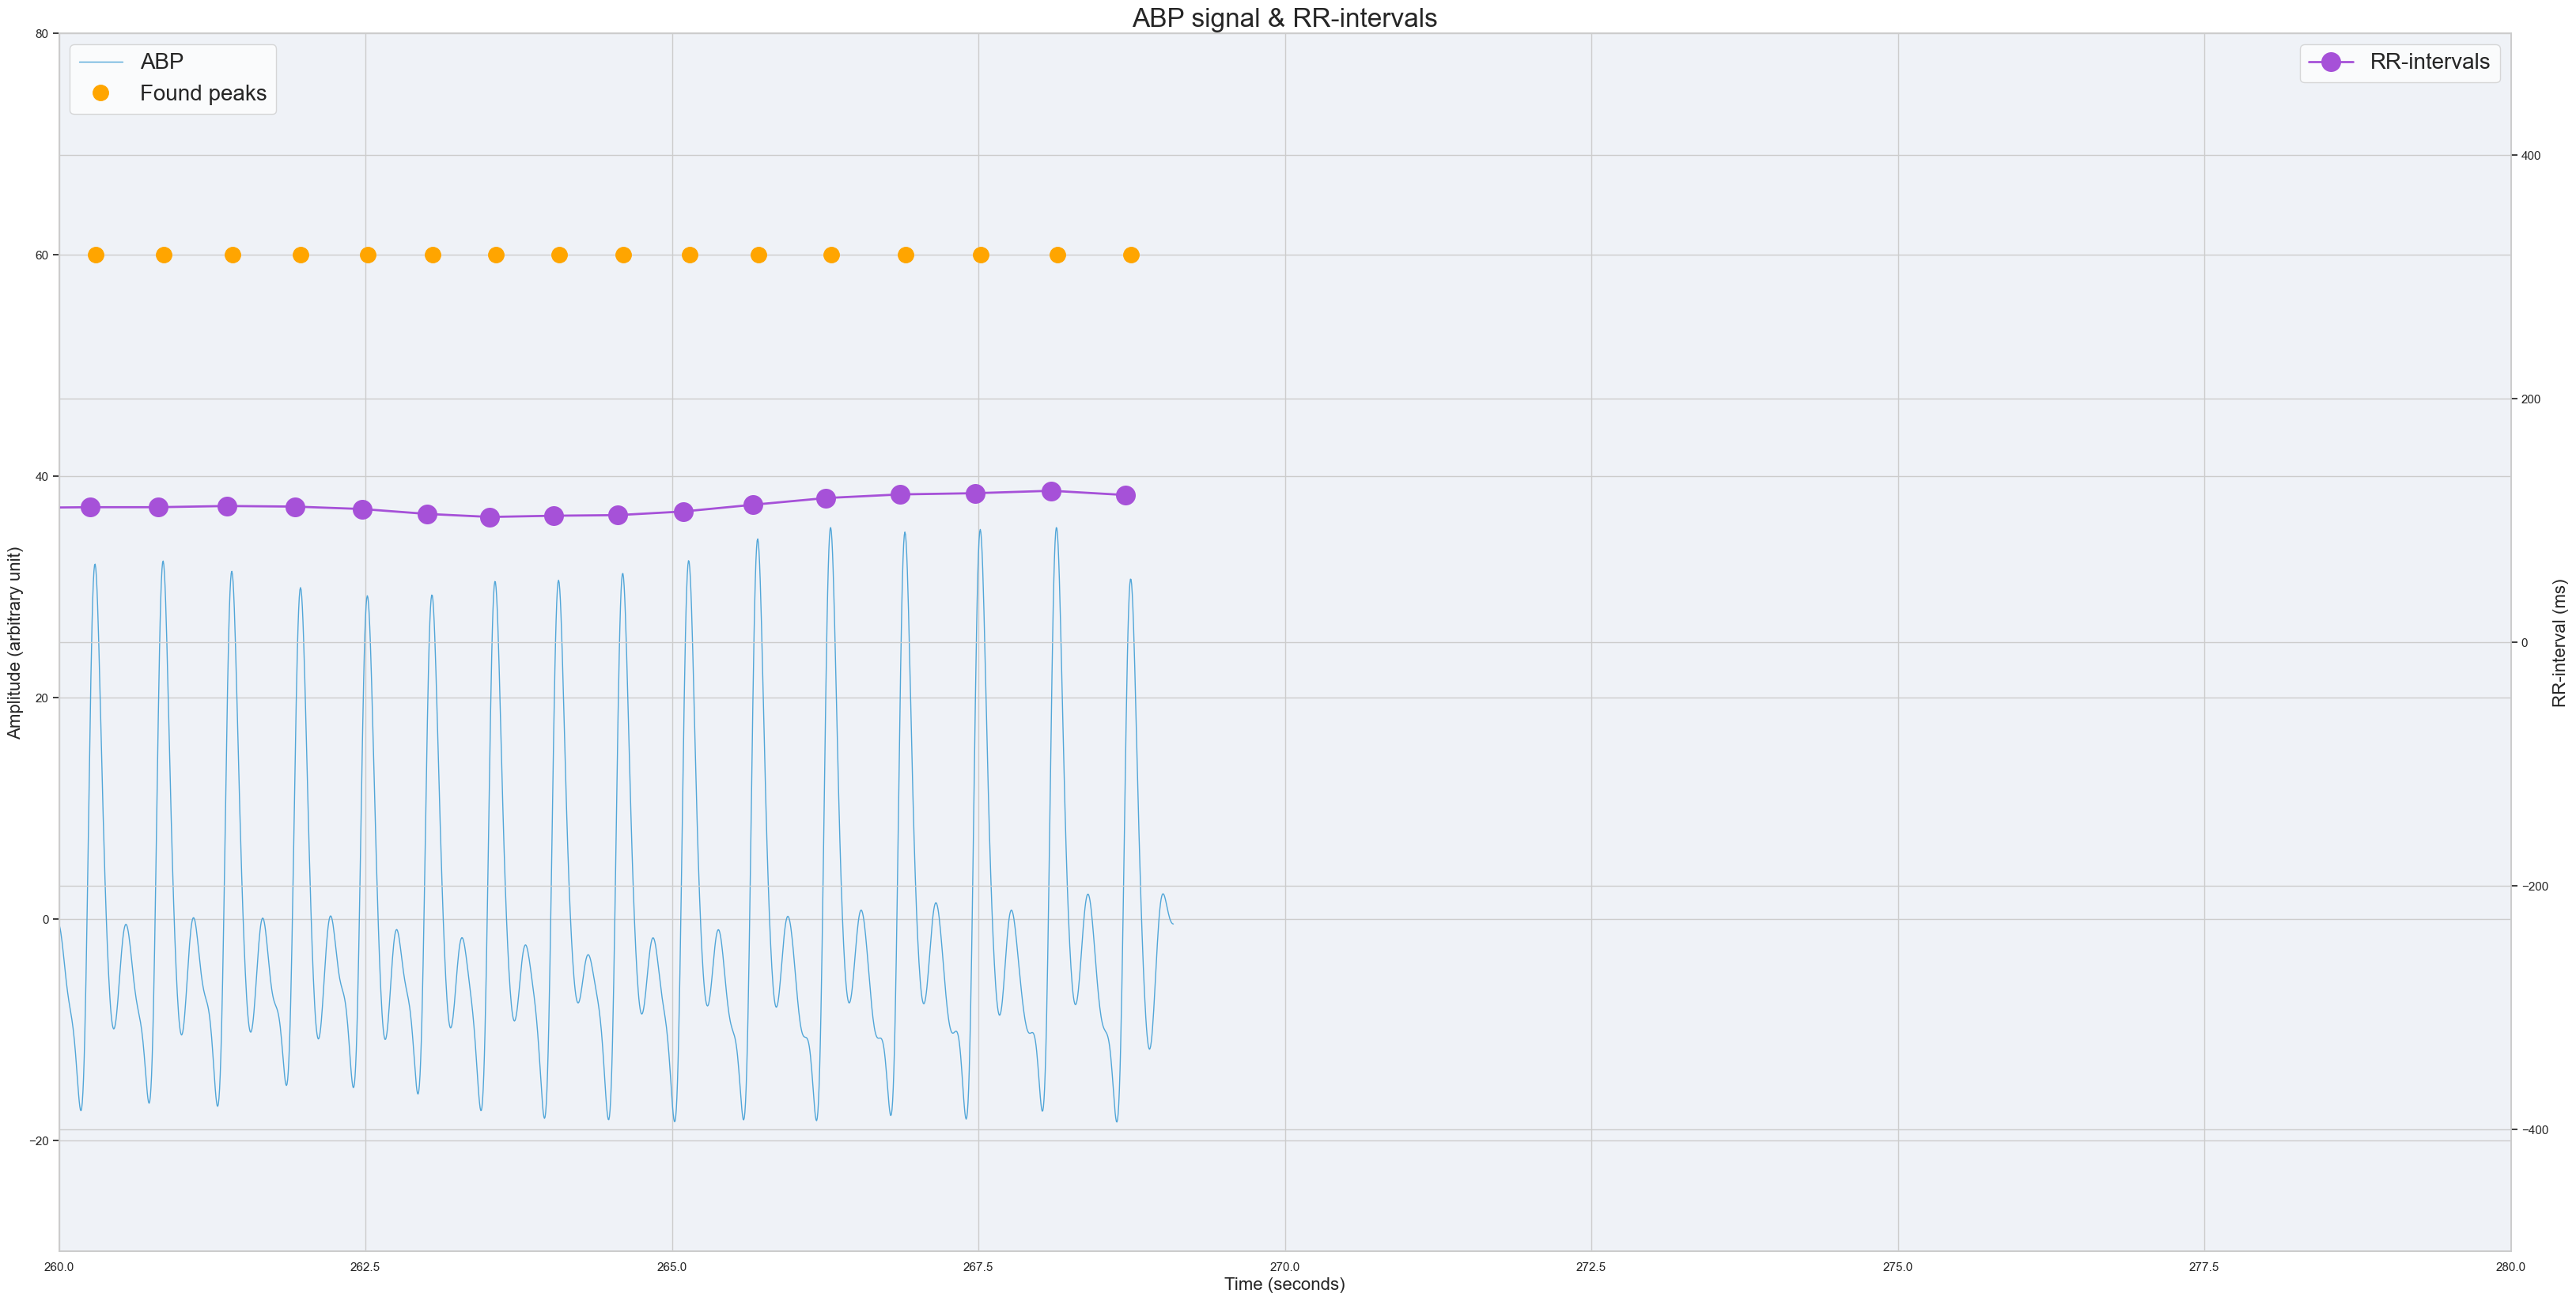

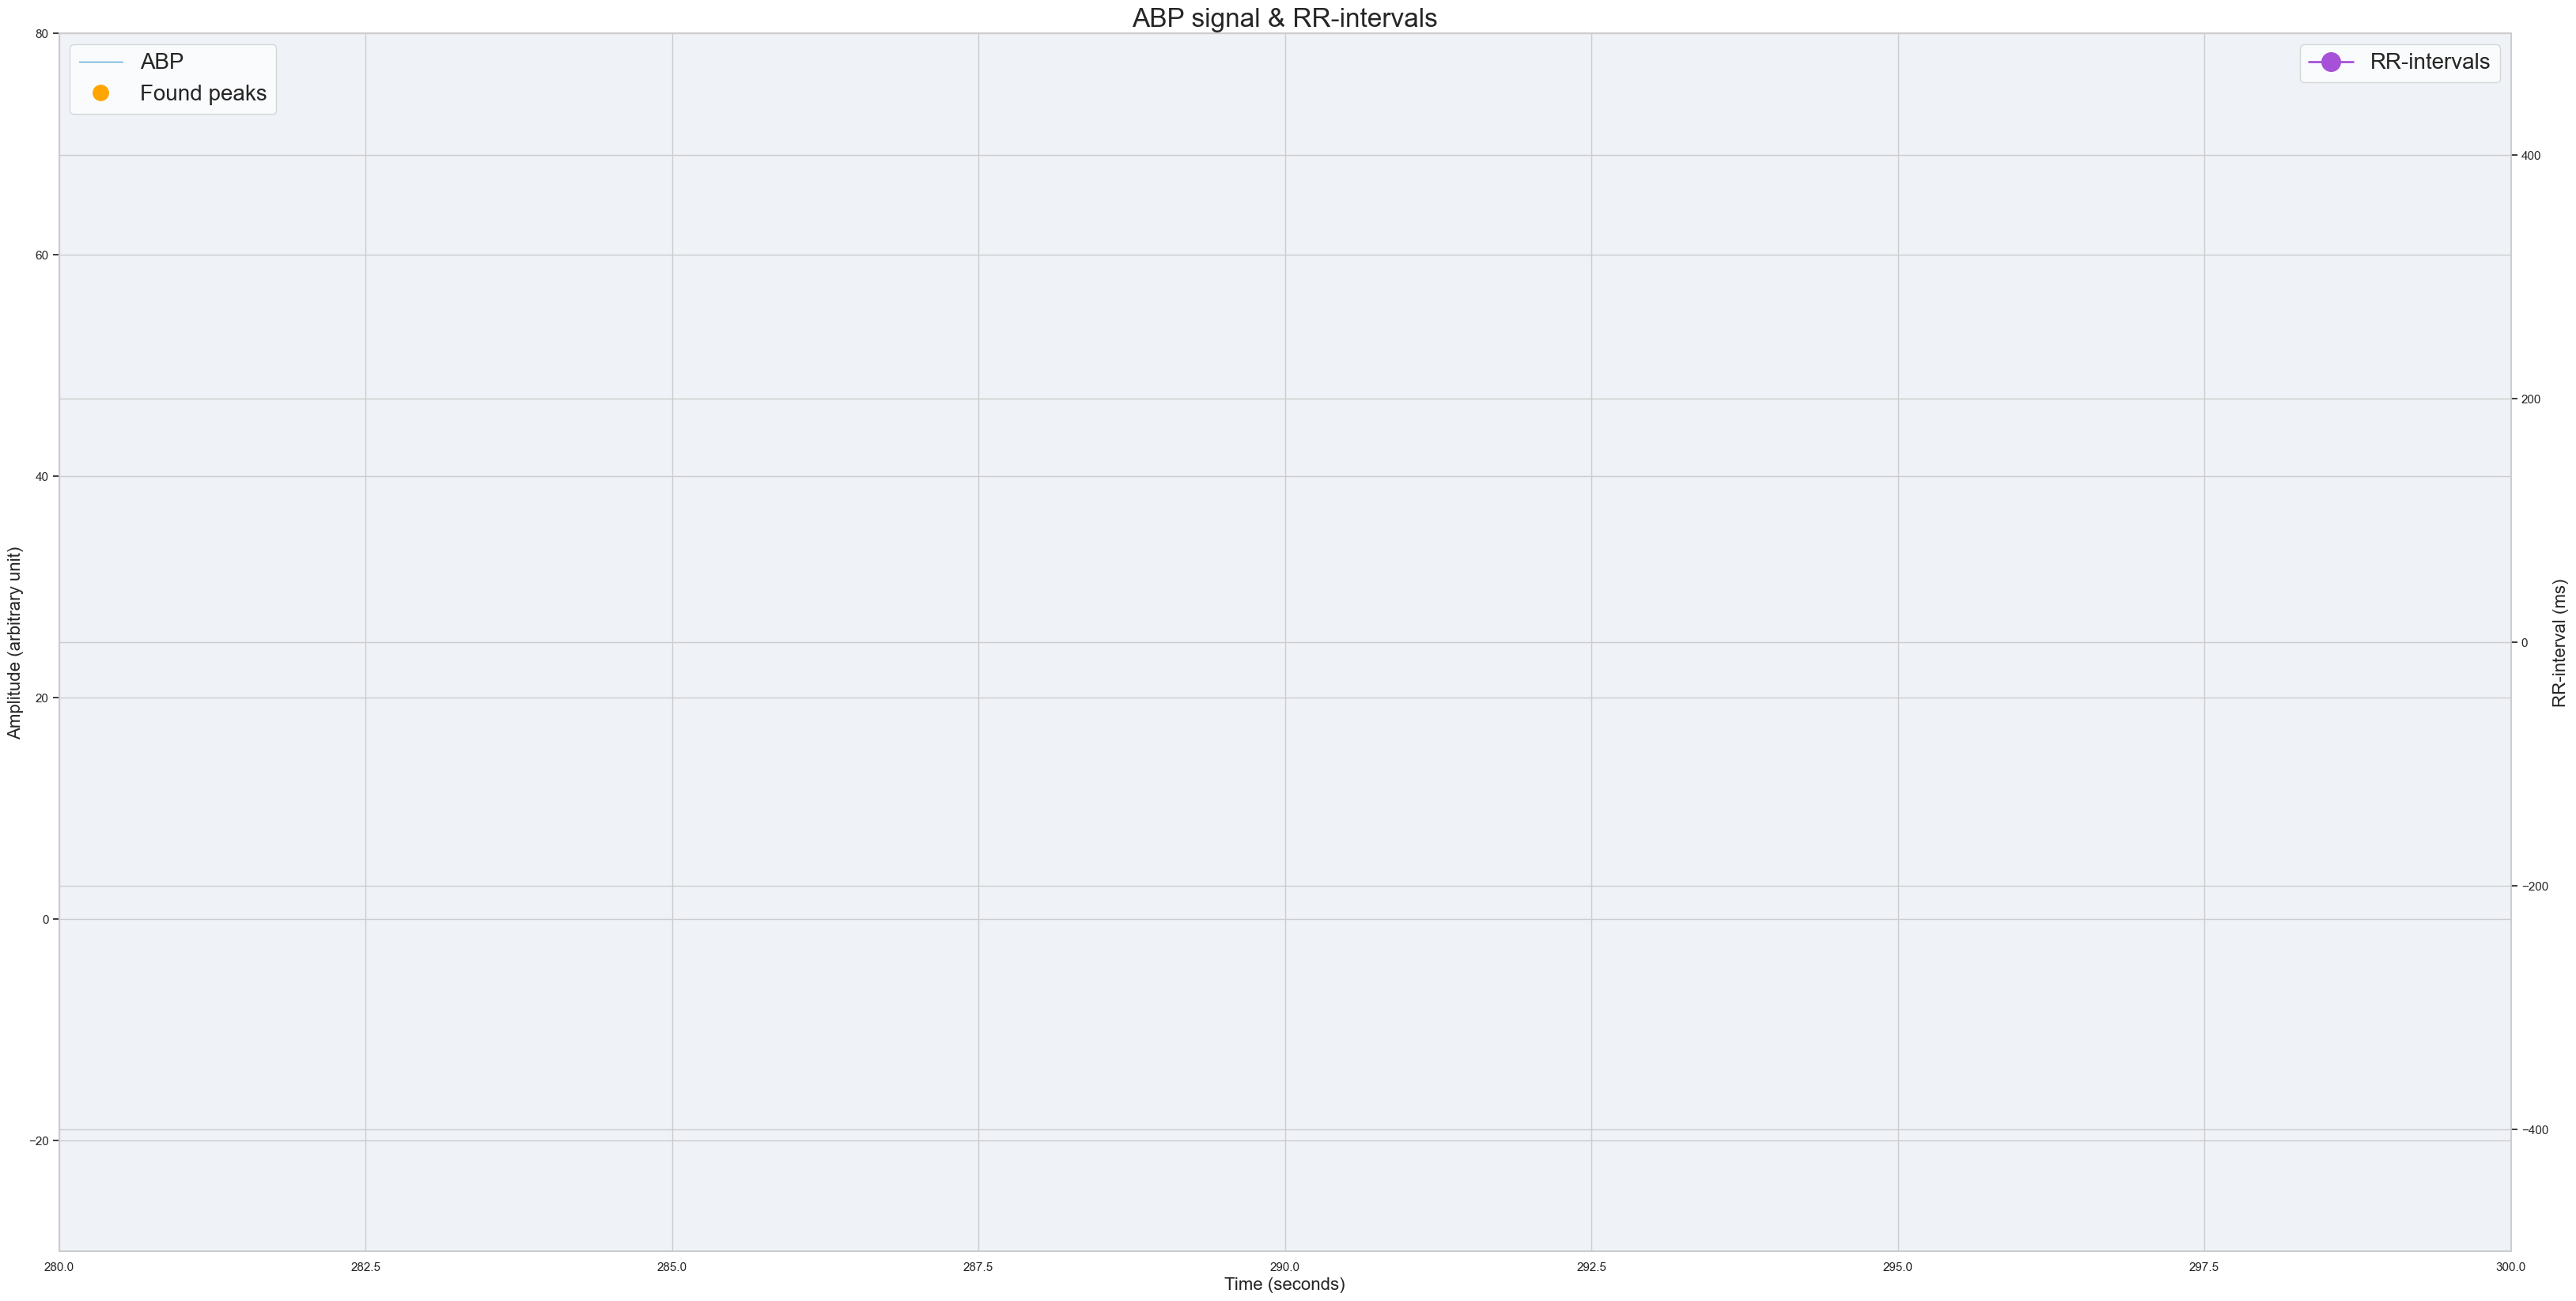

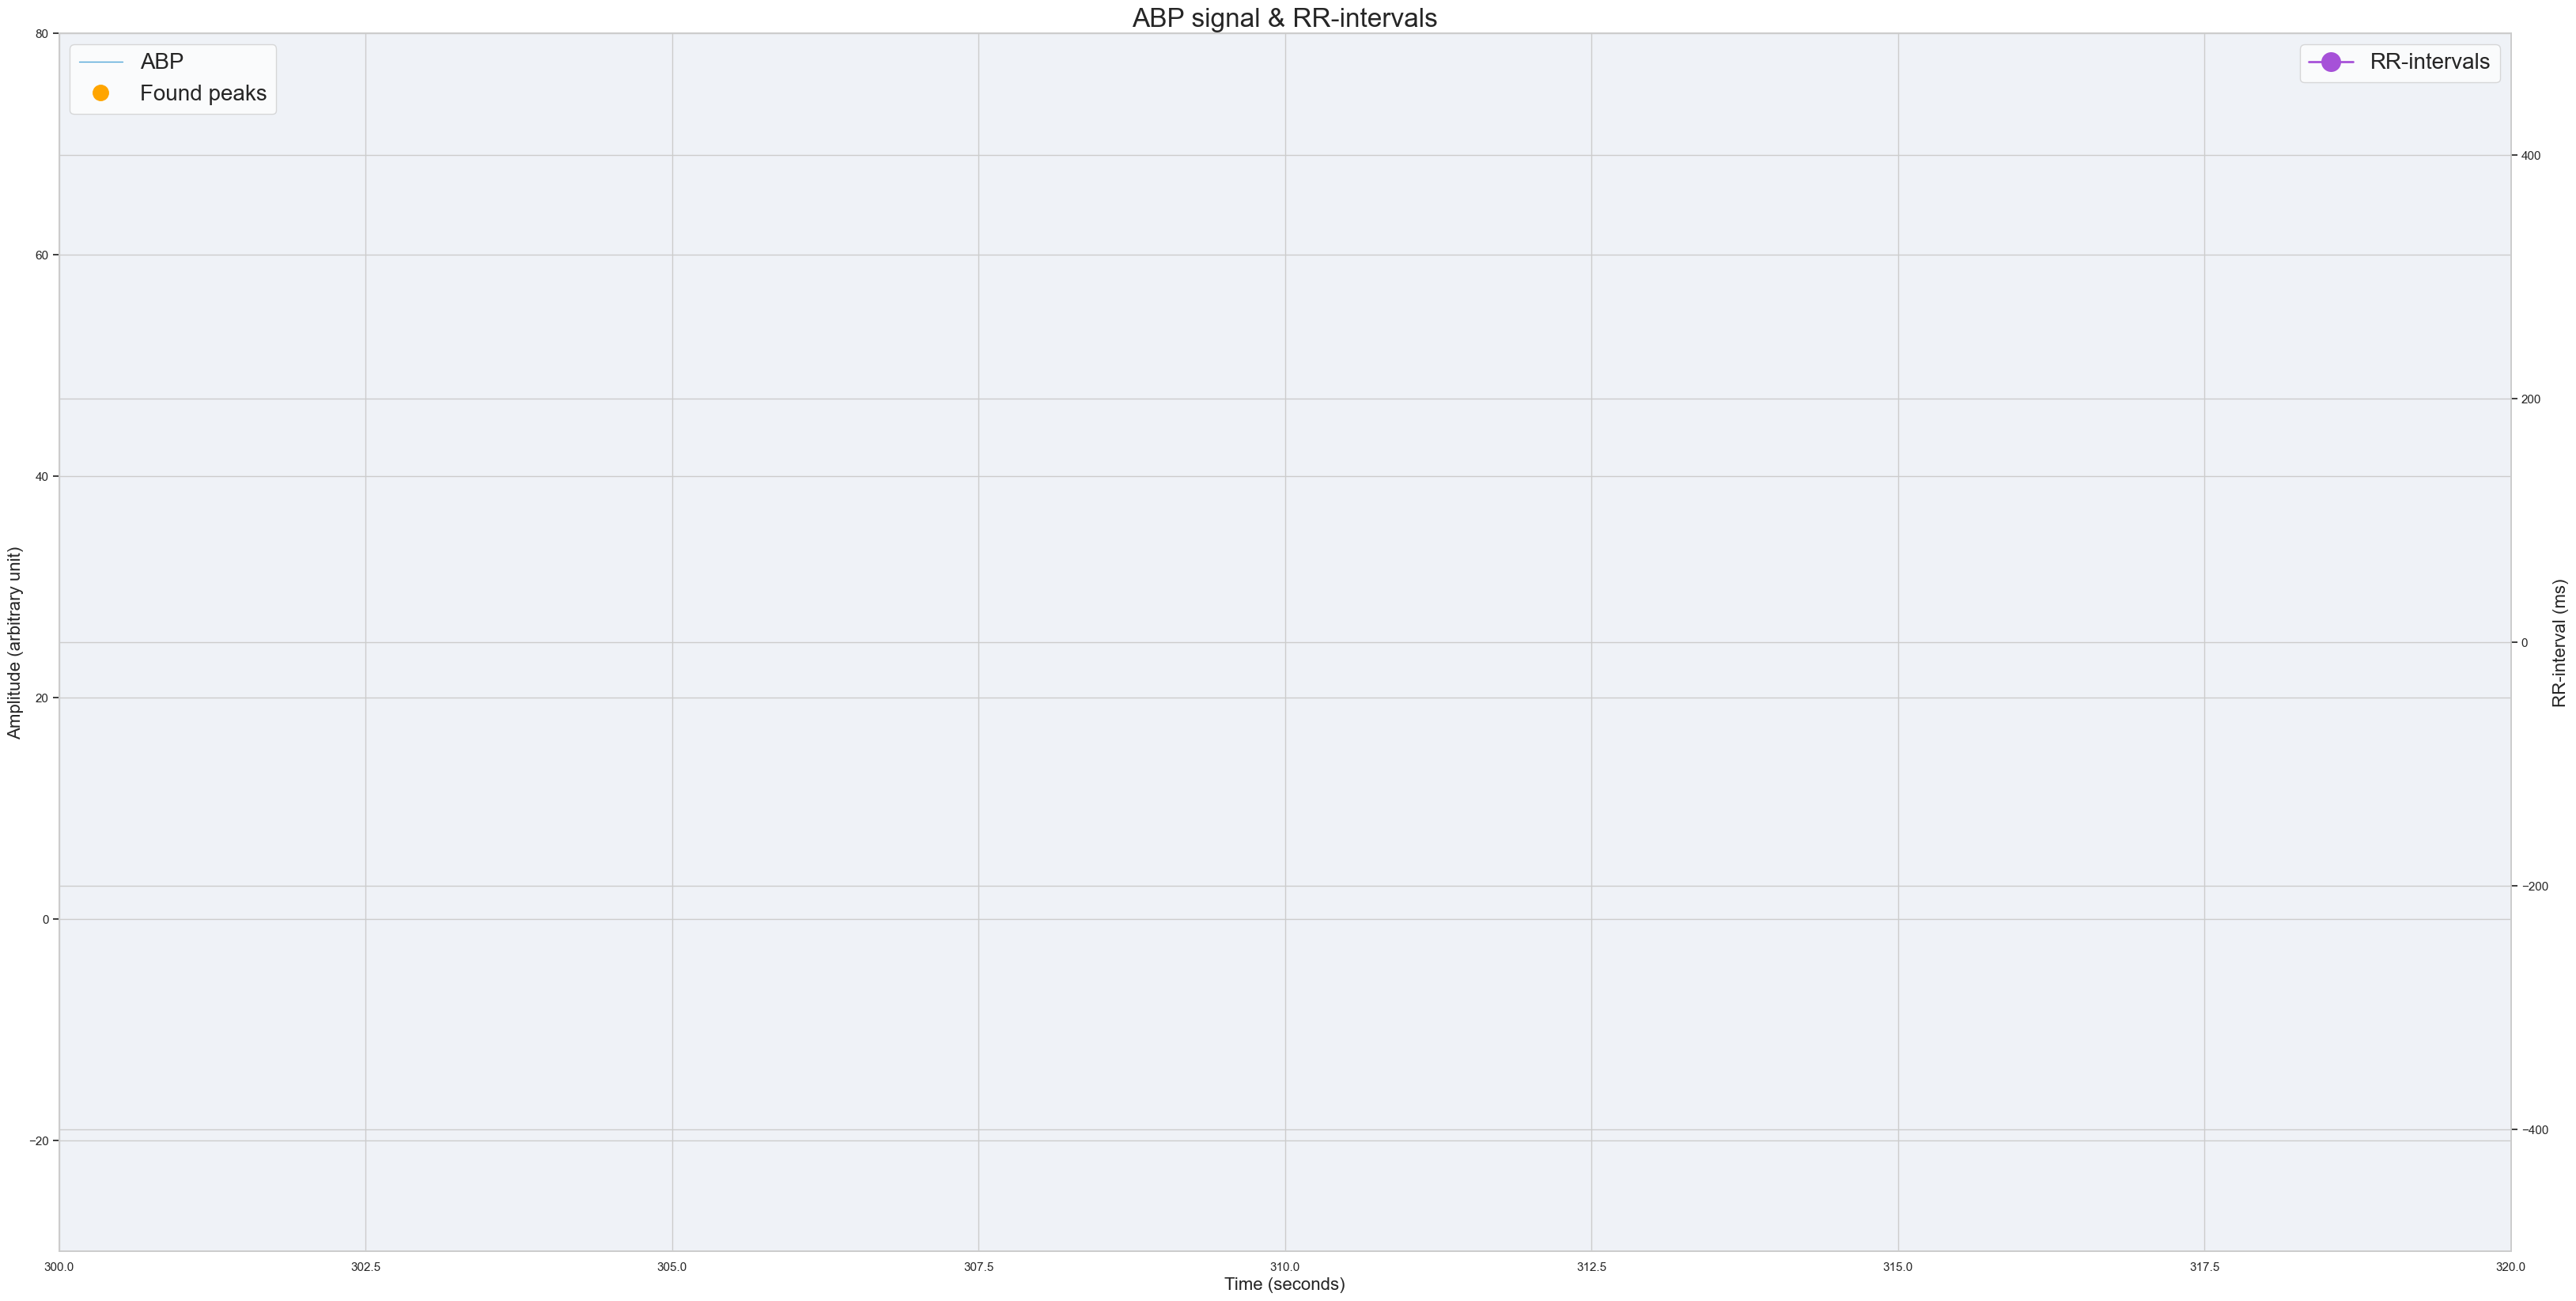

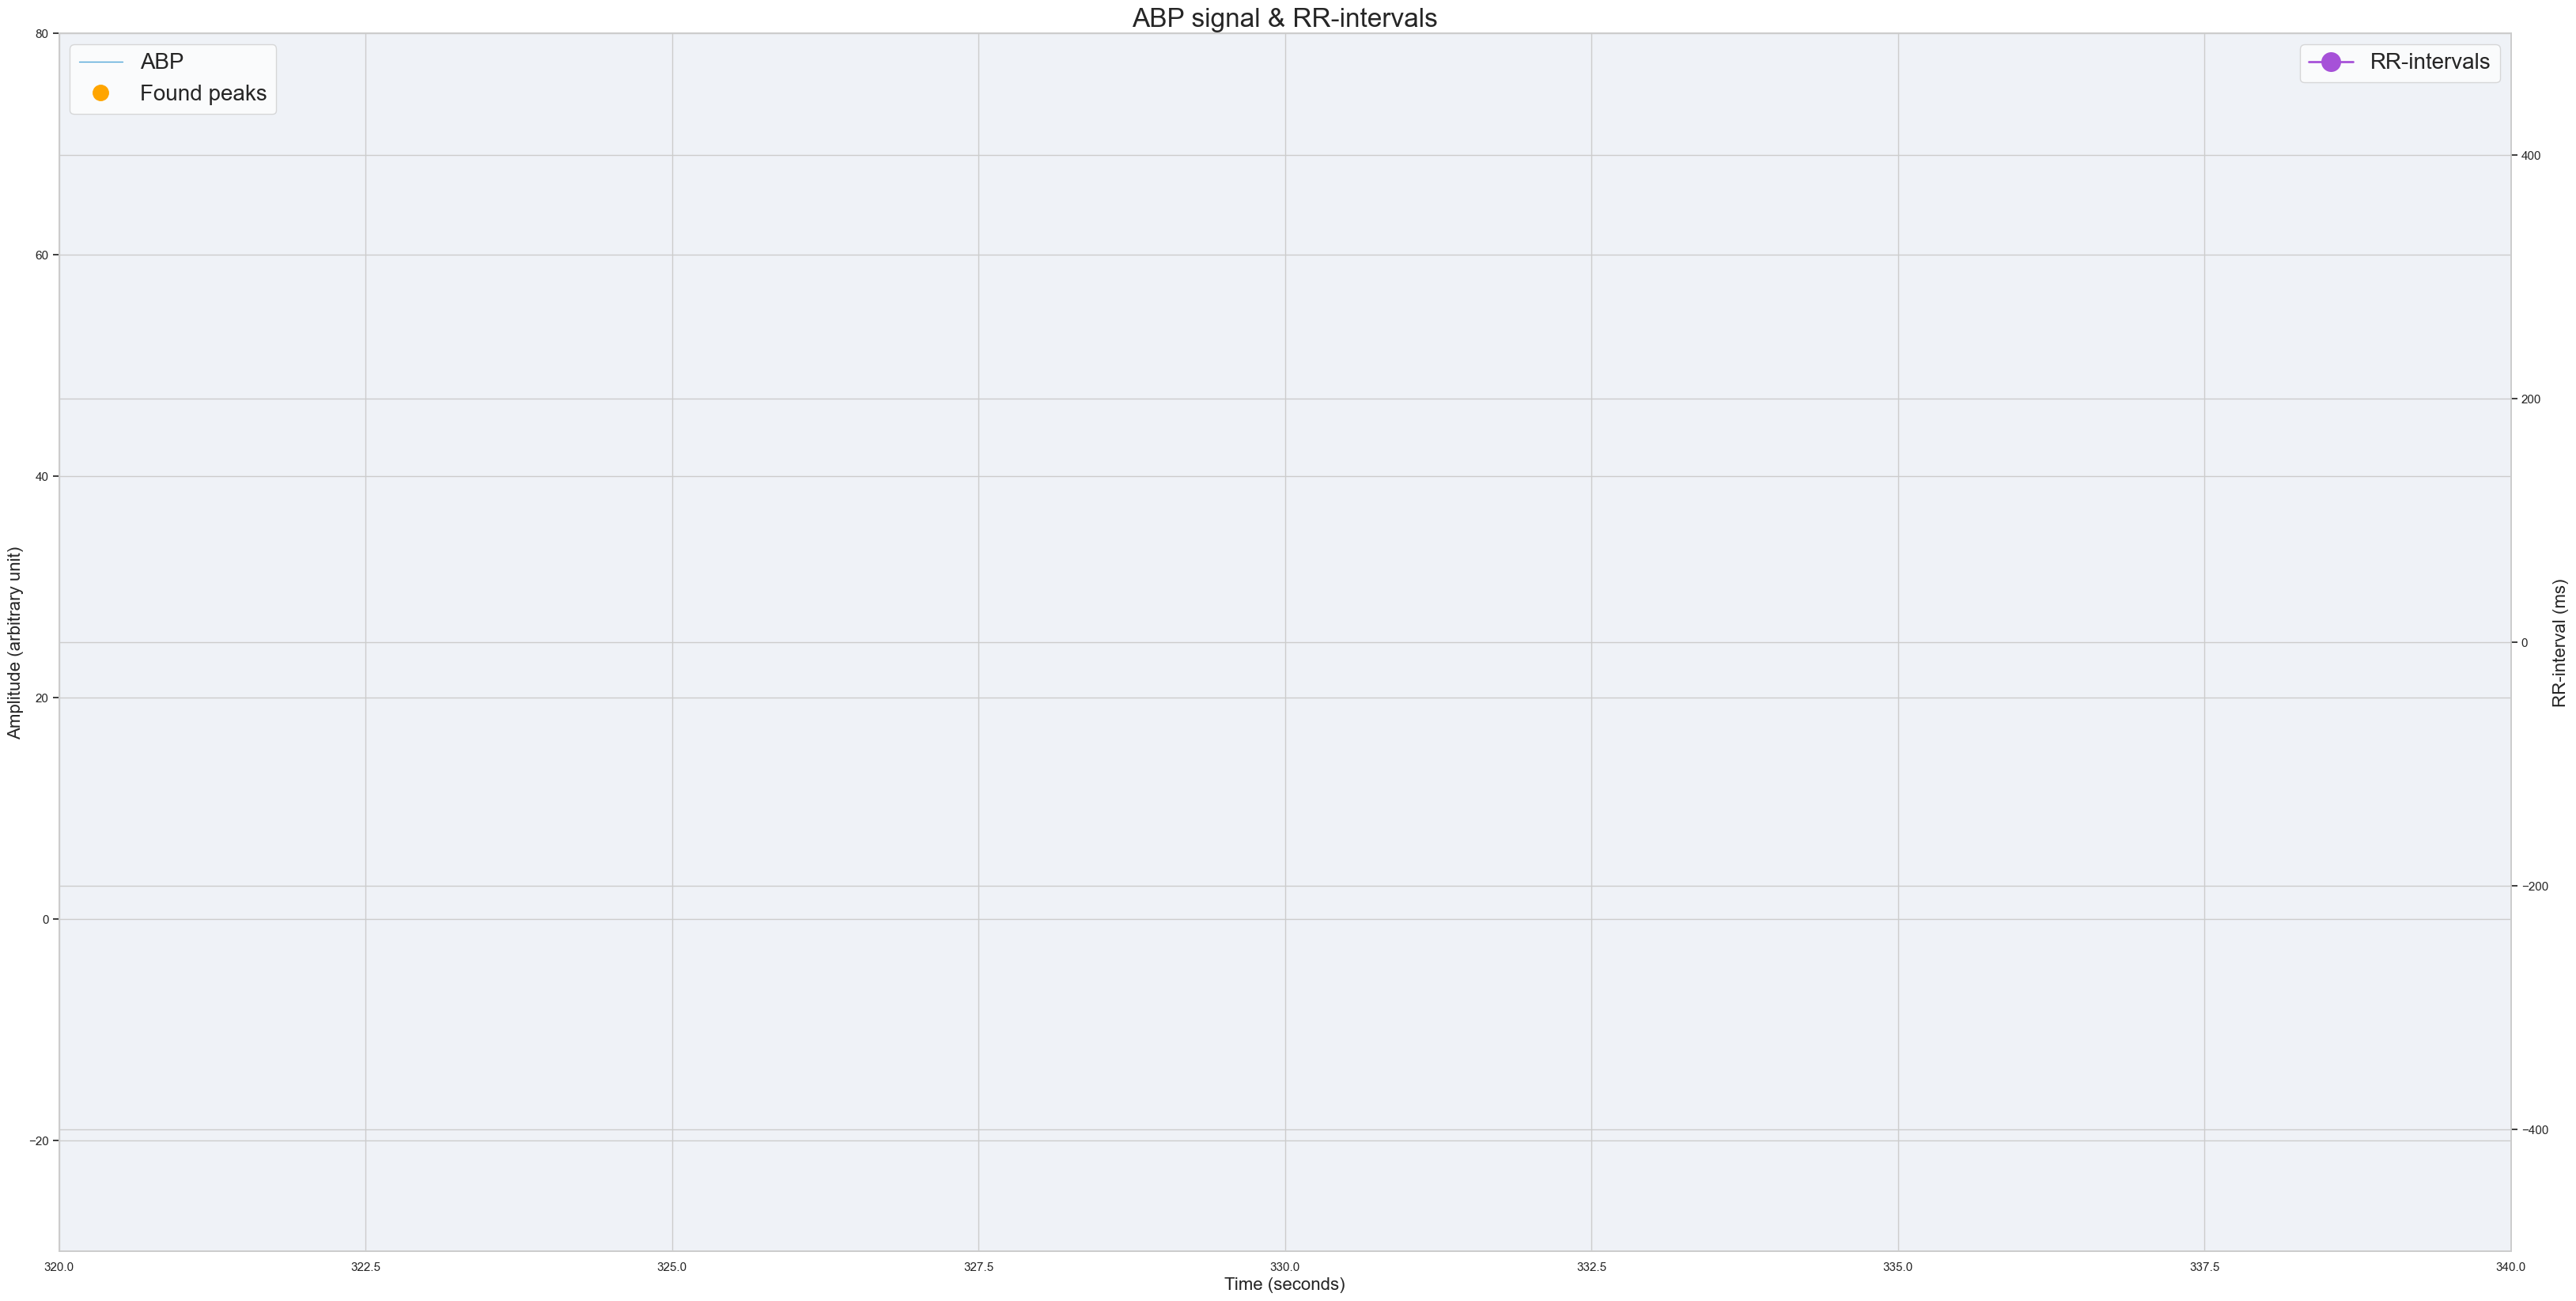

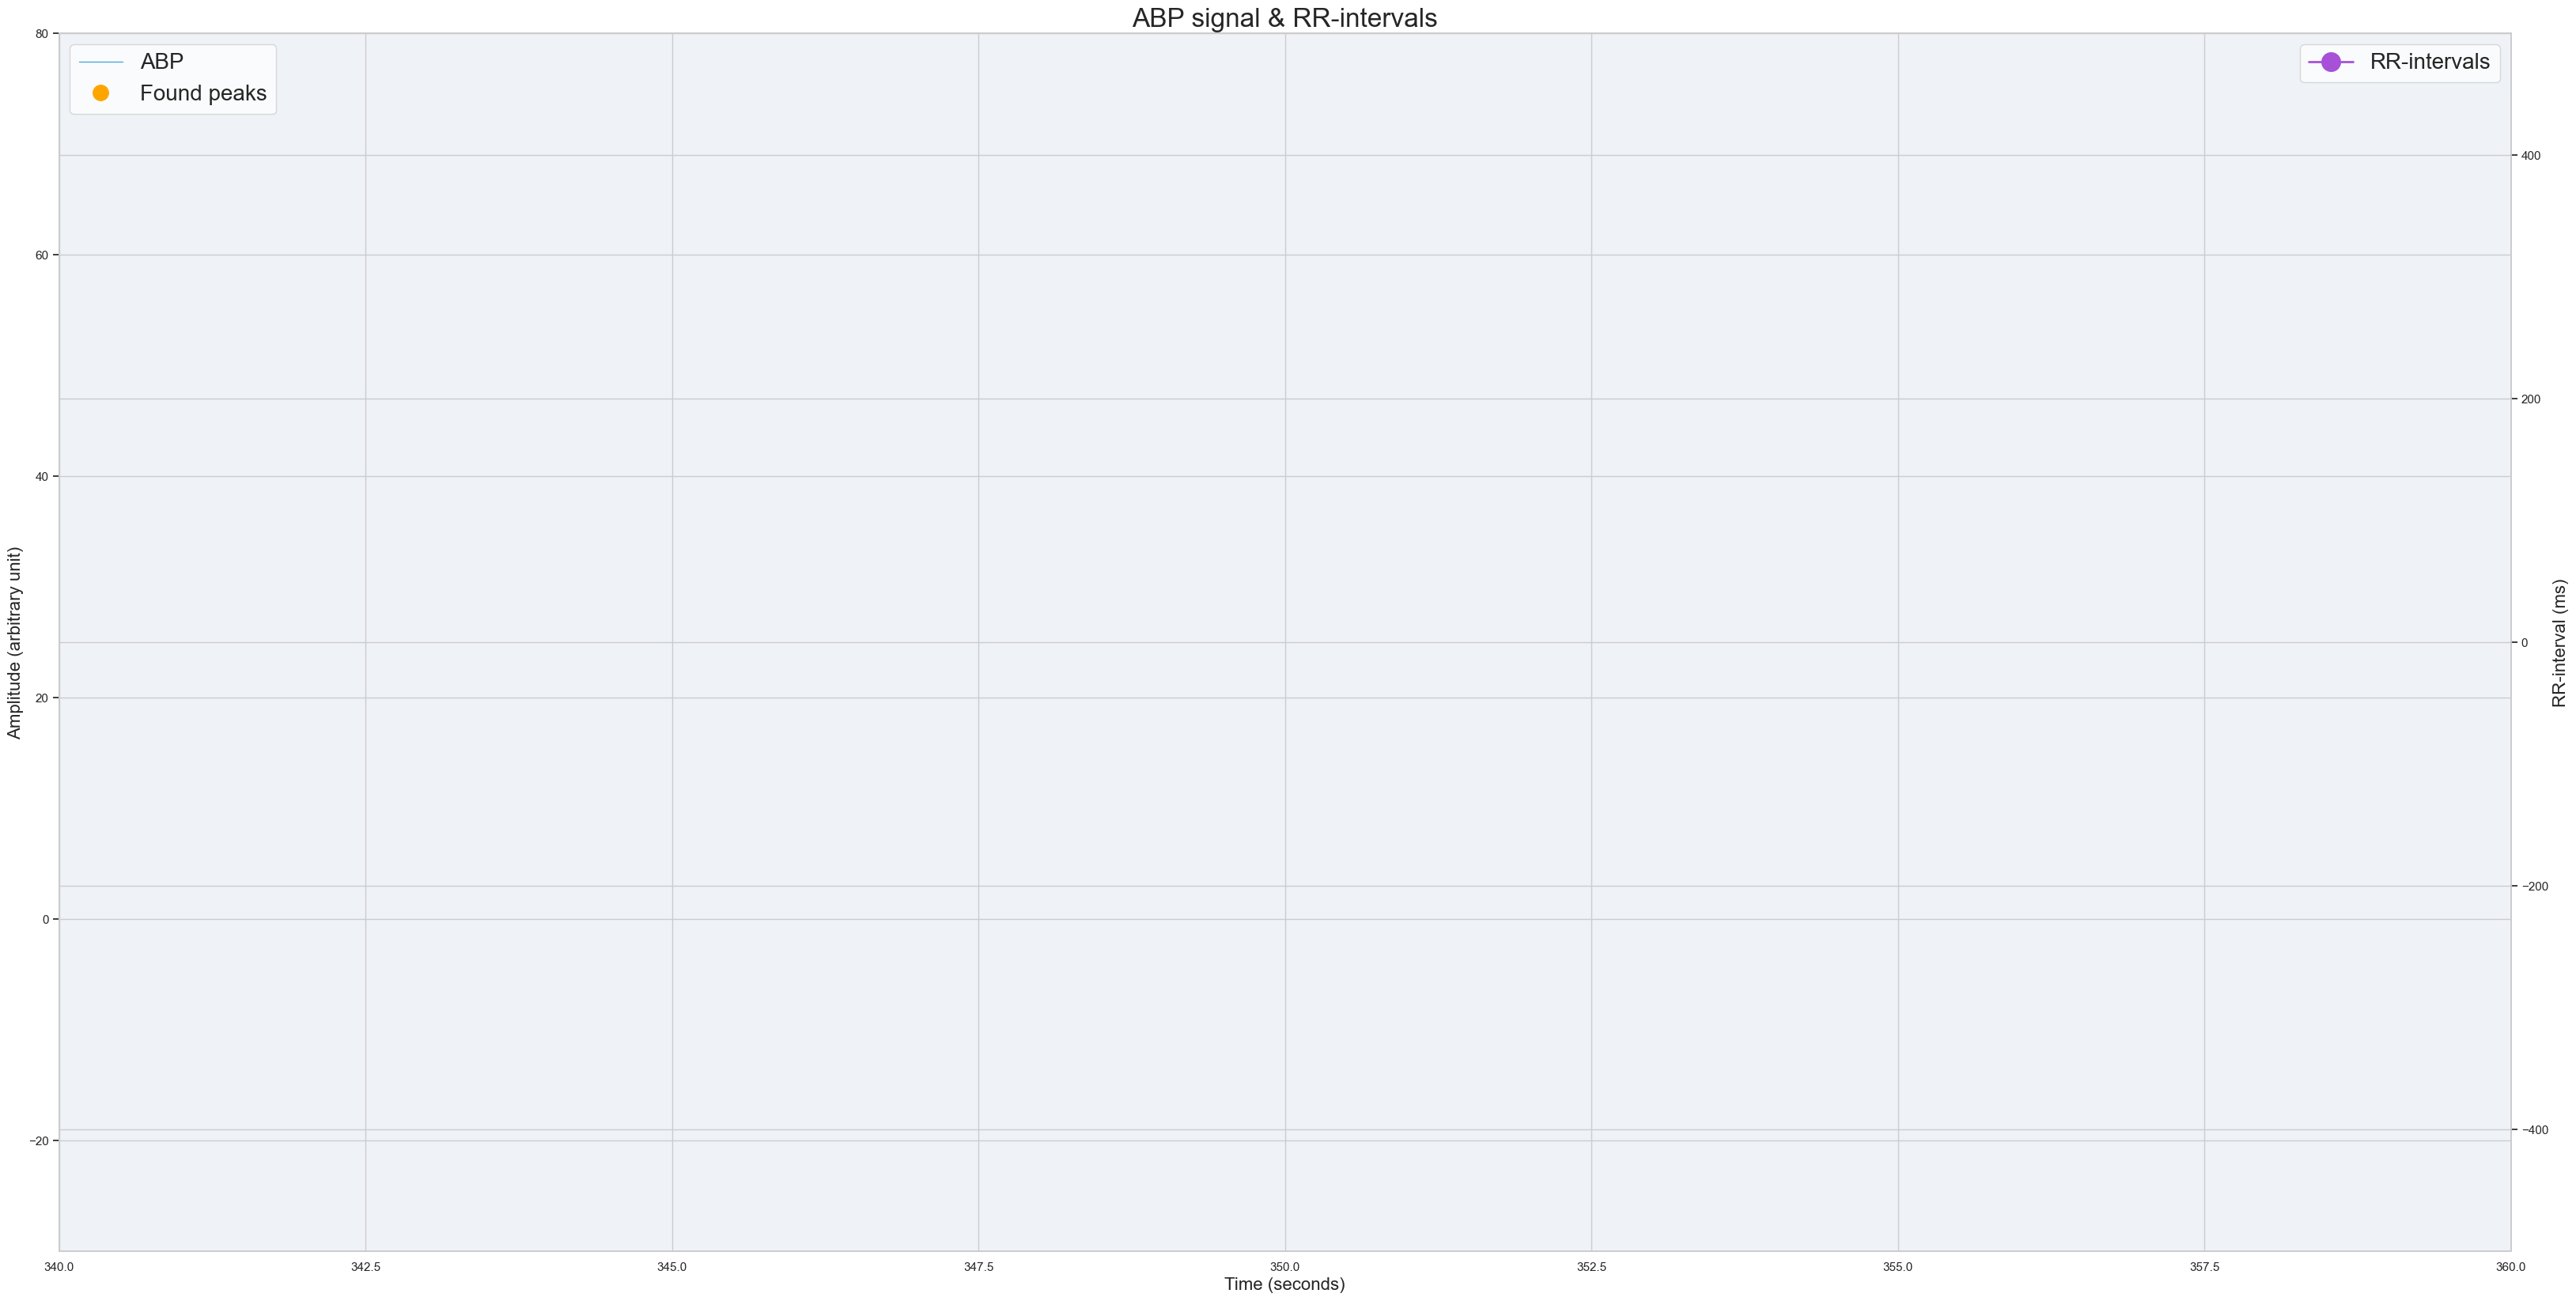

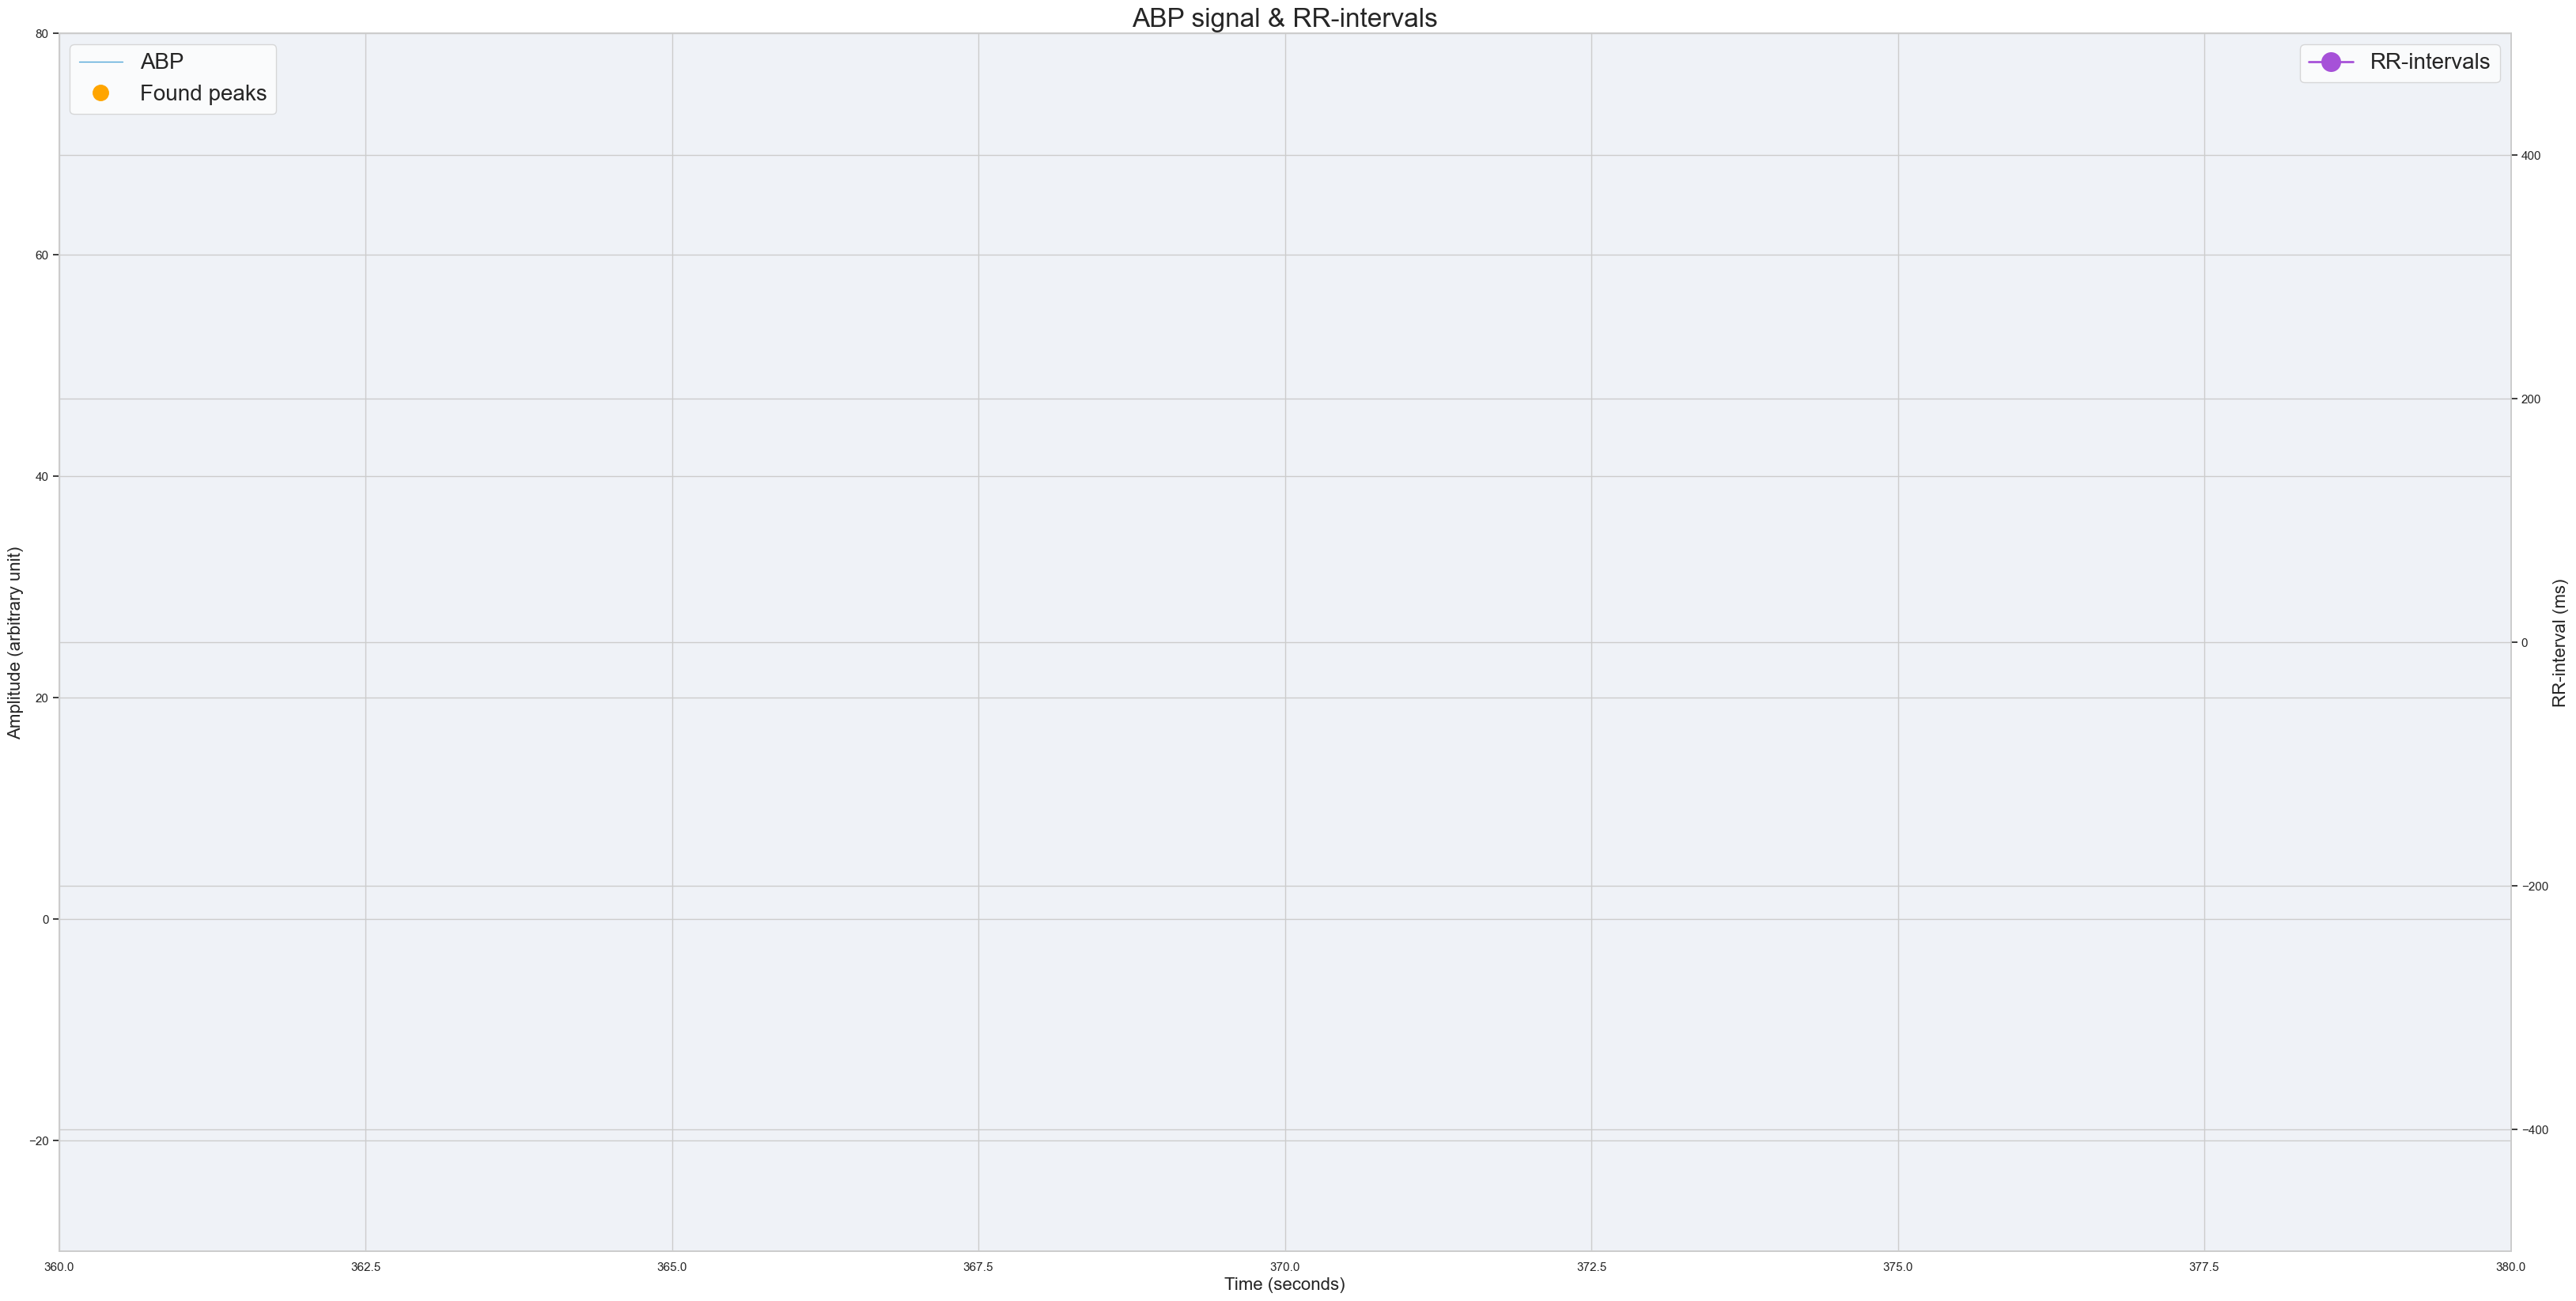

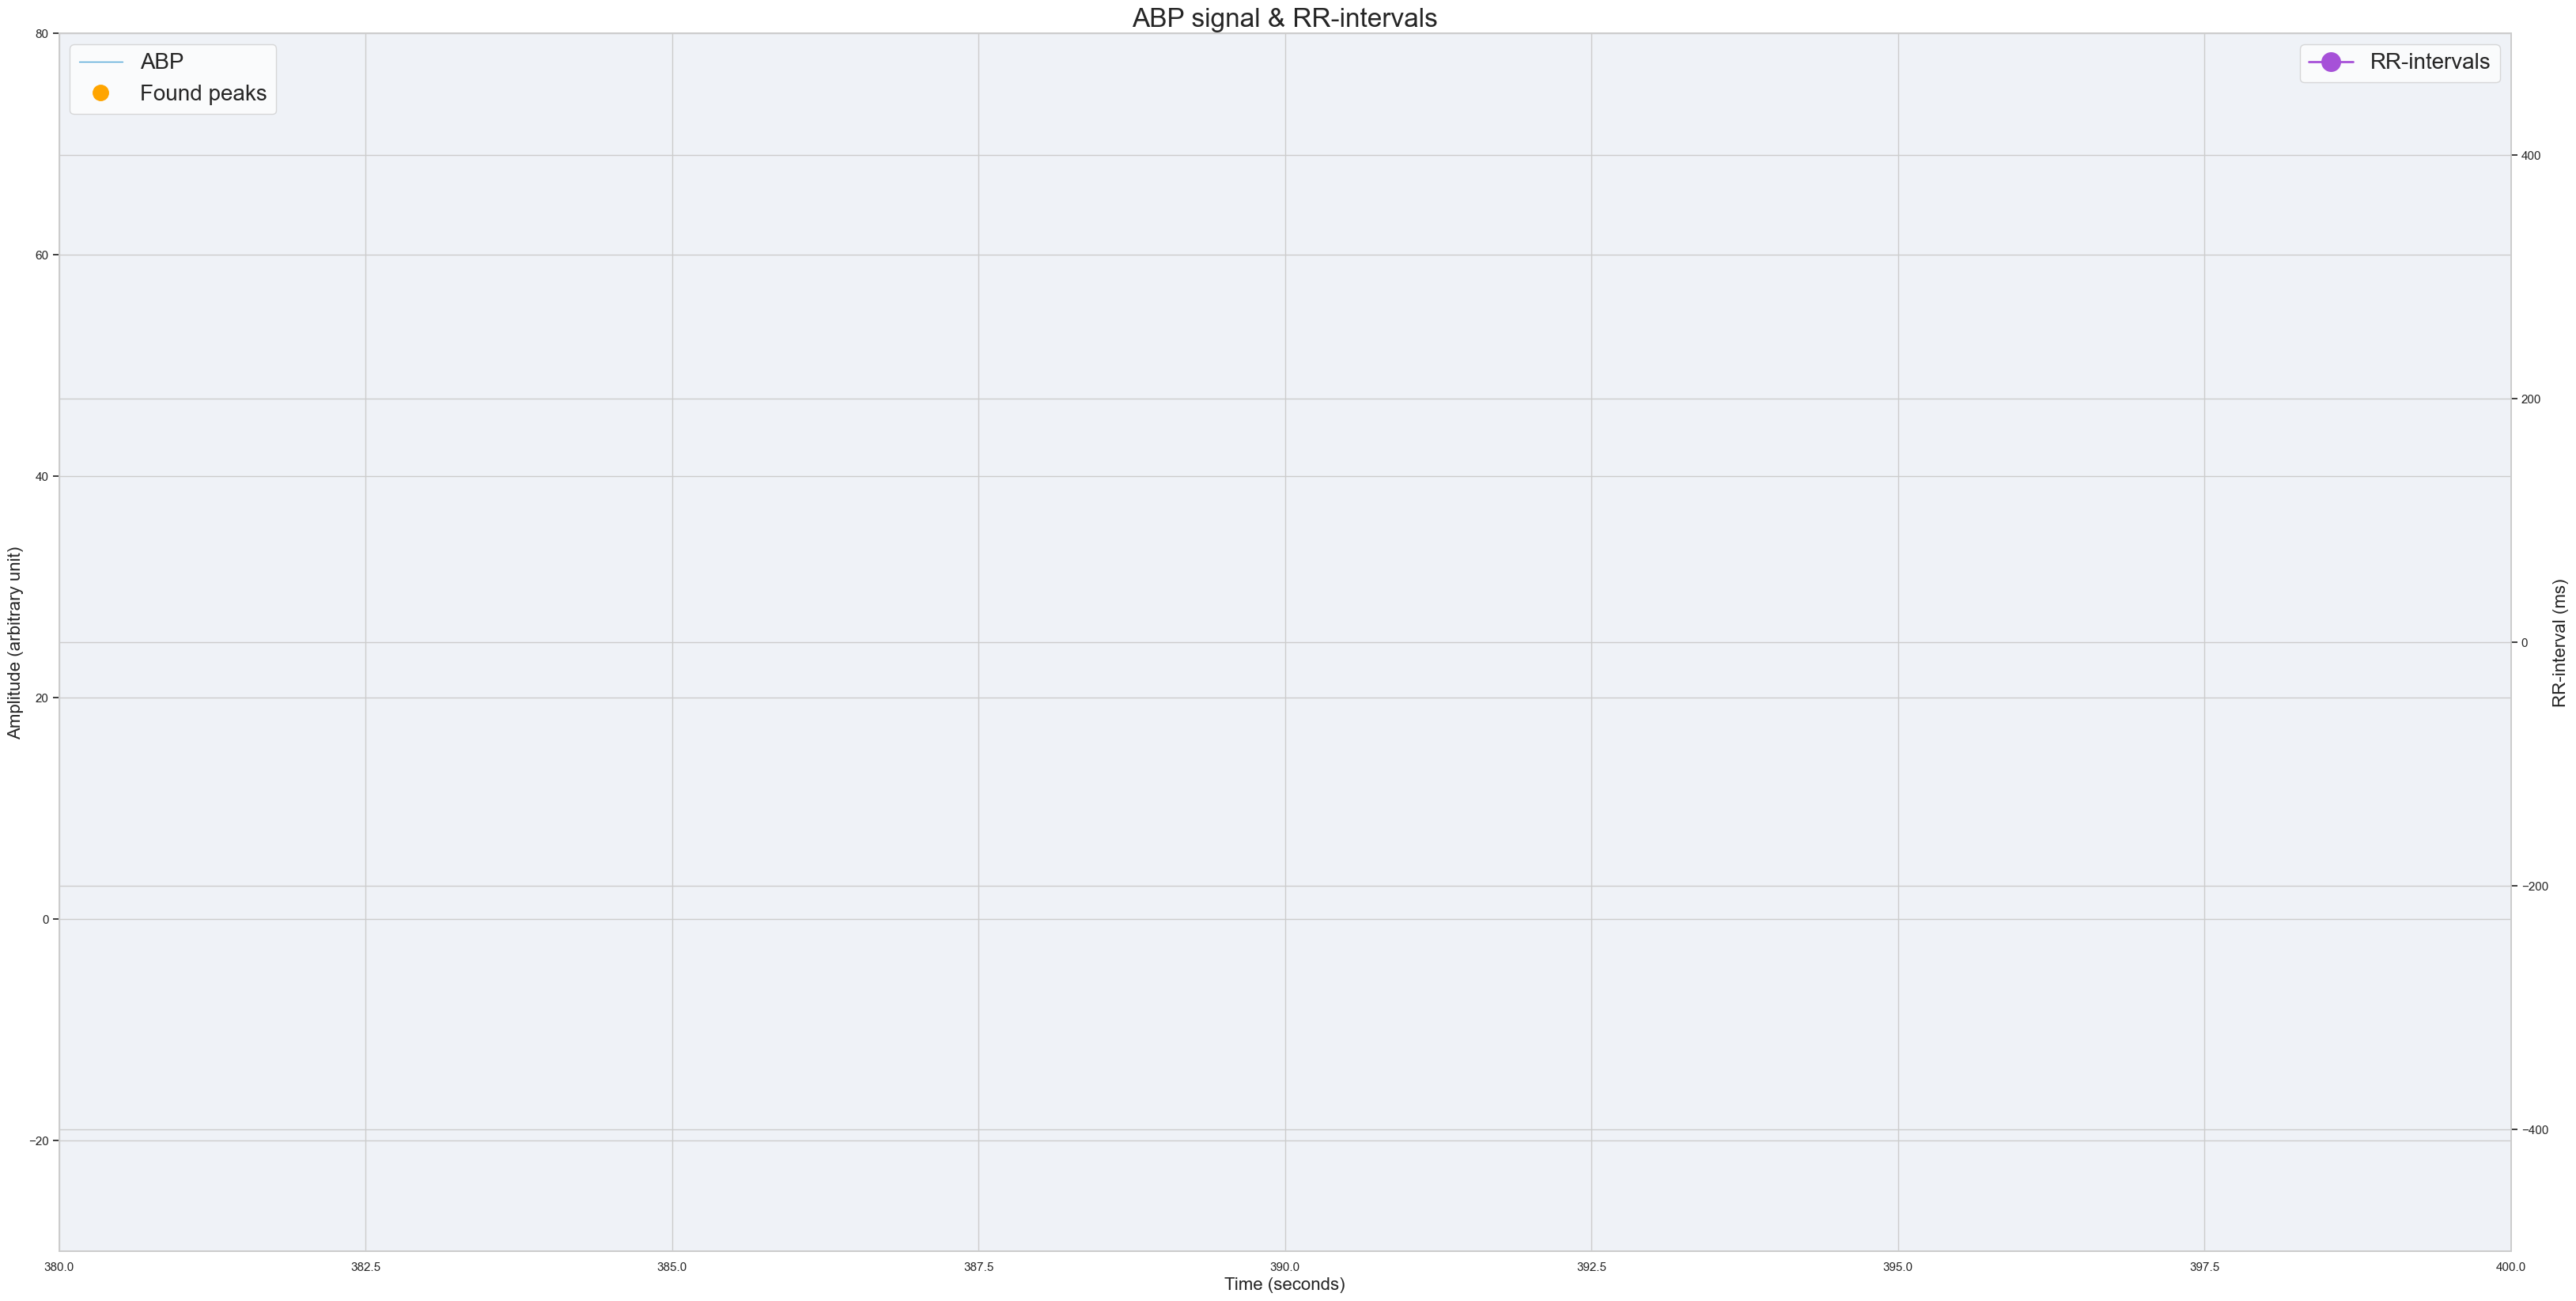

In [16]:
import prsa

sampfrom = 0
sampto = 80000
nr_plots = 20

# detect peaks
peaks, similarity = detect_peaks(df['Values'], threshold=TRESHOLD)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)#[:-75]

prsa_dc, dc_w = prsa.calculate(rr*5, 3, "DC", 0.2)
prsa_ac, ac_w = prsa.calculate(rr*5, 3, "AC", 0.2)

dc = prsa.capacity(prsa_dc)
ac = prsa.capacity(prsa_ac)

print("DC: %.2f" % dc)
print("AC: %.2f" % ac)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.title("ABP signal & RR-intervals", fontsize=24)
    plt.plot(df.index / 200, df['Values'], label="ABP", color="#51A6D8", linewidth=1)
    plt.plot(grouped_peaks / 200, np.repeat(60, grouped_peaks.shape[0]), markersize=14, label="Found peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper left", fontsize=20)
    plt.xlabel("Time (seconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    plt.gca().set_ylim(-30, 80)
    
    ax2 = plt.gca().twinx()
    ax2.plot((np.cumsum(rr)+peaks[0]) / 200, rr, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=18)
    ax2.set_xlim(start / 200, stop / 200)
    ax2.set_ylim(-500, 500)
    ax2.legend(loc="upper right", fontsize=20)

    plt.xlabel("Time (seconds)", fontsize=16)
    plt.ylabel("RR-interval (ms)", fontsize=16)